In [1]:
## Load module
import json
import os
import sys
import argparse
import time
from datetime import datetime

import tensorflow as tf
tf.keras.backend.set_floatx('float64') 

import optuna
from tensorflow.keras.backend import clear_session

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, ScalarFormatter, FormatStrFormatter

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_absolute_error as mae


from matplotlib import animation
matplotlib.rc('animation', html='html5')
from IPython.display import display
import matplotlib.ticker as ticker
from matplotlib import rcParams
from matplotlib.offsetbox import AnchoredText
import matplotlib.gridspec as gridspec
import netCDF4 as nc
from tqdm import tqdm

# import holoviews as hv
# from holoviews import opts, dim
# from holoviews.plotting.mpl import MPLPlot
# MPLPlot.sublabel_format=""

# Plot parameters
plt.rc('font', family='serif')
plt.rcParams.update({'font.size': 20,
                     'lines.linewidth': 2,
                     'lines.markersize':10,
                     'axes.labelsize': 16, # fontsize for x and y labels (was 10)
                     'axes.titlesize': 20,
                     'xtick.labelsize': 16,
                     'ytick.labelsize': 16,
                     'legend.fontsize': 16,
                     'axes.linewidth': 2})

import itertools
colors = itertools.cycle(['r','g','b','m','y','c'])
markers = itertools.cycle(['p','d','o','^','s','x',]) #'D','H','v','*'])

from pathlib import Path, PurePath
try:
    base_dir.exists()
except NameError:
    curr_dir = Path().resolve()
    base_dir = curr_dir.parent  

scripts_dir = base_dir / "scripts"
work_dir = base_dir / "Burgers"
data_dir = base_dir / "Burgers" / "functions"
model_dir = work_dir / "Saved_LDON_models"

if not os.path.exists(model_dir):
    os.mkdir(model_dir)

sys.path.append(str(scripts_dir.absolute()))
sys.path.append(str(work_dir.absolute()))
sys.path.append(str(data_dir.absolute()))

import modified_ldon as don
import burgers_exact as bg
import data_utils as du
# import nn_utils as nn
import autoencoder as ae
# import data_loader as dl 

from importlib import reload as reload

%matplotlib inline

2024-01-22 18:00:33.513535: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-22 18:00:33.514421: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-22 18:00:33.530641: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-22 18:00:34.113296: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/work/09152/srvdutta/ls6/anaconda3/envs/sciml/lib/

In [2]:


### Set up Training parameters
epochs_ae = 5000
epochs_don = 5000

scaling = True
scaler_min = 0
scaler_max = 1
re_train_list = [15,25,35,50,70,100,200,400,800]
re_val_list = [10,1000]
re_test_list = [10,30,75,150,300,600,1000]
x_extent_train = 0.8
t_extent_train = 1.6
x_extent_val = 1
t_extent_val = 2


In [3]:
def define_grid(L, T, vxn, vtn):
    vx = np.linspace(0,L,vxn)
    vt = np.linspace(0,T,vtn)
    return vx, vt

def plot_bounds_1d(p1,p2,p3,L,T, label1=None, vmin1=None, vmax1=None, name=None):
    
    if vmin1 is None:
        vmin1 = np.amin([p1.min(), p2.min()])
        vmax1 = np.amax([p1.max(), p2.max()])

    fig, ((ax1), (ax2), (ax3)) = plt.subplots(1,3, figsize=(20,3))
    pcm1 = ax1.imshow(p1,cmap='jet',origin='lower',
                      vmin=vmin1, vmax=vmax1, extent=(0,T,0,L), aspect = 0.79)
    ax1.yaxis.set_ticks(np.arange(0,L+0.1,1))
    fig.colorbar(pcm1,ax=ax1)
    ax1.set_title('Truth' +'\n'+ '%s = %.2f'%('Re', label1)+'\n'+
                 '%.4f<u<%.4f'%(tf.reduce_min(p1).numpy(), tf.reduce_max(p1).numpy()))
    pcm2 = ax2.imshow(p2,cmap='jet',origin='lower',
                      vmin=vmin1, vmax=vmax1, extent=(0,T,0,L), aspect = 0.79)
    ax2.yaxis.set_ticks(np.arange(0,L+0.1,1))

    fig.colorbar(pcm2,ax=ax2)
    ax2.set_title('Prediction' +'\n'+ '%s = %.2f'%('Re', label1)+'\n'
                 '%.4f<u<%.4f'%(tf.reduce_min(p2).numpy(), tf.reduce_max(p2).numpy()))
    pcm3 = ax3.imshow(p3,cmap='coolwarm',origin='lower',
                      vmin=-0.05, vmax=0.05, extent=(0,T,0,L), aspect = 0.79)
    ax3.yaxis.set_ticks(np.arange(0,L+0.1,1))

    cbar = fig.colorbar(pcm3,ax=ax3)
    ax3.set_title('Relative Error' +'\n'+ '%s = %.2f'%('Re', label1))
    
    ax1.set_ylabel('$x$',fontsize=18)
    ax1.set_xlabel('$t$',fontsize=18)
    ax2.set_xlabel('$t$',fontsize=18) 
    ax3.set_xlabel('$t$',fontsize=18)
    
    fig.tight_layout()
#     plt.savefig(name)

def plot_spcaetime_1d(p1,p2,p3,p4,p5,p6,T,L, colormap='jet', label1=None, label2=None, vmin1=None, vmax1=None, name=None):
    """
    Plot space-time 2d plots of 1D solutions
    Row1 : Predicted, True, Error for Soln1
    Row2 : Predicted, True, Error for Soln2
    """
    f = plt.figure(figsize=(15,10))
    gs = gridspec.GridSpec(3, 3, )
    gs.update(wspace=0.2, hspace=0.2) # set the spacing between axes.

    if vmin1 is None:
        vmin1 = np.amin([p1.min(), p2.min(), p3.min(), p4.min()])
        vmax1 = np.amax([p1.max(), p2.max(), p3.max(), p4.max()])

    ax1 = plt.subplot(gs[0, 0]);
    f1= ax1.imshow(p1,cmap=colormap,origin='lower',vmin=vmin1, vmax=vmax1, extent=(0,T,0,L), aspect = 0.59)
    ax1.yaxis.set_ticks(np.arange(0,L+0.1,1)); ax1.xaxis.set_ticks(np.arange(0,T+0.1,1))
    ax1.set_title('%s=%.2f'%('Re',label1[0]))

    ax2 = plt.subplot(gs[0, 1]);
    f2 = ax2.imshow(p2,cmap=colormap,origin='lower',vmin=vmin1, vmax=vmax1, extent=(0,T,0,L), aspect = 0.59)
    ax2.yaxis.set_ticks(np.arange(0,L+0.1,1)); ax2.xaxis.set_ticks(np.arange(0,T+0.1,1))
    ax2.set_title('%s=%.2f'%('Re',label1[1]))

    ax3 = plt.subplot(gs[1, 0]);
    f3= ax3.imshow(p3,cmap=colormap,origin='lower',vmin=vmin1, vmax=vmax1, extent=(0,T,0,L), aspect = 0.59)
    ax3.set_xticklabels([]); ax3.set_yticklabels([])
#     ax3.yaxis.set_ticks(np.arange(0,1.1,1))
    ax3.set_title('%s=%.2f'%('Re',label1[2]))

    ax4 = plt.subplot(gs[1, 1]);
    f4 = ax4.imshow(p4,cmap=colormap,origin='lower',vmin=vmin1, vmax=vmax1, extent=(0,T,0,L), aspect = 0.59)
    ax4.set_xticklabels([]); ax4.set_yticklabels([])
    ax4.set_title('%s=%.2f'%('Re',label1[3]))
    
    ax5 = plt.subplot(gs[2, 0]);
    f5= ax5.imshow(p5,cmap=colormap,origin='lower',vmin=vmin1, vmax=vmax1, extent=(0,T,0,L), aspect = 0.59)
    ax5.set_xticklabels([]); ax5.set_yticklabels([])
#     ax3.yaxis.set_ticks(np.arange(0,1.1,1))
    ax5.set_title('%s=%.2f'%('Re',label1[4]))

    ax6 = plt.subplot(gs[2, 1]);
    f6 = ax6.imshow(p6,cmap=colormap,origin='lower',vmin=vmin1, vmax=vmax1, extent=(0,T,0,L), aspect = 0.59)
    cbar1 = f.colorbar(f6, ax=list((ax1, ax2, ax3, ax4, ax5, ax6)),orientation='horizontal',aspect=50, pad=0.1)
    ax6.set_xticklabels([]); ax6.set_yticklabels([])
    ax6.set_title('%s=%.2f'%('Re',label1[5]))

    ax1.set_ylabel('$x$',fontsize=18); #ax2.set_ylabel('$x$',fontsize=18);
    ax3.set_ylabel('$x$',fontsize=18); #ax4.set_ylabel('$x$',fontsize=18);

    ax5.set_xlabel('$t$',fontsize=18); ax6.set_xlabel('$t$',fontsize=18); 
    ax5.set_ylabel('$x$',fontsize=18); #ax6.set_ylabel('$x$',fontsize=18);
#     plt.savefig(name)



def multiple_ae_burgers(Re_list,vxn,VX,vtn,VT):
    
    number_cases = len(Re_list)
    
    burgers_array = np.zeros((number_cases*vtn,vxn))

    id0 = 0
    id1 = vtn
    for Re in Re_list:
        solution = bg.true_solution(VX,VT,Re)
        
        burgers_array[id0:id1,:] = solution
        id0 = id1; id1 = id1 + vtn  
            
    return burgers_array

In [4]:
## Load training data for AE
Re_train = re_train_list
L_train = x_extent_train
T_train = t_extent_train
vxn = 300
vtn = 500
vx, vt = define_grid(L_train, T_train, vxn, vtn)
VX, VT = np.meshgrid(vx,vt)
train_data = multiple_ae_burgers(Re_train,vxn,VX,vtn,VT)


## Load validation data for AE
Re_val = re_val_list
L_val = x_extent_val
T_val = t_extent_val
vx, vt = define_grid(L_val, T_val, vxn, vtn)
val_data = multiple_ae_burgers(Re_val,vxn,VX,vtn,VT)

## Load test data for AE
Re_test =  re_test_list
L_test = L_val
T_test = T_val
vx, vt = define_grid(L_test, T_test, vxn, vtn)
test_data = multiple_ae_burgers(Re_test,vxn,VX,vtn,VT)



reload(du)
if scaling:
    scale_min, scale_max = 0, 1
    scaler = du.data_scaler(v_min=scale_min, v_max=scale_max)
    
    ## Flatten and scale
    train_data_scaled, = scaler((train_data,))
    val_data_scaled, test_data_scaled = scaler((val_data, test_data))

    data_min, data_max = scaler.u_min, scaler.u_max
    
    train_data_unscaled, val_data_unscaled, test_data_unscaled = scaler.scale_inverse((train_data_scaled, val_data_scaled, test_data_scaled))
else:
    train_data_scaled, val_data_scaled, test_data_scaled = train_data, val_data, test_data
    scale_min, scale_max = None, None


print(f"Training dataset statistics=====\n")
print(f"Max: {train_data.max()}, Min: {train_data.min()}" )
if scaling:
    print(f"Scaled Max: {train_data_scaled.max()}, Scaled Min: {train_data_scaled.min()}" )
    print(f"Reconstructed Max: {train_data_unscaled.max()}, Reconstructed Min: {train_data_unscaled.min()}" )

print(f"\n\nTest dataset statistics=====\n")
print(f"Max: {test_data.max()}, Min: {test_data.min()}" )
if scaling:
    print(f"Scaled Max: {test_data_scaled.max()}, Scaled Min: {test_data_scaled.min()}" )
    print(f"Reconstructed Max: {test_data_unscaled.max()}, Reconstructed Min: {test_data_unscaled.min()}" )

Training dataset statistics=====

Max: 0.4716823455361204, Min: 0.0
Scaled Max: 1.0, Scaled Min: 0.0
Reconstructed Max: 0.4716823455361204, Reconstructed Min: 0.0


Test dataset statistics=====

Max: 0.4763871154484893, Min: 0.0
Scaled Max: 1.0099744456346387, Scaled Min: 0.0
Reconstructed Max: 0.4763871154484893, Reconstructed Min: 0.0


In [5]:
## Train the AE 

Nn = train_data_scaled.shape[1]
Nt = train_data_scaled.shape[0]

print(f"Full order dimension: {Nn}")


steps = 500 #1000
factor = 0.9
learning_rate_decay = True
batch_size = 256
init_lr = 1e-4
number_layers = 4
latent_dim = 10

enc_act = 'swish' 
dec_act = 'swish'

if learning_rate_decay == True:
    init_learn_rate = tf.keras.optimizers.schedules.ExponentialDecay(init_lr, 
                                decay_steps = steps, decay_rate = factor, staircase = True)
else:
    init_learn_rate = init_lr

set_opt = ae.Optimizer(lr=init_learn_rate)
optimizerr = "Adam"

size = np.zeros(number_layers,dtype=int)
for i in range(number_layers):
    if i==0:
        size[i] = int(Nn)
    else:
        size[i] = int(size[i-1]/2)


## Define minibatch generators for training and
## validation using Tensorflow Dataset API
size_buffer = train_data_scaled.shape[0] 
    
train_ds, val_ds = ae.gen_batch_ae(train_data_scaled, val_data_scaled,  
                                 batch_size = batch_size, shuffle_buffer = size_buffer)

ae_model = ae.Autoencoder(latent_dim, enc_act, dec_act, size, )

ae_model.compile(optimizer = set_opt.get_opt(opt=optimizerr), 
              loss_fn = tf.keras.losses.MeanSquaredError(), #ae.MyNMSELoss(), #
              # metrics=additional_metrics)
             )

save_logs = False
save_model = False

model_dir_train = model_dir if save_model else None
log_dir_train = log_dir if save_logs else None

init_time = time.time()

history = ae_model.fit(train_ds, #train_data_scaled,
                    validation_data = (val_ds,), #(val_data_scaled, val_data_scaled),
                    epochs = epochs_ae, #callbacks=[es], 
                    verbose = 1,)
end_time = time.time()



Full order dimension: 300


2024-01-22 18:00:55.437146: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-22 18:00:55.622243: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-22 18:00:55.624641: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Epoch 1/5000


2024-01-22 18:01:00.781666: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x14af9c5ae8e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-22 18:01:00.781722: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A100-PCIE-40GB, Compute Capability 8.0
2024-01-22 18:01:00.836682: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-01-22 18:01:00.938478: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2024-01-22 18:01:01.177613: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


18/18 [==============================] - 5s 14ms/step - loss: 0.1188 - val_loss: 0.1447
Epoch 2/5000
18/18 [==============================] - 0s 6ms/step - loss: 0.1085 - val_loss: 0.1199
Epoch 3/5000
18/18 [==============================] - 0s 6ms/step - loss: 0.0788 - val_loss: 0.0767
Epoch 4/5000
18/18 [==============================] - 0s 6ms/step - loss: 0.0473 - val_loss: 0.0456
Epoch 5/5000
18/18 [==============================] - 0s 6ms/step - loss: 0.0282 - val_loss: 0.0318
Epoch 6/5000
18/18 [==============================] - 0s 6ms/step - loss: 0.0187 - val_loss: 0.0260
Epoch 7/5000
18/18 [==============================] - 0s 6ms/step - loss: 0.0145 - val_loss: 0.0237
Epoch 8/5000
18/18 [==============================] - 0s 6ms/step - loss: 0.0128 - val_loss: 0.0233
Epoch 9/5000
18/18 [==============================] - 0s 6ms/step - loss: 0.0119 - val_loss: 0.0234
Epoch 10/5000
18/18 [==============================] - 0s 6ms/step - loss: 0.0114 - val_loss: 0.0230
Epoch 11/50

Training time: 0 H 13 M, 41 S
Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Encoder)           multiple                  59667     
                                                                 
 decoder (Decoder)           multiple                  59957     
                                                                 
Total params: 119624 (934.56 KB)
Trainable params: 119624 (934.56 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________

*********AE inverse decoder reconstruction error*********

u  Reconstruction MSE: 0.02688737467122284

Train_list = [15, 25, 35, 50, 70, 100, 200, 400, 800], Val_list = [10, 1000], Test_list = [10, 30, 75, 150, 300, 600, 1000]
Trains for 0h 13m 41s,
Step decay LR scheduler starting from 1.00e-04, Batch Size = 256,
Decay factor = 0.900 every 500 epochs. Trained for 5000 epochs,S

INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(37, 10), dtype=tf.float64, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x14b13d82d510>, 22751472272080), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float64, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x14b13d85d660>, 22751472271696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float64, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x14b13d85d660>, 22751472271696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(300, 150), dtype=tf.float64, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x14b13d85f490>, 22751473912976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(300, 150), dtype=tf.float64, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x14b13d85f490>, 22751473912976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(150,), dtype=tf.float64, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x14b13d82e6e0>, 22751473918448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(150,), dtype=tf.float64, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x14b13d82e6e0>, 22751473918448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(150, 75), dtype=tf.float64, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x14b13d82d000>, 22751474297392), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(150, 75), dtype=tf.float64, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x14b13d82d000>, 22751474297392), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(75,), dtype=tf.float64, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x14b13d882680>, 22751474297776), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(75,), dtype=tf.float64, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x14b13d882680>, 22751474297776), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(75, 37), dtype=tf.float64, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x14b13d882c80>, 22751474300464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(75, 37), dtype=tf.float64, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x14b13d882c80>, 22751474300464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(37,), dtype=tf.float64, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x14b13d600910>, 22751474300848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(37,), dtype=tf.float64, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x14b13d600910>, 22751474300848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(150, 300), dtype=tf.float64, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x14b13d601930>, 22751472286480), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(150, 300), dtype=tf.float64, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x14b13d601930>, 22751472286480), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(300,), dtype=tf.float64, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x14b13d602980>, 22751472286576), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(300,), dtype=tf.float64, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x14b13d602980>, 22751472286576), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 37), dtype=tf.float64, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x14b13d603970>, 22751472274192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 37), dtype=tf.float64, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x14b13d603970>, 22751472274192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(37,), dtype=tf.float64, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x14b13d644a30>, 22751472276976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(37,), dtype=tf.float64, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x14b13d644a30>, 22751472276976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(37, 75), dtype=tf.float64, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x14b13d645b70>, 22751472279568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(37, 75), dtype=tf.float64, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x14b13d645b70>, 22751472279568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(75,), dtype=tf.float64, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x14b13d646c20>, 22751472276496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(75,), dtype=tf.float64, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x14b13d646c20>, 22751472276496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(75, 150), dtype=tf.float64, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x14b13d647c10>, 22751472283696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(75, 150), dtype=tf.float64, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x14b13d647c10>, 22751472283696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(150,), dtype=tf.float64, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x14b13d698ca0>, 22751472282928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(150,), dtype=tf.float64, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x14b13d698ca0>, 22751472282928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(37, 10), dtype=tf.float64, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x14b13d82d510>, 22751472272080), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(37, 10), dtype=tf.float64, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x14b13d82d510>, 22751472272080), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float64, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x14b13d85d660>, 22751472271696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float64, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x14b13d85d660>, 22751472271696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(300, 150), dtype=tf.float64, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x14b13d85f490>, 22751473912976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(300, 150), dtype=tf.float64, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x14b13d85f490>, 22751473912976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(150,), dtype=tf.float64, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x14b13d82e6e0>, 22751473918448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(150,), dtype=tf.float64, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x14b13d82e6e0>, 22751473918448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(150, 75), dtype=tf.float64, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x14b13d82d000>, 22751474297392), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(150, 75), dtype=tf.float64, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x14b13d82d000>, 22751474297392), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(75,), dtype=tf.float64, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x14b13d882680>, 22751474297776), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(75,), dtype=tf.float64, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x14b13d882680>, 22751474297776), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(75, 37), dtype=tf.float64, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x14b13d882c80>, 22751474300464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(75, 37), dtype=tf.float64, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x14b13d882c80>, 22751474300464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(37,), dtype=tf.float64, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x14b13d600910>, 22751474300848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(37,), dtype=tf.float64, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x14b13d600910>, 22751474300848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(150, 300), dtype=tf.float64, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x14b13d601930>, 22751472286480), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(150, 300), dtype=tf.float64, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x14b13d601930>, 22751472286480), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(300,), dtype=tf.float64, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x14b13d602980>, 22751472286576), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(300,), dtype=tf.float64, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x14b13d602980>, 22751472286576), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 37), dtype=tf.float64, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x14b13d603970>, 22751472274192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 37), dtype=tf.float64, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x14b13d603970>, 22751472274192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(37,), dtype=tf.float64, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x14b13d644a30>, 22751472276976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(37,), dtype=tf.float64, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x14b13d644a30>, 22751472276976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(37, 75), dtype=tf.float64, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x14b13d645b70>, 22751472279568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(37, 75), dtype=tf.float64, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x14b13d645b70>, 22751472279568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(75,), dtype=tf.float64, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x14b13d646c20>, 22751472276496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(75,), dtype=tf.float64, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x14b13d646c20>, 22751472276496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(75, 150), dtype=tf.float64, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x14b13d647c10>, 22751472283696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(75, 150), dtype=tf.float64, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x14b13d647c10>, 22751472283696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(150,), dtype=tf.float64, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x14b13d698ca0>, 22751472282928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(150,), dtype=tf.float64, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x14b13d698ca0>, 22751472282928), {}).


INFO:tensorflow:Assets written to: /home1/09152/srvdutta/codes/deeponet-wabe/Burgers/Saved_LDON_models/Burgers_AE_2024-01-22_181443/autoenc/assets


INFO:tensorflow:Assets written to: /home1/09152/srvdutta/codes/deeponet-wabe/Burgers/Saved_LDON_models/Burgers_AE_2024-01-22_181443/autoenc/assets


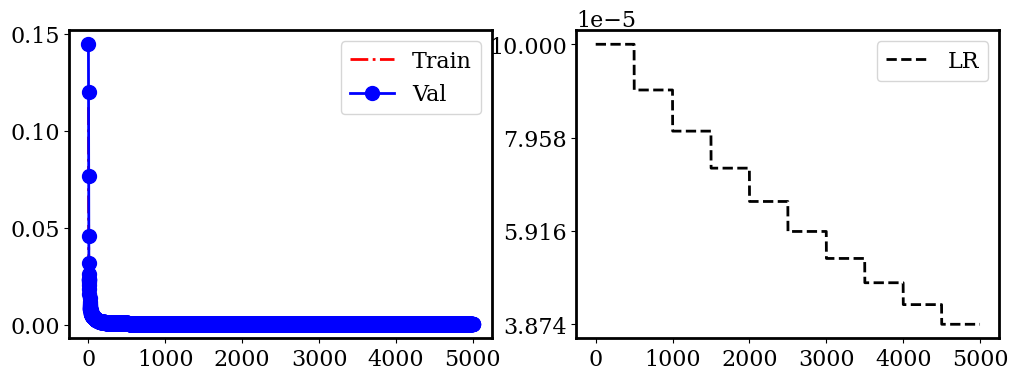

In [6]:
## Visualize AE model results and save Model

train_time = end_time - init_time
hrs = int(train_time//3600); rem_time = train_time - hrs*3600
mins = int(rem_time//60); secs = int(rem_time%60)
print('Training time: %d H %d M, %d S'%(hrs,mins,secs))

ae_model.build(train_data.shape)
ae_model.summary()


encoded = ae_model.encoder(train_data_scaled).numpy()
decoded = ae_model.decoder(encoded).numpy()

print('\n*********AE inverse decoder reconstruction error*********\n')
print('u  Reconstruction MSE: ' + str(np.mean(np.square(scaler.scale_inverse((decoded,))))))

train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = history.epoch
lr = [history.model.optimizer._learning_rate(ix).numpy() for ix in epochs]  ### Seems to work for ExponentialDecay scheduler
# lr = history.history['lr']

fig, axs = plt.subplots(1,2, figsize=(12,4))
axs[0].plot(epochs,train_loss,'r-.',label="Train")
axs[0].plot(epochs,val_loss,'b-o', label="Val")
axs[0].legend()

axs[1].plot(epochs,lr,'k--', label="LR")
axs[1].set_yticks(np.linspace(min(lr),max(lr),4))
axs[1].legend()

## Save the trained AE model
reload(ae)
save_model = True
if save_model:
    
    timestamp = datetime.now().strftime("%Y-%m-%d_%H%M%S")
    out_dir = os.path.join(model_dir, "Burgers_AE_"+timestamp)
    if not os.path.exists(out_dir):
        os.mkdir(out_dir)

    msg = f'Train_list = {re_train_list}, Val_list = {re_val_list}, Test_list = {re_test_list}'\
        +'\nTrains for %dh %dm %ds,'%(hrs,mins,secs)\
        +'\nStep decay LR scheduler starting from %.2e, Batch Size = %d,'%(init_lr, batch_size)\
        +'\nDecay factor = %.3f every %d epochs.'%(factor,steps)+' Trained for %d epochs,'%(len(epochs))\
        +'Scaling to [%d,%d],'%(scale_min, scale_max)\
        +'\nEncoder input is not augmented by parameter value'
    print("\n===========")
    print(msg)
    
    
    model_results = {'loss': train_loss, 'valloss': val_loss,
                     'epochs': epochs, 'msg': msg, 'lr': lr,
                     'umax': scale_max, 'umin': scale_min,
                     'savedir': str(out_dir), 'timestamp': timestamp }

    ae.save_model(ae_model, train_data_scaled.shape, model_results)

141/141 [==============================] - 0s 2ms/step


Text(0.5, 1.0, 'AE solution')

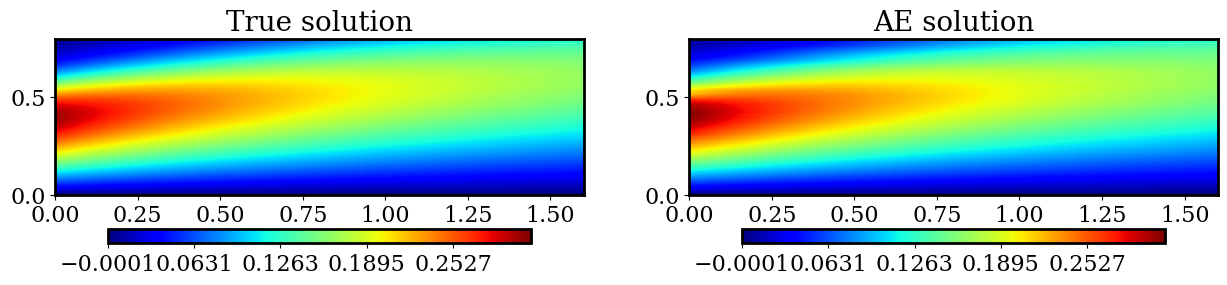

In [7]:
## Test AE predictions
pred_scaled = ae_model.predict(train_data_scaled[:,:])
pred = scaler.scale_inverse((pred_scaled,))


## Plot training fields
pn = np.random.randint(len(re_train_list))
true_field = train_data[pn*vtn:(pn+1)*vtn,:]
pred_field = pred[0][pn*vtn:(pn+1)*vtn,:]
valmax = np.amax([pred_field,true_field]) #true_field.max(); print(valmax)
valmin = np.amin([pred_field,true_field])  #true_field.min(); print(valmin)


lvls = np.linspace(np.amin([pred_field,true_field]),np.amax([pred_field,true_field]),50)
tks = lvls[0:-1:10]

fig, axs = plt.subplots(1,2, figsize=(15,5))
f1 = axs[0].imshow(true_field.T,cmap='jet',origin='lower',vmin=valmin, vmax=valmax, extent=(0,T_train,0,L_train), aspect = 0.59)
plt.colorbar(f1, ticks = tks, orientation='horizontal',shrink=0.8,aspect=30, pad = 0.09)

f2 = axs[1].imshow(pred_field.T,cmap='jet',origin='lower',vmin=valmin, vmax=valmax, extent=(0,T_train,0,L_train), aspect = 0.59)
plt.colorbar(f2, ticks = tks, orientation='horizontal',shrink=0.8,aspect=30, pad = 0.09)

axs[0].set_title(f"True solution")
axs[1].set_title(f"AE solution")

# fig.suptitle(f"{key} at t = {mesh['t'][int(itn%Nt)]/3600} hrs")

In [8]:

def multiple_ldon_burgers(Re_list,vxn,VX,L,vtn,VT,T,latent_data):
    
    number_cases = len(Re_list)
    x_grid, t_grid = define_grid(L,T,vxn,vtn)

    for inx,Re in enumerate(Re_list):
        solution = bg.true_solution(VX,VT,Re)
        latent_target = latent_data[inx,:,:]

        for id_t,it in tqdm(enumerate(t_grid)):
            # idx_t = np.searchsorted()
            u0 = solution[id_t,:]  ## initial solution to be used as input to branch

            if inx==0 and id_t==0:
                b_input = np.hstack([Re, u0])
                t_input = it
                target = latent_target[id_t,:]
                
            else:
                b_input = np.vstack([b_input, np.hstack([Re, u0])])
                t_input = np.vstack([t_input, it])
                target = np.vstack([target,latent_target[id_t,:]])  
    
    return b_input, t_input, target

In [9]:
## Load data for LDON training

train_ls = ae_model.encoder(train_data_scaled)
val_ls = ae_model.encoder(val_data_scaled)
test_ls = ae_model.encoder(test_data_scaled)

Nt_train = train_data_scaled.shape[0]
Nt_val = val_data_scaled.shape[0]
Nt_test = test_data_scaled.shape[0]

latent_dim = train_ls.shape[1]
# assert latent_dim == trial.params['latent_space'], "Optuna trials not available"

train_ls = np.reshape(train_ls,(len(re_train_list),int(Nt_train/len(re_train_list)),latent_dim))
val_ls = np.reshape(val_ls,(len(re_val_list),int(Nt_val/len(re_val_list)),latent_dim))
test_ls = np.reshape(test_ls,(len(re_test_list),int(Nt_test/len(re_test_list)),latent_dim))



Re_train = re_train_list
L_train = x_extent_train
T_train = t_extent_train
b_train, t_train, target_train = multiple_ldon_burgers(Re_train,vxn,VX,L_train,vtn,VT,T_train,train_ls)
    
Re_val = re_val_list
L_val = x_extent_val
T_val = t_extent_val

b_val, t_val, target_val = multiple_ldon_burgers(Re_val,vxn,VX,L_val,vtn,VT,T_val,val_ls)



if scaling is True:
    t_scaler = MinMaxScaler(feature_range=( scaler_min,  scaler_max))
    b_scaler = MinMaxScaler(feature_range=( scaler_min,  scaler_max))
    ls_scaler = MinMaxScaler(feature_range=( scaler_min,  scaler_max))

    # changed global scaling, easier for now - PRC
    t_scaler.fit(np.concatenate([t_train,t_val]))
    b_scaler.fit(np.concatenate([b_train,b_val]))
    ls_scaler.fit(np.concatenate([target_train,target_val]))

    t_train = np.squeeze(t_scaler.transform(t_train))
    b_train = b_scaler.transform(b_train)
    target_train = np.squeeze(ls_scaler.transform(target_train))
    
    t_val = np.squeeze(t_scaler.transform(t_val))
    b_val = b_scaler.transform(b_val)
    target_val = np.squeeze(ls_scaler.transform(target_val))

500it [00:00, 20398.53it/s]
500it [00:00, 11541.46it/s]
500it [00:00, 7920.00it/s]
500it [00:00, 5928.86it/s]
500it [00:00, 4637.87it/s]
500it [00:00, 3987.19it/s]
500it [00:00, 3487.84it/s]
500it [00:00, 3055.07it/s]
500it [00:00, 1457.95it/s]
500it [00:00, 21031.46it/s]
500it [00:00, 11502.27it/s]


In [ ]:
## Train the LDON model


branch_sensors = b_train.shape[1]
l_factor = 9
b_number_layers = 3
b_actf = 'swish'
b_regularizer = 'l2'
b_initializer = 'he_normal'
b_encoder_layers =  1
b_encoder_actf =  'swish'
b_encoder_regularizer = 'l2'
b_encoder_initializer = 'glorot_uniform'
t_number_layers =  5
t_actf = 'swish'
t_regularizer = 'l1'
t_initializer = 'he_uniform'
t_encoder_layers =  5
t_encoder_actf = 'swish'
t_encoder_initializer = 'he_uniform'
t_encoder_regularizer = 'l2' 
init_lr = 0.0001

nn = don.don_nn(l_factor, 
                latent_dim, 
                branch_sensors,
                b_number_layers, 
                l_factor*latent_dim, 
                b_actf, 
                b_initializer, 
                b_regularizer, 
                b_encoder_layers, 
                l_factor*latent_dim, 
                b_encoder_actf, 
                b_encoder_initializer, 
                b_encoder_regularizer, 
                1, 
                t_number_layers, 
                l_factor*latent_dim, 
                t_actf, 
                t_initializer, 
                t_regularizer, 
                t_encoder_layers, 
                l_factor*latent_dim, 
                t_encoder_actf, 
                t_encoder_initializer, 
                t_encoder_regularizer)



ldon_model = don.don_model(nn)

optimizer = tf.keras.optimizers.Adam(init_lr)  

loss_obj = tf.keras.losses.MeanSquaredError()

ldon_model.compile(
    optimizer = optimizer,
    loss_fn = loss_obj)
    

batch_size = 96 

dataset = tf.data.Dataset.from_tensor_slices((b_train,t_train, target_train))
dataset = dataset.shuffle(buffer_size=int(t_train.shape[0])).batch(batch_size)
   
val_dataset = tf.data.Dataset.from_tensor_slices((b_val,t_val, target_val))
val_dataset = val_dataset.batch(batch_size)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.9,
                    patience=200, min_lr=1e-8, min_delta=0, verbose=1)



# early_stop = tf.keras.callbacks.EarlyStopping(
#     monitor='val_loss',
#     min_delta=1e-8,
#     patience=500,
#     verbose=1,
#     restore_best_weights=True
# )

i=1

timestamp_don = datetime.now().strftime("%Y-%m-%d_%H%M%S")
out_dir = os.path.join(model_dir, 'Burgers_LDON_'+timestamp_don) 
if not os.path.exists(out_dir):
    os.mkdir(out_dir)

    
init_time = time.time()

# Train the model on all available devices.
ldon_model.fit(dataset, validation_data=val_dataset, epochs=epochs_don,
       callbacks=[reduce_lr, ])  #model_check ])  #early_stop,])  # ])  ## Removed by SD


end_time = time.time()
train_time = end_time - init_time
hrs = int(train_time//3600); rem_time = train_time - hrs*3600
mins = int(rem_time//60); secs = int(rem_time%60)
print('Training time: %d H %d M, %d S'%(hrs,mins,secs))


# model.save(out_dir,id_branch,)
ldon_model.save(out_dir)#+str(i),id_branch)  
np.savez('ldon_history_'+key, history=ldon_model.history.history, allow_pickle=True,)



Epoch 1/5000
44/47 [===========================>..] - ETA: 0s - loss: 0.2661WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 16s 34ms/step - loss: 0.2608 - val_loss: 0.3834 - lr: 1.0000e-04
Epoch 2/5000
47/47 [==============================] - ETA: 0s - loss: 0.1216WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 0.1206 - val_loss: 0.0491 - lr: 1.0000e-04
Epoch 3/5000
46/47 [============================>.] - ETA: 0s - loss: 0.0663WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 0.0660 - val_loss: 0.0443 - lr: 1.0000e-04
Epoch 4/5000
45/47 [===========================>..] - ETA: 0s - loss: 0.0517WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 0.0513 - val_loss: 0.0384 - lr: 1.0000e-04
Epoch 5/5000
45/47 [===========================>..] - ETA: 0s - loss: 0.0408WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 0.0408 - val_loss: 0.0266 - lr: 1.0000e-04
Epoch 6/5000
47/47 [==============================] - ETA: 0s - loss: 0.0328WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 0.0327 - val_loss: 0.0146 - lr: 1.0000e-04
Epoch 7/5000
45/47 [===========================>..] - ETA: 0s - loss: 0.0289WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 0.0287 - val_loss: 0.0060 - lr: 1.0000e-04
Epoch 8/5000
47/47 [==============================] - ETA: 0s - loss: 0.0249WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 0.0249 - val_loss: 0.0043 - lr: 1.0000e-04
Epoch 9/5000
45/47 [===========================>..] - ETA: 0s - loss: 0.0223WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 0.0222 - val_loss: 0.0036 - lr: 1.0000e-04
Epoch 10/5000
47/47 [==============================] - ETA: 0s - loss: 0.0203WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 0.0203 - val_loss: 0.0039 - lr: 1.0000e-04
Epoch 11/5000
44/47 [===========================>..] - ETA: 0s - loss: 0.0181WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 0.0180 - val_loss: 0.0044 - lr: 1.0000e-04
Epoch 12/5000
44/47 [===========================>..] - ETA: 0s - loss: 0.0169WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 0.0169 - val_loss: 0.0043 - lr: 1.0000e-04
Epoch 13/5000
45/47 [===========================>..] - ETA: 0s - loss: 0.0153WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 0.0152 - val_loss: 0.0047 - lr: 1.0000e-04
Epoch 14/5000
45/47 [===========================>..] - ETA: 0s - loss: 0.0140WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 0.0140 - val_loss: 0.0037 - lr: 1.0000e-04
Epoch 15/5000
47/47 [==============================] - ETA: 0s - loss: 0.0134WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 0.0134 - val_loss: 0.0036 - lr: 1.0000e-04
Epoch 16/5000
47/47 [==============================] - ETA: 0s - loss: 0.0125WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 0.0125 - val_loss: 0.0034 - lr: 1.0000e-04
Epoch 17/5000
44/47 [===========================>..] - ETA: 0s - loss: 0.0117WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 0.0117 - val_loss: 0.0029 - lr: 1.0000e-04
Epoch 18/5000
44/47 [===========================>..] - ETA: 0s - loss: 0.0108WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 0.0108 - val_loss: 0.0028 - lr: 1.0000e-04
Epoch 19/5000
44/47 [===========================>..] - ETA: 0s - loss: 0.0101WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 0.0101 - val_loss: 0.0041 - lr: 1.0000e-04
Epoch 20/5000
44/47 [===========================>..] - ETA: 0s - loss: 0.0098WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 0.0097 - val_loss: 0.0027 - lr: 1.0000e-04
Epoch 21/5000
44/47 [===========================>..] - ETA: 0s - loss: 0.0093WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 0.0093 - val_loss: 0.0024 - lr: 1.0000e-04
Epoch 22/5000
45/47 [===========================>..] - ETA: 0s - loss: 0.0089WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 0.0089 - val_loss: 0.0030 - lr: 1.0000e-04
Epoch 23/5000
44/47 [===========================>..] - ETA: 0s - loss: 0.0088WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 0.0087 - val_loss: 0.0023 - lr: 1.0000e-04
Epoch 24/5000
45/47 [===========================>..] - ETA: 0s - loss: 0.0082WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 0.0081 - val_loss: 0.0022 - lr: 1.0000e-04
Epoch 25/5000
44/47 [===========================>..] - ETA: 0s - loss: 0.0078WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 0.0078 - val_loss: 0.0025 - lr: 1.0000e-04
Epoch 26/5000
45/47 [===========================>..] - ETA: 0s - loss: 0.0076WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 0.0075 - val_loss: 0.0024 - lr: 1.0000e-04
Epoch 27/5000
44/47 [===========================>..] - ETA: 0s - loss: 0.0072WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 0.0072 - val_loss: 0.0025 - lr: 1.0000e-04
Epoch 28/5000
44/47 [===========================>..] - ETA: 0s - loss: 0.0070WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 0.0069 - val_loss: 0.0020 - lr: 1.0000e-04
Epoch 29/5000
45/47 [===========================>..] - ETA: 0s - loss: 0.0069WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 0.0068 - val_loss: 0.0018 - lr: 1.0000e-04
Epoch 30/5000
44/47 [===========================>..] - ETA: 0s - loss: 0.0066WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 0.0066 - val_loss: 0.0017 - lr: 1.0000e-04
Epoch 31/5000
45/47 [===========================>..] - ETA: 0s - loss: 0.0064WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 0.0064 - val_loss: 0.0019 - lr: 1.0000e-04
Epoch 32/5000
44/47 [===========================>..] - ETA: 0s - loss: 0.0061WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 0.0061 - val_loss: 0.0015 - lr: 1.0000e-04
Epoch 33/5000
45/47 [===========================>..] - ETA: 0s - loss: 0.0061WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 0.0060 - val_loss: 0.0014 - lr: 1.0000e-04
Epoch 34/5000
45/47 [===========================>..] - ETA: 0s - loss: 0.0059WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 0.0059 - val_loss: 0.0016 - lr: 1.0000e-04
Epoch 35/5000
44/47 [===========================>..] - ETA: 0s - loss: 0.0058WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 0.0057 - val_loss: 0.0011 - lr: 1.0000e-04
Epoch 36/5000
44/47 [===========================>..] - ETA: 0s - loss: 0.0055WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 0.0055 - val_loss: 0.0012 - lr: 1.0000e-04
Epoch 37/5000
44/47 [===========================>..] - ETA: 0s - loss: 0.0053WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 0.0053 - val_loss: 0.0010 - lr: 1.0000e-04
Epoch 38/5000
46/47 [============================>.] - ETA: 0s - loss: 0.0053WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 0.0053 - val_loss: 0.0013 - lr: 1.0000e-04
Epoch 39/5000
47/47 [==============================] - ETA: 0s - loss: 0.0052WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 0.0052 - val_loss: 8.5187e-04 - lr: 1.0000e-04
Epoch 40/5000
47/47 [==============================] - ETA: 0s - loss: 0.0049WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 0.0048 - val_loss: 9.5334e-04 - lr: 1.0000e-04
Epoch 41/5000
44/47 [===========================>..] - ETA: 0s - loss: 0.0048WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 0.0048 - val_loss: 0.0012 - lr: 1.0000e-04
Epoch 42/5000
45/47 [===========================>..] - ETA: 0s - loss: 0.0048WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 0.0048 - val_loss: 9.0620e-04 - lr: 1.0000e-04
Epoch 43/5000
45/47 [===========================>..] - ETA: 0s - loss: 0.0046WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 0.0046 - val_loss: 8.3254e-04 - lr: 1.0000e-04
Epoch 44/5000
45/47 [===========================>..] - ETA: 0s - loss: 0.0047WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 0.0047 - val_loss: 9.3084e-04 - lr: 1.0000e-04
Epoch 45/5000
45/47 [===========================>..] - ETA: 0s - loss: 0.0045WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 0.0045 - val_loss: 7.2304e-04 - lr: 1.0000e-04
Epoch 46/5000
44/47 [===========================>..] - ETA: 0s - loss: 0.0043WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 0.0043 - val_loss: 8.9330e-04 - lr: 1.0000e-04
Epoch 47/5000
45/47 [===========================>..] - ETA: 0s - loss: 0.0042WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 0.0042 - val_loss: 8.3855e-04 - lr: 1.0000e-04
Epoch 48/5000
44/47 [===========================>..] - ETA: 0s - loss: 0.0042WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 0.0042 - val_loss: 6.2340e-04 - lr: 1.0000e-04
Epoch 49/5000
44/47 [===========================>..] - ETA: 0s - loss: 0.0040WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 0.0041 - val_loss: 7.0004e-04 - lr: 1.0000e-04
Epoch 50/5000
45/47 [===========================>..] - ETA: 0s - loss: 0.0040WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 0.0040 - val_loss: 5.6375e-04 - lr: 1.0000e-04
Epoch 51/5000
45/47 [===========================>..] - ETA: 0s - loss: 0.0039WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 0.0039 - val_loss: 5.4815e-04 - lr: 1.0000e-04
Epoch 52/5000
45/47 [===========================>..] - ETA: 0s - loss: 0.0038WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 0.0038 - val_loss: 6.7633e-04 - lr: 1.0000e-04
Epoch 53/5000
47/47 [==============================] - ETA: 0s - loss: 0.0038WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 0.0038 - val_loss: 5.2446e-04 - lr: 1.0000e-04
Epoch 54/5000
45/47 [===========================>..] - ETA: 0s - loss: 0.0037WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 0.0038 - val_loss: 5.7646e-04 - lr: 1.0000e-04
Epoch 55/5000
45/47 [===========================>..] - ETA: 0s - loss: 0.0036WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 0.0036 - val_loss: 5.9594e-04 - lr: 1.0000e-04
Epoch 56/5000
44/47 [===========================>..] - ETA: 0s - loss: 0.0035WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 0.0036 - val_loss: 5.7312e-04 - lr: 1.0000e-04
Epoch 57/5000
47/47 [==============================] - ETA: 0s - loss: 0.0035WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 0.0035 - val_loss: 4.5247e-04 - lr: 1.0000e-04
Epoch 58/5000
45/47 [===========================>..] - ETA: 0s - loss: 0.0035WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 0.0035 - val_loss: 6.7898e-04 - lr: 1.0000e-04
Epoch 59/5000
45/47 [===========================>..] - ETA: 0s - loss: 0.0034WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 0.0034 - val_loss: 6.0560e-04 - lr: 1.0000e-04
Epoch 60/5000
45/47 [===========================>..] - ETA: 0s - loss: 0.0034WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 0.0034 - val_loss: 3.6167e-04 - lr: 1.0000e-04
Epoch 61/5000
44/47 [===========================>..] - ETA: 0s - loss: 0.0033WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 0.0032 - val_loss: 5.5701e-04 - lr: 1.0000e-04
Epoch 62/5000
45/47 [===========================>..] - ETA: 0s - loss: 0.0032WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 0.0032 - val_loss: 4.6770e-04 - lr: 1.0000e-04
Epoch 63/5000
45/47 [===========================>..] - ETA: 0s - loss: 0.0032WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 0.0032 - val_loss: 4.2020e-04 - lr: 1.0000e-04
Epoch 64/5000
45/47 [===========================>..] - ETA: 0s - loss: 0.0031WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 0.0031 - val_loss: 4.5221e-04 - lr: 1.0000e-04
Epoch 65/5000
44/47 [===========================>..] - ETA: 0s - loss: 0.0031WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 0.0031 - val_loss: 4.1259e-04 - lr: 1.0000e-04
Epoch 66/5000
45/47 [===========================>..] - ETA: 0s - loss: 0.0030WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 0.0030 - val_loss: 4.8680e-04 - lr: 1.0000e-04
Epoch 67/5000
44/47 [===========================>..] - ETA: 0s - loss: 0.0030WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 0.0030 - val_loss: 5.0336e-04 - lr: 1.0000e-04
Epoch 68/5000
45/47 [===========================>..] - ETA: 0s - loss: 0.0029WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 0.0029 - val_loss: 4.6724e-04 - lr: 1.0000e-04
Epoch 69/5000
47/47 [==============================] - ETA: 0s - loss: 0.0029WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 0.0029 - val_loss: 4.3063e-04 - lr: 1.0000e-04
Epoch 70/5000
44/47 [===========================>..] - ETA: 0s - loss: 0.0029WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 0.0029 - val_loss: 5.3149e-04 - lr: 1.0000e-04
Epoch 71/5000
46/47 [============================>.] - ETA: 0s - loss: 0.0028WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 0.0028 - val_loss: 4.0830e-04 - lr: 1.0000e-04
Epoch 72/5000
44/47 [===========================>..] - ETA: 0s - loss: 0.0027WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 0.0027 - val_loss: 4.5724e-04 - lr: 1.0000e-04
Epoch 73/5000
45/47 [===========================>..] - ETA: 0s - loss: 0.0027WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 0.0027 - val_loss: 4.3180e-04 - lr: 1.0000e-04
Epoch 74/5000
44/47 [===========================>..] - ETA: 0s - loss: 0.0027WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 0.0027 - val_loss: 3.2079e-04 - lr: 1.0000e-04
Epoch 75/5000
45/47 [===========================>..] - ETA: 0s - loss: 0.0027WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 0.0027 - val_loss: 4.4818e-04 - lr: 1.0000e-04
Epoch 76/5000
44/47 [===========================>..] - ETA: 0s - loss: 0.0026WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 0.0026 - val_loss: 3.5454e-04 - lr: 1.0000e-04
Epoch 77/5000
45/47 [===========================>..] - ETA: 0s - loss: 0.0026WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 0.0026 - val_loss: 3.1740e-04 - lr: 1.0000e-04
Epoch 78/5000
45/47 [===========================>..] - ETA: 0s - loss: 0.0026WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 0.0026 - val_loss: 2.8793e-04 - lr: 1.0000e-04
Epoch 79/5000
47/47 [==============================] - ETA: 0s - loss: 0.0025WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 0.0025 - val_loss: 3.4209e-04 - lr: 1.0000e-04
Epoch 80/5000
45/47 [===========================>..] - ETA: 0s - loss: 0.0024WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 0.0025 - val_loss: 3.4823e-04 - lr: 1.0000e-04
Epoch 81/5000
44/47 [===========================>..] - ETA: 0s - loss: 0.0024WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 0.0024 - val_loss: 4.8114e-04 - lr: 1.0000e-04
Epoch 82/5000
44/47 [===========================>..] - ETA: 0s - loss: 0.0024WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 0.0024 - val_loss: 3.1756e-04 - lr: 1.0000e-04
Epoch 83/5000
47/47 [==============================] - ETA: 0s - loss: 0.0024WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 0.0024 - val_loss: 2.3427e-04 - lr: 1.0000e-04
Epoch 84/5000
44/47 [===========================>..] - ETA: 0s - loss: 0.0023WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 0.0023 - val_loss: 3.0281e-04 - lr: 1.0000e-04
Epoch 85/5000
47/47 [==============================] - ETA: 0s - loss: 0.0023WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 0.0023 - val_loss: 3.1085e-04 - lr: 1.0000e-04
Epoch 86/5000
47/47 [==============================] - ETA: 0s - loss: 0.0022WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 0.0022 - val_loss: 3.5766e-04 - lr: 1.0000e-04
Epoch 87/5000
45/47 [===========================>..] - ETA: 0s - loss: 0.0022WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 0.0022 - val_loss: 3.3721e-04 - lr: 1.0000e-04
Epoch 88/5000
45/47 [===========================>..] - ETA: 0s - loss: 0.0022WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 0.0022 - val_loss: 3.3368e-04 - lr: 1.0000e-04
Epoch 89/5000
44/47 [===========================>..] - ETA: 0s - loss: 0.0022WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 0.0022 - val_loss: 4.7883e-04 - lr: 1.0000e-04
Epoch 90/5000
44/47 [===========================>..] - ETA: 0s - loss: 0.0021WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 0.0021 - val_loss: 2.5104e-04 - lr: 1.0000e-04
Epoch 91/5000
45/47 [===========================>..] - ETA: 0s - loss: 0.0021WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 0.0021 - val_loss: 3.3758e-04 - lr: 1.0000e-04
Epoch 92/5000
45/47 [===========================>..] - ETA: 0s - loss: 0.0020WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 0.0020 - val_loss: 3.1109e-04 - lr: 1.0000e-04
Epoch 93/5000
45/47 [===========================>..] - ETA: 0s - loss: 0.0020WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 0.0020 - val_loss: 3.4287e-04 - lr: 1.0000e-04
Epoch 94/5000
47/47 [==============================] - ETA: 0s - loss: 0.0020WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 0.0020 - val_loss: 2.8973e-04 - lr: 1.0000e-04
Epoch 95/5000
47/47 [==============================] - ETA: 0s - loss: 0.0020WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 0.0020 - val_loss: 2.8020e-04 - lr: 1.0000e-04
Epoch 96/5000
44/47 [===========================>..] - ETA: 0s - loss: 0.0020WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 0.0020 - val_loss: 2.6962e-04 - lr: 1.0000e-04
Epoch 97/5000
45/47 [===========================>..] - ETA: 0s - loss: 0.0020WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 0.0020 - val_loss: 3.3613e-04 - lr: 1.0000e-04
Epoch 98/5000
45/47 [===========================>..] - ETA: 0s - loss: 0.0019WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 0.0019 - val_loss: 3.1673e-04 - lr: 1.0000e-04
Epoch 99/5000
46/47 [============================>.] - ETA: 0s - loss: 0.0019WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 0.0019 - val_loss: 2.3416e-04 - lr: 1.0000e-04
Epoch 100/5000
44/47 [===========================>..] - ETA: 0s - loss: 0.0019WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 0.0019 - val_loss: 2.2793e-04 - lr: 1.0000e-04
Epoch 101/5000
44/47 [===========================>..] - ETA: 0s - loss: 0.0019WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 0.0019 - val_loss: 2.6839e-04 - lr: 1.0000e-04
Epoch 102/5000
45/47 [===========================>..] - ETA: 0s - loss: 0.0018WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 0.0018 - val_loss: 3.3320e-04 - lr: 1.0000e-04
Epoch 103/5000
45/47 [===========================>..] - ETA: 0s - loss: 0.0018WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 0.0018 - val_loss: 2.1940e-04 - lr: 1.0000e-04
Epoch 104/5000
44/47 [===========================>..] - ETA: 0s - loss: 0.0018WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 0.0018 - val_loss: 2.6231e-04 - lr: 1.0000e-04
Epoch 105/5000
44/47 [===========================>..] - ETA: 0s - loss: 0.0018WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 0.0018 - val_loss: 2.8394e-04 - lr: 1.0000e-04
Epoch 106/5000
45/47 [===========================>..] - ETA: 0s - loss: 0.0017WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 0.0017 - val_loss: 2.5444e-04 - lr: 1.0000e-04
Epoch 107/5000
45/47 [===========================>..] - ETA: 0s - loss: 0.0017WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 0.0017 - val_loss: 2.6676e-04 - lr: 1.0000e-04
Epoch 108/5000
47/47 [==============================] - ETA: 0s - loss: 0.0017WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 0.0017 - val_loss: 2.9640e-04 - lr: 1.0000e-04
Epoch 109/5000
46/47 [============================>.] - ETA: 0s - loss: 0.0016WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 0.0016 - val_loss: 2.4996e-04 - lr: 1.0000e-04
Epoch 110/5000
45/47 [===========================>..] - ETA: 0s - loss: 0.0016WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 0.0016 - val_loss: 2.3002e-04 - lr: 1.0000e-04
Epoch 111/5000
44/47 [===========================>..] - ETA: 0s - loss: 0.0016WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 0.0017 - val_loss: 2.1103e-04 - lr: 1.0000e-04
Epoch 112/5000
47/47 [==============================] - ETA: 0s - loss: 0.0016WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 0.0016 - val_loss: 2.2683e-04 - lr: 1.0000e-04
Epoch 113/5000
47/47 [==============================] - ETA: 0s - loss: 0.0016WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 0.0016 - val_loss: 2.2280e-04 - lr: 1.0000e-04
Epoch 114/5000
44/47 [===========================>..] - ETA: 0s - loss: 0.0016WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 0.0016 - val_loss: 1.8326e-04 - lr: 1.0000e-04
Epoch 115/5000
44/47 [===========================>..] - ETA: 0s - loss: 0.0016WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 0.0016 - val_loss: 2.6154e-04 - lr: 1.0000e-04
Epoch 116/5000
44/47 [===========================>..] - ETA: 0s - loss: 0.0015WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 0.0015 - val_loss: 2.5842e-04 - lr: 1.0000e-04
Epoch 117/5000
45/47 [===========================>..] - ETA: 0s - loss: 0.0015WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 0.0015 - val_loss: 2.7735e-04 - lr: 1.0000e-04
Epoch 118/5000
44/47 [===========================>..] - ETA: 0s - loss: 0.0015WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 0.0015 - val_loss: 3.0520e-04 - lr: 1.0000e-04
Epoch 119/5000
45/47 [===========================>..] - ETA: 0s - loss: 0.0015WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 0.0015 - val_loss: 1.4760e-04 - lr: 1.0000e-04
Epoch 120/5000
45/47 [===========================>..] - ETA: 0s - loss: 0.0015WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 0.0015 - val_loss: 1.7238e-04 - lr: 1.0000e-04
Epoch 121/5000
47/47 [==============================] - ETA: 0s - loss: 0.0014WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 0.0014 - val_loss: 1.3749e-04 - lr: 1.0000e-04
Epoch 122/5000
45/47 [===========================>..] - ETA: 0s - loss: 0.0014WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 0.0014 - val_loss: 2.0619e-04 - lr: 1.0000e-04
Epoch 123/5000
44/47 [===========================>..] - ETA: 0s - loss: 0.0014WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 0.0014 - val_loss: 3.2658e-04 - lr: 1.0000e-04
Epoch 124/5000
47/47 [==============================] - ETA: 0s - loss: 0.0014WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 0.0014 - val_loss: 1.9878e-04 - lr: 1.0000e-04
Epoch 125/5000
46/47 [============================>.] - ETA: 0s - loss: 0.0014WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 0.0014 - val_loss: 2.4083e-04 - lr: 1.0000e-04
Epoch 126/5000
45/47 [===========================>..] - ETA: 0s - loss: 0.0014WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 0.0014 - val_loss: 1.3500e-04 - lr: 1.0000e-04
Epoch 127/5000
45/47 [===========================>..] - ETA: 0s - loss: 0.0013WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 0.0014 - val_loss: 2.1653e-04 - lr: 1.0000e-04
Epoch 128/5000
47/47 [==============================] - ETA: 0s - loss: 0.0014WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 0.0013 - val_loss: 1.2543e-04 - lr: 1.0000e-04
Epoch 129/5000
47/47 [==============================] - ETA: 0s - loss: 0.0013WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 0.0013 - val_loss: 1.1688e-04 - lr: 1.0000e-04
Epoch 130/5000
44/47 [===========================>..] - ETA: 0s - loss: 0.0013WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 0.0013 - val_loss: 1.5387e-04 - lr: 1.0000e-04
Epoch 131/5000
44/47 [===========================>..] - ETA: 0s - loss: 0.0013WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 0.0013 - val_loss: 2.3580e-04 - lr: 1.0000e-04
Epoch 132/5000
44/47 [===========================>..] - ETA: 0s - loss: 0.0013WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 0.0013 - val_loss: 1.6119e-04 - lr: 1.0000e-04
Epoch 133/5000
45/47 [===========================>..] - ETA: 0s - loss: 0.0012WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 0.0012 - val_loss: 1.1596e-04 - lr: 1.0000e-04
Epoch 134/5000
45/47 [===========================>..] - ETA: 0s - loss: 0.0012WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 0.0012 - val_loss: 1.9598e-04 - lr: 1.0000e-04
Epoch 135/5000
46/47 [============================>.] - ETA: 0s - loss: 0.0012WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 0.0012 - val_loss: 1.6773e-04 - lr: 1.0000e-04
Epoch 136/5000
47/47 [==============================] - ETA: 0s - loss: 0.0012WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 0.0012 - val_loss: 1.8359e-04 - lr: 1.0000e-04
Epoch 137/5000
45/47 [===========================>..] - ETA: 0s - loss: 0.0012WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 0.0012 - val_loss: 1.6225e-04 - lr: 1.0000e-04
Epoch 138/5000
47/47 [==============================] - ETA: 0s - loss: 0.0012WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 0.0012 - val_loss: 1.6144e-04 - lr: 1.0000e-04
Epoch 139/5000
45/47 [===========================>..] - ETA: 0s - loss: 0.0012WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 0.0012 - val_loss: 1.1716e-04 - lr: 1.0000e-04
Epoch 140/5000
47/47 [==============================] - ETA: 0s - loss: 0.0012WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 0.0012 - val_loss: 1.4916e-04 - lr: 1.0000e-04
Epoch 141/5000
44/47 [===========================>..] - ETA: 0s - loss: 0.0011WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 0.0012 - val_loss: 1.8858e-04 - lr: 1.0000e-04
Epoch 142/5000
46/47 [============================>.] - ETA: 0s - loss: 0.0012WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 0.0012 - val_loss: 1.4999e-04 - lr: 1.0000e-04
Epoch 143/5000
44/47 [===========================>..] - ETA: 0s - loss: 0.0012WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 0.0012 - val_loss: 2.1673e-04 - lr: 1.0000e-04
Epoch 144/5000
45/47 [===========================>..] - ETA: 0s - loss: 0.0011WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 0.0011 - val_loss: 1.4668e-04 - lr: 1.0000e-04
Epoch 145/5000
44/47 [===========================>..] - ETA: 0s - loss: 0.0011WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 0.0011 - val_loss: 2.3403e-04 - lr: 1.0000e-04
Epoch 146/5000
45/47 [===========================>..] - ETA: 0s - loss: 0.0011WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 0.0011 - val_loss: 1.2096e-04 - lr: 1.0000e-04
Epoch 147/5000
44/47 [===========================>..] - ETA: 0s - loss: 0.0011WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 0.0011 - val_loss: 9.5451e-05 - lr: 1.0000e-04
Epoch 148/5000
45/47 [===========================>..] - ETA: 0s - loss: 0.0011WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 0.0011 - val_loss: 1.2299e-04 - lr: 1.0000e-04
Epoch 149/5000
45/47 [===========================>..] - ETA: 0s - loss: 0.0011WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 0.0011 - val_loss: 1.4154e-04 - lr: 1.0000e-04
Epoch 150/5000
44/47 [===========================>..] - ETA: 0s - loss: 0.0011WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 0.0011 - val_loss: 1.1824e-04 - lr: 1.0000e-04
Epoch 151/5000
45/47 [===========================>..] - ETA: 0s - loss: 0.0010WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 0.0010 - val_loss: 1.6193e-04 - lr: 1.0000e-04
Epoch 152/5000
45/47 [===========================>..] - ETA: 0s - loss: 0.0010  WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 0.0010 - val_loss: 1.2639e-04 - lr: 1.0000e-04
Epoch 153/5000
45/47 [===========================>..] - ETA: 0s - loss: 0.0010WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 0.0011 - val_loss: 1.6094e-04 - lr: 1.0000e-04
Epoch 154/5000
44/47 [===========================>..] - ETA: 0s - loss: 0.0010WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 0.0010 - val_loss: 1.3796e-04 - lr: 1.0000e-04
Epoch 155/5000
45/47 [===========================>..] - ETA: 0s - loss: 0.0010WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 0.0010 - val_loss: 1.6961e-04 - lr: 1.0000e-04
Epoch 156/5000
45/47 [===========================>..] - ETA: 0s - loss: 9.9579e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 9.9700e-04 - val_loss: 1.7671e-04 - lr: 1.0000e-04
Epoch 157/5000
45/47 [===========================>..] - ETA: 0s - loss: 9.9691e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 9.9120e-04 - val_loss: 1.2463e-04 - lr: 1.0000e-04
Epoch 158/5000
47/47 [==============================] - ETA: 0s - loss: 9.8768e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 9.8559e-04 - val_loss: 1.1760e-04 - lr: 1.0000e-04
Epoch 159/5000
44/47 [===========================>..] - ETA: 0s - loss: 9.7686e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 9.8093e-04 - val_loss: 1.3550e-04 - lr: 1.0000e-04
Epoch 160/5000
45/47 [===========================>..] - ETA: 0s - loss: 9.5263e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 9.4775e-04 - val_loss: 6.8323e-05 - lr: 1.0000e-04
Epoch 161/5000
44/47 [===========================>..] - ETA: 0s - loss: 9.4001e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 9.3825e-04 - val_loss: 8.0572e-05 - lr: 1.0000e-04
Epoch 162/5000
45/47 [===========================>..] - ETA: 0s - loss: 9.2898e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 9.3192e-04 - val_loss: 1.0447e-04 - lr: 1.0000e-04
Epoch 163/5000
45/47 [===========================>..] - ETA: 0s - loss: 9.4232e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 9.3897e-04 - val_loss: 1.5648e-04 - lr: 1.0000e-04
Epoch 164/5000
45/47 [===========================>..] - ETA: 0s - loss: 9.2164e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 9.1478e-04 - val_loss: 1.4176e-04 - lr: 1.0000e-04
Epoch 165/5000
45/47 [===========================>..] - ETA: 0s - loss: 9.3230e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 9.2837e-04 - val_loss: 9.3175e-05 - lr: 1.0000e-04
Epoch 166/5000
45/47 [===========================>..] - ETA: 0s - loss: 9.1224e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 9.1899e-04 - val_loss: 9.6807e-05 - lr: 1.0000e-04
Epoch 167/5000
47/47 [==============================] - ETA: 0s - loss: 8.8704e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 8.8614e-04 - val_loss: 1.0907e-04 - lr: 1.0000e-04
Epoch 168/5000
45/47 [===========================>..] - ETA: 0s - loss: 8.7877e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 8.8218e-04 - val_loss: 7.2675e-05 - lr: 1.0000e-04
Epoch 169/5000
44/47 [===========================>..] - ETA: 0s - loss: 8.8566e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 8.8760e-04 - val_loss: 1.1189e-04 - lr: 1.0000e-04
Epoch 170/5000
45/47 [===========================>..] - ETA: 0s - loss: 8.8929e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 8.8179e-04 - val_loss: 9.7447e-05 - lr: 1.0000e-04
Epoch 171/5000
44/47 [===========================>..] - ETA: 0s - loss: 8.6101e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 8.5705e-04 - val_loss: 7.5283e-05 - lr: 1.0000e-04
Epoch 172/5000
44/47 [===========================>..] - ETA: 0s - loss: 8.5553e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 8.6221e-04 - val_loss: 9.8548e-05 - lr: 1.0000e-04
Epoch 173/5000
45/47 [===========================>..] - ETA: 0s - loss: 8.4175e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 8.4383e-04 - val_loss: 8.2353e-05 - lr: 1.0000e-04
Epoch 174/5000
45/47 [===========================>..] - ETA: 0s - loss: 8.5165e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 8.4570e-04 - val_loss: 1.1496e-04 - lr: 1.0000e-04
Epoch 175/5000
45/47 [===========================>..] - ETA: 0s - loss: 8.4916e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 8.5032e-04 - val_loss: 1.0338e-04 - lr: 1.0000e-04
Epoch 176/5000
45/47 [===========================>..] - ETA: 0s - loss: 8.2015e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 8.2254e-04 - val_loss: 9.8668e-05 - lr: 1.0000e-04
Epoch 177/5000
44/47 [===========================>..] - ETA: 0s - loss: 8.0911e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 8.1159e-04 - val_loss: 7.9044e-05 - lr: 1.0000e-04
Epoch 178/5000
45/47 [===========================>..] - ETA: 0s - loss: 7.9801e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 7.9670e-04 - val_loss: 1.0974e-04 - lr: 1.0000e-04
Epoch 179/5000
45/47 [===========================>..] - ETA: 0s - loss: 7.8490e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 7.8660e-04 - val_loss: 8.6719e-05 - lr: 1.0000e-04
Epoch 180/5000
45/47 [===========================>..] - ETA: 0s - loss: 8.1384e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 8.1585e-04 - val_loss: 9.4560e-05 - lr: 1.0000e-04
Epoch 181/5000
44/47 [===========================>..] - ETA: 0s - loss: 8.0539e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 7.9749e-04 - val_loss: 1.5085e-04 - lr: 1.0000e-04
Epoch 182/5000
44/47 [===========================>..] - ETA: 0s - loss: 7.6749e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 7.7088e-04 - val_loss: 9.6667e-05 - lr: 1.0000e-04
Epoch 183/5000
47/47 [==============================] - ETA: 0s - loss: 7.6410e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 7.6485e-04 - val_loss: 1.8055e-04 - lr: 1.0000e-04
Epoch 184/5000
44/47 [===========================>..] - ETA: 0s - loss: 7.3803e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 7.4913e-04 - val_loss: 7.6903e-05 - lr: 1.0000e-04
Epoch 185/5000
45/47 [===========================>..] - ETA: 0s - loss: 7.5832e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 7.6435e-04 - val_loss: 7.4700e-05 - lr: 1.0000e-04
Epoch 186/5000
44/47 [===========================>..] - ETA: 0s - loss: 7.6260e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 7.5935e-04 - val_loss: 9.6047e-05 - lr: 1.0000e-04
Epoch 187/5000
45/47 [===========================>..] - ETA: 0s - loss: 7.5146e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 7.4662e-04 - val_loss: 1.2796e-04 - lr: 1.0000e-04
Epoch 188/5000
44/47 [===========================>..] - ETA: 0s - loss: 7.5200e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 7.5371e-04 - val_loss: 5.6779e-05 - lr: 1.0000e-04
Epoch 189/5000
44/47 [===========================>..] - ETA: 0s - loss: 7.2590e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 7.2418e-04 - val_loss: 5.6156e-05 - lr: 1.0000e-04
Epoch 190/5000
44/47 [===========================>..] - ETA: 0s - loss: 7.2744e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 7.2630e-04 - val_loss: 7.4023e-05 - lr: 1.0000e-04
Epoch 191/5000
45/47 [===========================>..] - ETA: 0s - loss: 7.2716e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 7.2769e-04 - val_loss: 1.0349e-04 - lr: 1.0000e-04
Epoch 192/5000
44/47 [===========================>..] - ETA: 0s - loss: 7.3410e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 7.3283e-04 - val_loss: 5.6091e-05 - lr: 1.0000e-04
Epoch 193/5000
46/47 [============================>.] - ETA: 0s - loss: 7.0895e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 7.1338e-04 - val_loss: 1.3981e-04 - lr: 1.0000e-04
Epoch 194/5000
44/47 [===========================>..] - ETA: 0s - loss: 7.0167e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 6.9969e-04 - val_loss: 1.1568e-04 - lr: 1.0000e-04
Epoch 195/5000
47/47 [==============================] - ETA: 0s - loss: 6.9891e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 6.9867e-04 - val_loss: 1.0820e-04 - lr: 1.0000e-04
Epoch 196/5000
45/47 [===========================>..] - ETA: 0s - loss: 7.0039e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 7.0814e-04 - val_loss: 1.6391e-04 - lr: 1.0000e-04
Epoch 197/5000
46/47 [============================>.] - ETA: 0s - loss: 6.8604e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 6.8425e-04 - val_loss: 1.4760e-04 - lr: 1.0000e-04
Epoch 198/5000
44/47 [===========================>..] - ETA: 0s - loss: 6.8554e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 6.8850e-04 - val_loss: 6.5337e-05 - lr: 1.0000e-04
Epoch 199/5000
47/47 [==============================] - ETA: 0s - loss: 6.7140e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 6.7062e-04 - val_loss: 1.2829e-04 - lr: 1.0000e-04
Epoch 200/5000
47/47 [==============================] - ETA: 0s - loss: 6.7301e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 6.7709e-04 - val_loss: 9.3656e-05 - lr: 1.0000e-04
Epoch 201/5000
45/47 [===========================>..] - ETA: 0s - loss: 6.8064e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 6.7630e-04 - val_loss: 7.2761e-05 - lr: 1.0000e-04
Epoch 202/5000
44/47 [===========================>..] - ETA: 0s - loss: 6.8662e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 6.8125e-04 - val_loss: 7.8042e-05 - lr: 1.0000e-04
Epoch 203/5000
47/47 [==============================] - ETA: 0s - loss: 6.5900e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 6.5881e-04 - val_loss: 7.4581e-05 - lr: 1.0000e-04
Epoch 204/5000
45/47 [===========================>..] - ETA: 0s - loss: 6.4921e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 6.4879e-04 - val_loss: 6.3500e-05 - lr: 1.0000e-04
Epoch 205/5000
45/47 [===========================>..] - ETA: 0s - loss: 6.5645e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 6.5715e-04 - val_loss: 6.1387e-05 - lr: 1.0000e-04
Epoch 206/5000
45/47 [===========================>..] - ETA: 0s - loss: 6.4428e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 6.4129e-04 - val_loss: 9.4774e-05 - lr: 1.0000e-04
Epoch 207/5000
45/47 [===========================>..] - ETA: 0s - loss: 6.4875e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 6.4659e-04 - val_loss: 1.0018e-04 - lr: 1.0000e-04
Epoch 208/5000
44/47 [===========================>..] - ETA: 0s - loss: 6.3869e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 6.3888e-04 - val_loss: 1.1869e-04 - lr: 1.0000e-04
Epoch 209/5000
45/47 [===========================>..] - ETA: 0s - loss: 6.3062e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 6.2640e-04 - val_loss: 7.1641e-05 - lr: 1.0000e-04
Epoch 210/5000
45/47 [===========================>..] - ETA: 0s - loss: 6.1673e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 6.2256e-04 - val_loss: 8.3439e-05 - lr: 1.0000e-04
Epoch 211/5000
44/47 [===========================>..] - ETA: 0s - loss: 6.2711e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 6.2818e-04 - val_loss: 2.0256e-04 - lr: 1.0000e-04
Epoch 212/5000
47/47 [==============================] - ETA: 0s - loss: 6.1907e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 6.1947e-04 - val_loss: 1.0204e-04 - lr: 1.0000e-04
Epoch 213/5000
45/47 [===========================>..] - ETA: 0s - loss: 6.1293e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 6.1065e-04 - val_loss: 5.0454e-05 - lr: 1.0000e-04
Epoch 214/5000
47/47 [==============================] - ETA: 0s - loss: 6.0305e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 6.0170e-04 - val_loss: 8.7537e-05 - lr: 1.0000e-04
Epoch 215/5000
44/47 [===========================>..] - ETA: 0s - loss: 5.9287e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 5.9696e-04 - val_loss: 7.3775e-05 - lr: 1.0000e-04
Epoch 216/5000
45/47 [===========================>..] - ETA: 0s - loss: 5.9551e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 5.9599e-04 - val_loss: 7.2753e-05 - lr: 1.0000e-04
Epoch 217/5000
44/47 [===========================>..] - ETA: 0s - loss: 5.9224e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 5.9323e-04 - val_loss: 6.8366e-05 - lr: 1.0000e-04
Epoch 218/5000
45/47 [===========================>..] - ETA: 0s - loss: 5.7496e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 5.7754e-04 - val_loss: 7.4687e-05 - lr: 1.0000e-04
Epoch 219/5000
47/47 [==============================] - ETA: 0s - loss: 5.6883e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 5.7132e-04 - val_loss: 7.0100e-05 - lr: 1.0000e-04
Epoch 220/5000
47/47 [==============================] - ETA: 0s - loss: 5.7299e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 5.7165e-04 - val_loss: 9.1058e-05 - lr: 1.0000e-04
Epoch 221/5000
45/47 [===========================>..] - ETA: 0s - loss: 5.6652e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 5.6735e-04 - val_loss: 7.3859e-05 - lr: 1.0000e-04
Epoch 222/5000
47/47 [==============================] - ETA: 0s - loss: 5.7982e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 5.7822e-04 - val_loss: 7.0379e-05 - lr: 1.0000e-04
Epoch 223/5000
44/47 [===========================>..] - ETA: 0s - loss: 5.6885e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 5.6924e-04 - val_loss: 1.1032e-04 - lr: 1.0000e-04
Epoch 224/5000
44/47 [===========================>..] - ETA: 0s - loss: 5.4740e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 5.5318e-04 - val_loss: 8.8637e-05 - lr: 1.0000e-04
Epoch 225/5000
45/47 [===========================>..] - ETA: 0s - loss: 5.6930e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 5.6666e-04 - val_loss: 6.6961e-05 - lr: 1.0000e-04
Epoch 226/5000
45/47 [===========================>..] - ETA: 0s - loss: 5.5246e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 5.5743e-04 - val_loss: 4.3091e-05 - lr: 1.0000e-04
Epoch 227/5000
45/47 [===========================>..] - ETA: 0s - loss: 5.3100e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 5.3560e-04 - val_loss: 7.5314e-05 - lr: 1.0000e-04
Epoch 228/5000
44/47 [===========================>..] - ETA: 0s - loss: 5.5651e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 5.5457e-04 - val_loss: 7.6901e-05 - lr: 1.0000e-04
Epoch 229/5000
45/47 [===========================>..] - ETA: 0s - loss: 5.4094e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 5.3498e-04 - val_loss: 7.0862e-05 - lr: 1.0000e-04
Epoch 230/5000
44/47 [===========================>..] - ETA: 0s - loss: 5.4759e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 5.4972e-04 - val_loss: 1.0490e-04 - lr: 1.0000e-04
Epoch 231/5000
45/47 [===========================>..] - ETA: 0s - loss: 5.3072e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 5.3046e-04 - val_loss: 8.4175e-05 - lr: 1.0000e-04
Epoch 232/5000
44/47 [===========================>..] - ETA: 0s - loss: 5.2646e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 5.2741e-04 - val_loss: 1.2590e-04 - lr: 1.0000e-04
Epoch 233/5000
47/47 [==============================] - ETA: 0s - loss: 5.3652e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 5.3556e-04 - val_loss: 5.6314e-05 - lr: 1.0000e-04
Epoch 234/5000
47/47 [==============================] - ETA: 0s - loss: 5.1618e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 5.1562e-04 - val_loss: 1.0815e-04 - lr: 1.0000e-04
Epoch 235/5000
45/47 [===========================>..] - ETA: 0s - loss: 5.1024e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 5.1119e-04 - val_loss: 7.6429e-05 - lr: 1.0000e-04
Epoch 236/5000
45/47 [===========================>..] - ETA: 0s - loss: 5.2172e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 5.1923e-04 - val_loss: 3.5985e-05 - lr: 1.0000e-04
Epoch 237/5000
47/47 [==============================] - ETA: 0s - loss: 5.0650e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 5.0629e-04 - val_loss: 3.9759e-05 - lr: 1.0000e-04
Epoch 238/5000
47/47 [==============================] - ETA: 0s - loss: 5.0894e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 5.0779e-04 - val_loss: 5.2597e-05 - lr: 1.0000e-04
Epoch 239/5000
45/47 [===========================>..] - ETA: 0s - loss: 5.0873e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 5.1182e-04 - val_loss: 8.8714e-05 - lr: 1.0000e-04
Epoch 240/5000
44/47 [===========================>..] - ETA: 0s - loss: 4.9773e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 4.9288e-04 - val_loss: 1.5941e-04 - lr: 1.0000e-04
Epoch 241/5000
45/47 [===========================>..] - ETA: 0s - loss: 5.0208e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 4.9941e-04 - val_loss: 8.1148e-05 - lr: 1.0000e-04
Epoch 242/5000
45/47 [===========================>..] - ETA: 0s - loss: 4.7812e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 4.7879e-04 - val_loss: 7.4126e-05 - lr: 1.0000e-04
Epoch 243/5000
45/47 [===========================>..] - ETA: 0s - loss: 4.9318e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 4.8996e-04 - val_loss: 8.6858e-05 - lr: 1.0000e-04
Epoch 244/5000
45/47 [===========================>..] - ETA: 0s - loss: 4.7806e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 4.7446e-04 - val_loss: 5.4109e-05 - lr: 1.0000e-04
Epoch 245/5000
45/47 [===========================>..] - ETA: 0s - loss: 4.8784e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 4.8411e-04 - val_loss: 8.6021e-05 - lr: 1.0000e-04
Epoch 246/5000
44/47 [===========================>..] - ETA: 0s - loss: 4.7314e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 4.7617e-04 - val_loss: 5.9493e-05 - lr: 1.0000e-04
Epoch 247/5000
44/47 [===========================>..] - ETA: 0s - loss: 4.7082e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 4.6781e-04 - val_loss: 4.5368e-05 - lr: 1.0000e-04
Epoch 248/5000
45/47 [===========================>..] - ETA: 0s - loss: 4.7923e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 4.7767e-04 - val_loss: 1.2676e-04 - lr: 1.0000e-04
Epoch 249/5000
44/47 [===========================>..] - ETA: 0s - loss: 4.7562e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 4.7577e-04 - val_loss: 6.4736e-05 - lr: 1.0000e-04
Epoch 250/5000
47/47 [==============================] - ETA: 0s - loss: 4.5918e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 4.6145e-04 - val_loss: 4.5576e-05 - lr: 1.0000e-04
Epoch 251/5000
45/47 [===========================>..] - ETA: 0s - loss: 4.7161e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 4.6937e-04 - val_loss: 1.2076e-04 - lr: 1.0000e-04
Epoch 252/5000
47/47 [==============================] - ETA: 0s - loss: 4.5862e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 4.5817e-04 - val_loss: 6.4508e-05 - lr: 1.0000e-04
Epoch 253/5000
47/47 [==============================] - ETA: 0s - loss: 4.6369e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 4.6433e-04 - val_loss: 7.3451e-05 - lr: 1.0000e-04
Epoch 254/5000
45/47 [===========================>..] - ETA: 0s - loss: 4.5802e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 4.5447e-04 - val_loss: 5.7057e-05 - lr: 1.0000e-04
Epoch 255/5000
44/47 [===========================>..] - ETA: 0s - loss: 4.5862e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 4.5983e-04 - val_loss: 8.5305e-05 - lr: 1.0000e-04
Epoch 256/5000
45/47 [===========================>..] - ETA: 0s - loss: 4.5058e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 4.4678e-04 - val_loss: 6.7779e-05 - lr: 1.0000e-04
Epoch 257/5000
44/47 [===========================>..] - ETA: 0s - loss: 4.3811e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 4.3643e-04 - val_loss: 9.5413e-05 - lr: 1.0000e-04
Epoch 258/5000
46/47 [============================>.] - ETA: 0s - loss: 4.4663e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 4.4500e-04 - val_loss: 7.4686e-05 - lr: 1.0000e-04
Epoch 259/5000
44/47 [===========================>..] - ETA: 0s - loss: 4.4810e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 4.4411e-04 - val_loss: 8.2212e-05 - lr: 1.0000e-04
Epoch 260/5000
47/47 [==============================] - ETA: 0s - loss: 4.4420e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 4.4300e-04 - val_loss: 5.1689e-05 - lr: 1.0000e-04
Epoch 261/5000
44/47 [===========================>..] - ETA: 0s - loss: 4.4002e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 4.4604e-04 - val_loss: 1.0048e-04 - lr: 1.0000e-04
Epoch 262/5000
47/47 [==============================] - ETA: 0s - loss: 4.3785e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 4.3816e-04 - val_loss: 1.0408e-04 - lr: 1.0000e-04
Epoch 263/5000
45/47 [===========================>..] - ETA: 0s - loss: 4.3112e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 4.3139e-04 - val_loss: 7.3073e-05 - lr: 1.0000e-04
Epoch 264/5000
45/47 [===========================>..] - ETA: 0s - loss: 4.3578e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 4.3254e-04 - val_loss: 1.3050e-04 - lr: 1.0000e-04
Epoch 265/5000
45/47 [===========================>..] - ETA: 0s - loss: 4.1489e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 4.1172e-04 - val_loss: 3.9188e-05 - lr: 1.0000e-04
Epoch 266/5000
45/47 [===========================>..] - ETA: 0s - loss: 4.1775e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 4.1745e-04 - val_loss: 5.7411e-05 - lr: 1.0000e-04
Epoch 267/5000
45/47 [===========================>..] - ETA: 0s - loss: 4.1735e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 4.1818e-04 - val_loss: 7.2958e-05 - lr: 1.0000e-04
Epoch 268/5000
46/47 [============================>.] - ETA: 0s - loss: 4.1471e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 4.1244e-04 - val_loss: 6.4450e-05 - lr: 1.0000e-04
Epoch 269/5000
44/47 [===========================>..] - ETA: 0s - loss: 4.1574e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 4.1212e-04 - val_loss: 9.0065e-05 - lr: 1.0000e-04
Epoch 270/5000
44/47 [===========================>..] - ETA: 0s - loss: 4.1290e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 4.1029e-04 - val_loss: 1.1241e-04 - lr: 1.0000e-04
Epoch 271/5000
45/47 [===========================>..] - ETA: 0s - loss: 4.1146e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 4.0795e-04 - val_loss: 1.0949e-04 - lr: 1.0000e-04
Epoch 272/5000
47/47 [==============================] - ETA: 0s - loss: 3.9913e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 3.9823e-04 - val_loss: 5.7765e-05 - lr: 1.0000e-04
Epoch 273/5000
44/47 [===========================>..] - ETA: 0s - loss: 4.1297e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 4.1160e-04 - val_loss: 6.5150e-05 - lr: 1.0000e-04
Epoch 274/5000
44/47 [===========================>..] - ETA: 0s - loss: 4.0155e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 4.0093e-04 - val_loss: 7.2195e-05 - lr: 1.0000e-04
Epoch 275/5000
45/47 [===========================>..] - ETA: 0s - loss: 4.0728e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 4.0695e-04 - val_loss: 6.1506e-05 - lr: 1.0000e-04
Epoch 276/5000
45/47 [===========================>..] - ETA: 0s - loss: 3.9610e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 3.9635e-04 - val_loss: 8.7871e-05 - lr: 1.0000e-04
Epoch 277/5000
44/47 [===========================>..] - ETA: 0s - loss: 3.9587e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 3.9421e-04 - val_loss: 4.6123e-05 - lr: 1.0000e-04
Epoch 278/5000
47/47 [==============================] - ETA: 0s - loss: 3.9527e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 3.9528e-04 - val_loss: 4.0986e-05 - lr: 1.0000e-04
Epoch 279/5000
44/47 [===========================>..] - ETA: 0s - loss: 3.8480e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 3.8472e-04 - val_loss: 4.2569e-05 - lr: 1.0000e-04
Epoch 280/5000
47/47 [==============================] - ETA: 0s - loss: 3.8537e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 3.8482e-04 - val_loss: 6.7674e-05 - lr: 1.0000e-04
Epoch 281/5000
47/47 [==============================] - ETA: 0s - loss: 3.9309e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 3.9150e-04 - val_loss: 9.2707e-05 - lr: 1.0000e-04
Epoch 282/5000
44/47 [===========================>..] - ETA: 0s - loss: 3.8810e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 3.8988e-04 - val_loss: 3.3396e-05 - lr: 1.0000e-04
Epoch 283/5000
46/47 [============================>.] - ETA: 0s - loss: 3.8928e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 3.8544e-04 - val_loss: 6.7334e-05 - lr: 1.0000e-04
Epoch 284/5000
47/47 [==============================] - ETA: 0s - loss: 3.8456e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 3.8447e-04 - val_loss: 7.6238e-05 - lr: 1.0000e-04
Epoch 285/5000
44/47 [===========================>..] - ETA: 0s - loss: 3.6665e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 3.6579e-04 - val_loss: 1.0059e-04 - lr: 1.0000e-04
Epoch 286/5000
47/47 [==============================] - ETA: 0s - loss: 3.6970e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 3.6933e-04 - val_loss: 8.4658e-05 - lr: 1.0000e-04
Epoch 287/5000
45/47 [===========================>..] - ETA: 0s - loss: 3.7168e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 3.7378e-04 - val_loss: 7.1487e-05 - lr: 1.0000e-04
Epoch 288/5000
45/47 [===========================>..] - ETA: 0s - loss: 3.7952e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 3.7820e-04 - val_loss: 5.9408e-05 - lr: 1.0000e-04
Epoch 289/5000
44/47 [===========================>..] - ETA: 0s - loss: 3.6943e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 3.6513e-04 - val_loss: 1.2053e-04 - lr: 1.0000e-04
Epoch 290/5000
47/47 [==============================] - ETA: 0s - loss: 3.6630e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 3.6586e-04 - val_loss: 5.4021e-05 - lr: 1.0000e-04
Epoch 291/5000
44/47 [===========================>..] - ETA: 0s - loss: 3.7317e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 3.7343e-04 - val_loss: 1.4880e-04 - lr: 1.0000e-04
Epoch 292/5000
47/47 [==============================] - ETA: 0s - loss: 3.6418e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 3.6439e-04 - val_loss: 5.2055e-05 - lr: 1.0000e-04
Epoch 293/5000
45/47 [===========================>..] - ETA: 0s - loss: 3.5794e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 3.5543e-04 - val_loss: 4.9744e-05 - lr: 1.0000e-04
Epoch 294/5000
46/47 [============================>.] - ETA: 0s - loss: 3.6074e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 3.6067e-04 - val_loss: 6.1418e-05 - lr: 1.0000e-04
Epoch 295/5000
44/47 [===========================>..] - ETA: 0s - loss: 3.6261e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 3.6318e-04 - val_loss: 9.7733e-05 - lr: 1.0000e-04
Epoch 296/5000
45/47 [===========================>..] - ETA: 0s - loss: 3.4871e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 3.5222e-04 - val_loss: 5.6164e-05 - lr: 1.0000e-04
Epoch 297/5000
45/47 [===========================>..] - ETA: 0s - loss: 3.4629e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 3.4534e-04 - val_loss: 8.6343e-05 - lr: 1.0000e-04
Epoch 298/5000
45/47 [===========================>..] - ETA: 0s - loss: 3.4273e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 3.4349e-04 - val_loss: 5.9634e-05 - lr: 1.0000e-04
Epoch 299/5000
44/47 [===========================>..] - ETA: 0s - loss: 3.5991e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 3.5755e-04 - val_loss: 4.9347e-05 - lr: 1.0000e-04
Epoch 300/5000
45/47 [===========================>..] - ETA: 0s - loss: 3.4202e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 3.4479e-04 - val_loss: 6.8951e-05 - lr: 1.0000e-04
Epoch 301/5000
44/47 [===========================>..] - ETA: 0s - loss: 3.5115e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 3.5305e-04 - val_loss: 7.9295e-05 - lr: 1.0000e-04
Epoch 302/5000
44/47 [===========================>..] - ETA: 0s - loss: 3.4576e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 3.4569e-04 - val_loss: 6.2089e-05 - lr: 1.0000e-04
Epoch 303/5000
45/47 [===========================>..] - ETA: 0s - loss: 3.3594e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 3.3224e-04 - val_loss: 6.5790e-05 - lr: 1.0000e-04
Epoch 304/5000
45/47 [===========================>..] - ETA: 0s - loss: 3.3217e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 3.3316e-04 - val_loss: 5.7609e-05 - lr: 1.0000e-04
Epoch 305/5000
44/47 [===========================>..] - ETA: 0s - loss: 3.3493e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 3.3515e-04 - val_loss: 5.4238e-05 - lr: 1.0000e-04
Epoch 306/5000
45/47 [===========================>..] - ETA: 0s - loss: 3.3152e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 3.3062e-04 - val_loss: 6.7596e-05 - lr: 1.0000e-04
Epoch 307/5000
45/47 [===========================>..] - ETA: 0s - loss: 3.3776e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 3.3723e-04 - val_loss: 6.7639e-05 - lr: 1.0000e-04
Epoch 308/5000
45/47 [===========================>..] - ETA: 0s - loss: 3.3382e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 3.3505e-04 - val_loss: 3.9393e-05 - lr: 1.0000e-04
Epoch 309/5000
45/47 [===========================>..] - ETA: 0s - loss: 3.3321e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 3.3264e-04 - val_loss: 5.5074e-05 - lr: 1.0000e-04
Epoch 310/5000
45/47 [===========================>..] - ETA: 0s - loss: 3.3269e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 3.3405e-04 - val_loss: 6.7052e-05 - lr: 1.0000e-04
Epoch 311/5000
45/47 [===========================>..] - ETA: 0s - loss: 3.2830e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 3.2914e-04 - val_loss: 8.8257e-05 - lr: 1.0000e-04
Epoch 312/5000
44/47 [===========================>..] - ETA: 0s - loss: 3.3051e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 3.3073e-04 - val_loss: 7.5103e-05 - lr: 1.0000e-04
Epoch 313/5000
44/47 [===========================>..] - ETA: 0s - loss: 3.2433e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 3.2547e-04 - val_loss: 5.3625e-05 - lr: 1.0000e-04
Epoch 314/5000
45/47 [===========================>..] - ETA: 0s - loss: 3.1757e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 3.1783e-04 - val_loss: 4.7684e-05 - lr: 1.0000e-04
Epoch 315/5000
45/47 [===========================>..] - ETA: 0s - loss: 3.2521e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 3.2534e-04 - val_loss: 8.9879e-05 - lr: 1.0000e-04
Epoch 316/5000
45/47 [===========================>..] - ETA: 0s - loss: 3.2113e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 3.1971e-04 - val_loss: 5.2972e-05 - lr: 1.0000e-04
Epoch 317/5000
45/47 [===========================>..] - ETA: 0s - loss: 3.1850e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 3.1834e-04 - val_loss: 3.7534e-05 - lr: 1.0000e-04
Epoch 318/5000
45/47 [===========================>..] - ETA: 0s - loss: 3.1532e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 3.1381e-04 - val_loss: 1.0475e-04 - lr: 1.0000e-04
Epoch 319/5000
45/47 [===========================>..] - ETA: 0s - loss: 3.1204e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 3.1211e-04 - val_loss: 6.9209e-05 - lr: 1.0000e-04
Epoch 320/5000
47/47 [==============================] - ETA: 0s - loss: 3.1881e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 3.1781e-04 - val_loss: 6.8152e-05 - lr: 1.0000e-04
Epoch 321/5000
44/47 [===========================>..] - ETA: 0s - loss: 3.1357e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 3.1350e-04 - val_loss: 7.1817e-05 - lr: 1.0000e-04
Epoch 322/5000
45/47 [===========================>..] - ETA: 0s - loss: 3.0750e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 3.0812e-04 - val_loss: 7.4691e-05 - lr: 1.0000e-04
Epoch 323/5000
44/47 [===========================>..] - ETA: 0s - loss: 3.0223e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 3.0664e-04 - val_loss: 6.8738e-05 - lr: 1.0000e-04
Epoch 324/5000
45/47 [===========================>..] - ETA: 0s - loss: 3.1625e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 3.1760e-04 - val_loss: 9.3241e-05 - lr: 1.0000e-04
Epoch 325/5000
45/47 [===========================>..] - ETA: 0s - loss: 3.1498e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 3.1300e-04 - val_loss: 7.5143e-05 - lr: 1.0000e-04
Epoch 326/5000
45/47 [===========================>..] - ETA: 0s - loss: 3.0292e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 3.0223e-04 - val_loss: 4.1461e-05 - lr: 1.0000e-04
Epoch 327/5000
45/47 [===========================>..] - ETA: 0s - loss: 3.0842e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 3.0794e-04 - val_loss: 6.3986e-05 - lr: 1.0000e-04
Epoch 328/5000
45/47 [===========================>..] - ETA: 0s - loss: 2.9360e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 2.9466e-04 - val_loss: 7.0187e-05 - lr: 1.0000e-04
Epoch 329/5000
45/47 [===========================>..] - ETA: 0s - loss: 3.0249e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 3.0341e-04 - val_loss: 4.7651e-05 - lr: 1.0000e-04
Epoch 330/5000
45/47 [===========================>..] - ETA: 0s - loss: 3.0639e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 3.0567e-04 - val_loss: 3.9627e-05 - lr: 1.0000e-04
Epoch 331/5000
45/47 [===========================>..] - ETA: 0s - loss: 3.0447e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 3.0724e-04 - val_loss: 5.0439e-05 - lr: 1.0000e-04
Epoch 332/5000
45/47 [===========================>..] - ETA: 0s - loss: 2.9582e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 2.9502e-04 - val_loss: 5.5051e-05 - lr: 1.0000e-04
Epoch 333/5000
45/47 [===========================>..] - ETA: 0s - loss: 2.9322e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 2.9369e-04 - val_loss: 9.5262e-05 - lr: 1.0000e-04
Epoch 334/5000
44/47 [===========================>..] - ETA: 0s - loss: 3.0632e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 3.0437e-04 - val_loss: 5.2056e-05 - lr: 1.0000e-04
Epoch 335/5000
44/47 [===========================>..] - ETA: 0s - loss: 2.9133e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 2.9227e-04 - val_loss: 7.5280e-05 - lr: 1.0000e-04
Epoch 336/5000
45/47 [===========================>..] - ETA: 0s - loss: 2.8691e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 2.8654e-04 - val_loss: 9.6822e-05 - lr: 1.0000e-04
Epoch 337/5000
45/47 [===========================>..] - ETA: 0s - loss: 2.9298e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 2.9167e-04 - val_loss: 8.0318e-05 - lr: 1.0000e-04
Epoch 338/5000
45/47 [===========================>..] - ETA: 0s - loss: 2.8398e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 2.8057e-04 - val_loss: 6.1558e-05 - lr: 1.0000e-04
Epoch 339/5000
45/47 [===========================>..] - ETA: 0s - loss: 2.8694e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 2.8990e-04 - val_loss: 8.7533e-05 - lr: 1.0000e-04
Epoch 340/5000
45/47 [===========================>..] - ETA: 0s - loss: 2.8545e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 2.8255e-04 - val_loss: 5.0635e-05 - lr: 1.0000e-04
Epoch 341/5000
45/47 [===========================>..] - ETA: 0s - loss: 2.7613e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 2.7619e-04 - val_loss: 6.0799e-05 - lr: 1.0000e-04
Epoch 342/5000
45/47 [===========================>..] - ETA: 0s - loss: 2.8248e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 2.8303e-04 - val_loss: 6.5568e-05 - lr: 1.0000e-04
Epoch 343/5000
45/47 [===========================>..] - ETA: 0s - loss: 2.7679e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 2.7746e-04 - val_loss: 4.7481e-05 - lr: 1.0000e-04
Epoch 344/5000
45/47 [===========================>..] - ETA: 0s - loss: 2.8837e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 2.8806e-04 - val_loss: 1.2132e-04 - lr: 1.0000e-04
Epoch 345/5000
45/47 [===========================>..] - ETA: 0s - loss: 2.7851e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 2.7710e-04 - val_loss: 6.3884e-05 - lr: 1.0000e-04
Epoch 346/5000
45/47 [===========================>..] - ETA: 0s - loss: 2.8076e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 2.8621e-04 - val_loss: 7.9617e-05 - lr: 1.0000e-04
Epoch 347/5000
44/47 [===========================>..] - ETA: 0s - loss: 2.7560e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 2.7697e-04 - val_loss: 4.0629e-05 - lr: 1.0000e-04
Epoch 348/5000
45/47 [===========================>..] - ETA: 0s - loss: 2.7235e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 2.7263e-04 - val_loss: 1.2525e-04 - lr: 1.0000e-04
Epoch 349/5000
45/47 [===========================>..] - ETA: 0s - loss: 2.7477e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 2.7307e-04 - val_loss: 4.2132e-05 - lr: 1.0000e-04
Epoch 350/5000
45/47 [===========================>..] - ETA: 0s - loss: 2.7069e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 2.7104e-04 - val_loss: 6.2773e-05 - lr: 1.0000e-04
Epoch 351/5000
45/47 [===========================>..] - ETA: 0s - loss: 2.7244e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 2.7111e-04 - val_loss: 8.4404e-05 - lr: 1.0000e-04
Epoch 352/5000
45/47 [===========================>..] - ETA: 0s - loss: 2.7047e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 2.7051e-04 - val_loss: 6.0511e-05 - lr: 1.0000e-04
Epoch 353/5000
45/47 [===========================>..] - ETA: 0s - loss: 2.7061e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 2.6895e-04 - val_loss: 5.6948e-05 - lr: 1.0000e-04
Epoch 354/5000
45/47 [===========================>..] - ETA: 0s - loss: 2.7167e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 2.7309e-04 - val_loss: 7.6663e-05 - lr: 1.0000e-04
Epoch 355/5000
44/47 [===========================>..] - ETA: 0s - loss: 2.6708e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 2.6670e-04 - val_loss: 8.2313e-05 - lr: 1.0000e-04
Epoch 356/5000
44/47 [===========================>..] - ETA: 0s - loss: 2.6395e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 2.6799e-04 - val_loss: 7.3118e-05 - lr: 1.0000e-04
Epoch 357/5000
45/47 [===========================>..] - ETA: 0s - loss: 2.6637e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 2.6894e-04 - val_loss: 1.0804e-04 - lr: 1.0000e-04
Epoch 358/5000
44/47 [===========================>..] - ETA: 0s - loss: 2.6135e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 2.6030e-04 - val_loss: 6.9599e-05 - lr: 1.0000e-04
Epoch 359/5000
45/47 [===========================>..] - ETA: 0s - loss: 2.6299e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 2.6335e-04 - val_loss: 1.1202e-04 - lr: 1.0000e-04
Epoch 360/5000
45/47 [===========================>..] - ETA: 0s - loss: 2.5919e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 2.6196e-04 - val_loss: 5.9251e-05 - lr: 1.0000e-04
Epoch 361/5000
45/47 [===========================>..] - ETA: 0s - loss: 2.6693e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 2.6597e-04 - val_loss: 4.0857e-05 - lr: 1.0000e-04
Epoch 362/5000
45/47 [===========================>..] - ETA: 0s - loss: 2.5690e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 2.5843e-04 - val_loss: 5.3745e-05 - lr: 1.0000e-04
Epoch 363/5000
44/47 [===========================>..] - ETA: 0s - loss: 2.5726e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 2.5741e-04 - val_loss: 6.8718e-05 - lr: 1.0000e-04
Epoch 364/5000
45/47 [===========================>..] - ETA: 0s - loss: 2.5127e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 2.5074e-04 - val_loss: 5.4932e-05 - lr: 1.0000e-04
Epoch 365/5000
45/47 [===========================>..] - ETA: 0s - loss: 2.5258e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 2.5289e-04 - val_loss: 7.6074e-05 - lr: 1.0000e-04
Epoch 366/5000
45/47 [===========================>..] - ETA: 0s - loss: 2.5426e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 2.5301e-04 - val_loss: 4.9126e-05 - lr: 1.0000e-04
Epoch 367/5000
45/47 [===========================>..] - ETA: 0s - loss: 2.6414e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 2.6316e-04 - val_loss: 6.0025e-05 - lr: 1.0000e-04
Epoch 368/5000
45/47 [===========================>..] - ETA: 0s - loss: 2.5709e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 2.5609e-04 - val_loss: 5.8566e-05 - lr: 1.0000e-04
Epoch 369/5000
44/47 [===========================>..] - ETA: 0s - loss: 2.5153e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 2.5020e-04 - val_loss: 6.0907e-05 - lr: 1.0000e-04
Epoch 370/5000
45/47 [===========================>..] - ETA: 0s - loss: 2.5875e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 2.5799e-04 - val_loss: 5.3032e-05 - lr: 1.0000e-04
Epoch 371/5000
44/47 [===========================>..] - ETA: 0s - loss: 2.5046e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 2.5023e-04 - val_loss: 6.3595e-05 - lr: 1.0000e-04
Epoch 372/5000
45/47 [===========================>..] - ETA: 0s - loss: 2.5553e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 2.5370e-04 - val_loss: 7.8448e-05 - lr: 1.0000e-04
Epoch 373/5000
45/47 [===========================>..] - ETA: 0s - loss: 2.4663e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 2.5042e-04 - val_loss: 4.8625e-05 - lr: 1.0000e-04
Epoch 374/5000
45/47 [===========================>..] - ETA: 0s - loss: 2.4553e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 2.4795e-04 - val_loss: 5.2071e-05 - lr: 1.0000e-04
Epoch 375/5000
44/47 [===========================>..] - ETA: 0s - loss: 2.4545e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 2.4414e-04 - val_loss: 4.8184e-05 - lr: 1.0000e-04
Epoch 376/5000
45/47 [===========================>..] - ETA: 0s - loss: 2.4929e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 2.4646e-04 - val_loss: 6.5596e-05 - lr: 1.0000e-04
Epoch 377/5000
45/47 [===========================>..] - ETA: 0s - loss: 2.5018e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 2.5101e-04 - val_loss: 7.3746e-05 - lr: 1.0000e-04
Epoch 378/5000
44/47 [===========================>..] - ETA: 0s - loss: 2.5171e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 2.5072e-04 - val_loss: 4.0332e-05 - lr: 1.0000e-04
Epoch 379/5000
44/47 [===========================>..] - ETA: 0s - loss: 2.4828e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 2.4817e-04 - val_loss: 9.7904e-05 - lr: 1.0000e-04
Epoch 380/5000
45/47 [===========================>..] - ETA: 0s - loss: 2.4333e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 2.4415e-04 - val_loss: 4.6194e-05 - lr: 1.0000e-04
Epoch 381/5000
44/47 [===========================>..] - ETA: 0s - loss: 2.4214e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 2.4030e-04 - val_loss: 5.4242e-05 - lr: 1.0000e-04
Epoch 382/5000
45/47 [===========================>..] - ETA: 0s - loss: 2.3637e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 2.3581e-04 - val_loss: 5.5734e-05 - lr: 1.0000e-04
Epoch 383/5000
45/47 [===========================>..] - ETA: 0s - loss: 2.4106e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 2.4024e-04 - val_loss: 6.0772e-05 - lr: 1.0000e-04
Epoch 384/5000
45/47 [===========================>..] - ETA: 0s - loss: 2.3327e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 2.3260e-04 - val_loss: 6.9153e-05 - lr: 1.0000e-04
Epoch 385/5000
45/47 [===========================>..] - ETA: 0s - loss: 2.4670e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 2.4447e-04 - val_loss: 4.4739e-05 - lr: 1.0000e-04
Epoch 386/5000
45/47 [===========================>..] - ETA: 0s - loss: 2.3697e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 2.3640e-04 - val_loss: 6.5535e-05 - lr: 1.0000e-04
Epoch 387/5000
45/47 [===========================>..] - ETA: 0s - loss: 2.3445e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 2.3285e-04 - val_loss: 6.4609e-05 - lr: 1.0000e-04
Epoch 388/5000
45/47 [===========================>..] - ETA: 0s - loss: 2.3649e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 2.3556e-04 - val_loss: 6.7461e-05 - lr: 1.0000e-04
Epoch 389/5000
45/47 [===========================>..] - ETA: 0s - loss: 2.4223e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 2.4051e-04 - val_loss: 5.8467e-05 - lr: 1.0000e-04
Epoch 390/5000
45/47 [===========================>..] - ETA: 0s - loss: 2.4120e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 2.4141e-04 - val_loss: 8.9868e-05 - lr: 1.0000e-04
Epoch 391/5000
45/47 [===========================>..] - ETA: 0s - loss: 2.3386e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 2.3524e-04 - val_loss: 6.8869e-05 - lr: 1.0000e-04
Epoch 392/5000
45/47 [===========================>..] - ETA: 0s - loss: 2.3760e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 2.3699e-04 - val_loss: 9.7817e-05 - lr: 1.0000e-04
Epoch 393/5000
45/47 [===========================>..] - ETA: 0s - loss: 2.3343e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 2.3498e-04 - val_loss: 6.0666e-05 - lr: 1.0000e-04
Epoch 394/5000
44/47 [===========================>..] - ETA: 0s - loss: 2.3332e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 2.3164e-04 - val_loss: 6.1007e-05 - lr: 1.0000e-04
Epoch 395/5000
45/47 [===========================>..] - ETA: 0s - loss: 2.3827e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 2.3815e-04 - val_loss: 5.7879e-05 - lr: 1.0000e-04
Epoch 396/5000
45/47 [===========================>..] - ETA: 0s - loss: 2.3421e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 2.3507e-04 - val_loss: 7.5689e-05 - lr: 1.0000e-04
Epoch 397/5000
44/47 [===========================>..] - ETA: 0s - loss: 2.3633e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 2.3603e-04 - val_loss: 4.9763e-05 - lr: 1.0000e-04
Epoch 398/5000
45/47 [===========================>..] - ETA: 0s - loss: 2.3069e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 2.2847e-04 - val_loss: 5.5086e-05 - lr: 1.0000e-04
Epoch 399/5000
45/47 [===========================>..] - ETA: 0s - loss: 2.2829e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 2.2924e-04 - val_loss: 7.9238e-05 - lr: 1.0000e-04
Epoch 400/5000
45/47 [===========================>..] - ETA: 0s - loss: 2.3086e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 2.3199e-04 - val_loss: 5.0447e-05 - lr: 1.0000e-04
Epoch 401/5000
45/47 [===========================>..] - ETA: 0s - loss: 2.2686e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 2.2824e-04 - val_loss: 7.8593e-05 - lr: 1.0000e-04
Epoch 402/5000
45/47 [===========================>..] - ETA: 0s - loss: 2.2606e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 2.2619e-04 - val_loss: 4.5191e-05 - lr: 1.0000e-04
Epoch 403/5000
47/47 [==============================] - ETA: 0s - loss: 2.2537e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 2.2468e-04 - val_loss: 5.5774e-05 - lr: 1.0000e-04
Epoch 404/5000
45/47 [===========================>..] - ETA: 0s - loss: 2.2582e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 2.2673e-04 - val_loss: 6.5843e-05 - lr: 1.0000e-04
Epoch 405/5000
45/47 [===========================>..] - ETA: 0s - loss: 2.2387e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 2.2464e-04 - val_loss: 7.2448e-05 - lr: 1.0000e-04
Epoch 406/5000
45/47 [===========================>..] - ETA: 0s - loss: 2.2842e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 2.2890e-04 - val_loss: 7.4806e-05 - lr: 1.0000e-04
Epoch 407/5000
45/47 [===========================>..] - ETA: 0s - loss: 2.2944e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 2.2904e-04 - val_loss: 6.5682e-05 - lr: 1.0000e-04
Epoch 408/5000
44/47 [===========================>..] - ETA: 0s - loss: 2.1938e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 2.1942e-04 - val_loss: 7.4734e-05 - lr: 1.0000e-04
Epoch 409/5000
45/47 [===========================>..] - ETA: 0s - loss: 2.1982e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 2.2093e-04 - val_loss: 7.5057e-05 - lr: 1.0000e-04
Epoch 410/5000
45/47 [===========================>..] - ETA: 0s - loss: 2.2019e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 2.1982e-04 - val_loss: 7.0750e-05 - lr: 1.0000e-04
Epoch 411/5000
45/47 [===========================>..] - ETA: 0s - loss: 2.2562e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 2.2707e-04 - val_loss: 7.4470e-05 - lr: 1.0000e-04
Epoch 412/5000
45/47 [===========================>..] - ETA: 0s - loss: 2.1726e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 2.1844e-04 - val_loss: 6.1441e-05 - lr: 1.0000e-04
Epoch 413/5000
45/47 [===========================>..] - ETA: 0s - loss: 2.2184e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 2.2049e-04 - val_loss: 3.4658e-05 - lr: 1.0000e-04
Epoch 414/5000
45/47 [===========================>..] - ETA: 0s - loss: 2.2151e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 2.2030e-04 - val_loss: 6.8024e-05 - lr: 1.0000e-04
Epoch 415/5000
45/47 [===========================>..] - ETA: 0s - loss: 2.1863e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 2.2072e-04 - val_loss: 6.5847e-05 - lr: 1.0000e-04
Epoch 416/5000
45/47 [===========================>..] - ETA: 0s - loss: 2.2370e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 2.2143e-04 - val_loss: 1.2214e-04 - lr: 1.0000e-04
Epoch 417/5000
45/47 [===========================>..] - ETA: 0s - loss: 2.2043e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 2.2112e-04 - val_loss: 1.0644e-04 - lr: 1.0000e-04
Epoch 418/5000
45/47 [===========================>..] - ETA: 0s - loss: 2.2194e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 2.2026e-04 - val_loss: 6.9159e-05 - lr: 1.0000e-04
Epoch 419/5000
45/47 [===========================>..] - ETA: 0s - loss: 2.1187e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 2.1363e-04 - val_loss: 5.6237e-05 - lr: 1.0000e-04
Epoch 420/5000
45/47 [===========================>..] - ETA: 0s - loss: 2.0989e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 2.1151e-04 - val_loss: 5.8935e-05 - lr: 1.0000e-04
Epoch 421/5000
45/47 [===========================>..] - ETA: 0s - loss: 2.1734e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 2.1443e-04 - val_loss: 1.6263e-04 - lr: 1.0000e-04
Epoch 422/5000
45/47 [===========================>..] - ETA: 0s - loss: 2.1205e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 2.1332e-04 - val_loss: 8.9534e-05 - lr: 1.0000e-04
Epoch 423/5000
44/47 [===========================>..] - ETA: 0s - loss: 2.1312e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 2.1029e-04 - val_loss: 7.6787e-05 - lr: 1.0000e-04
Epoch 424/5000
45/47 [===========================>..] - ETA: 0s - loss: 2.0642e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 2.0433e-04 - val_loss: 7.2020e-05 - lr: 1.0000e-04
Epoch 425/5000
45/47 [===========================>..] - ETA: 0s - loss: 2.1101e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 2.1287e-04 - val_loss: 1.1545e-04 - lr: 1.0000e-04
Epoch 426/5000
45/47 [===========================>..] - ETA: 0s - loss: 2.0999e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 2.0950e-04 - val_loss: 6.6339e-05 - lr: 1.0000e-04
Epoch 427/5000
45/47 [===========================>..] - ETA: 0s - loss: 2.1385e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 2.1247e-04 - val_loss: 9.0105e-05 - lr: 1.0000e-04
Epoch 428/5000
45/47 [===========================>..] - ETA: 0s - loss: 2.0709e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 2.0805e-04 - val_loss: 7.2258e-05 - lr: 1.0000e-04
Epoch 429/5000
45/47 [===========================>..] - ETA: 0s - loss: 2.0747e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 2.0973e-04 - val_loss: 4.1605e-05 - lr: 1.0000e-04
Epoch 430/5000
45/47 [===========================>..] - ETA: 0s - loss: 2.1089e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 2.1143e-04 - val_loss: 3.8046e-05 - lr: 1.0000e-04
Epoch 431/5000
45/47 [===========================>..] - ETA: 0s - loss: 2.1117e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 2.1114e-04 - val_loss: 4.6606e-05 - lr: 1.0000e-04
Epoch 432/5000
45/47 [===========================>..] - ETA: 0s - loss: 2.0821e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 2.0793e-04 - val_loss: 6.6183e-05 - lr: 1.0000e-04
Epoch 433/5000
45/47 [===========================>..] - ETA: 0s - loss: 2.0650e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 2.0836e-04 - val_loss: 8.7153e-05 - lr: 1.0000e-04
Epoch 434/5000
45/47 [===========================>..] - ETA: 0s - loss: 2.0366e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 2.0522e-04 - val_loss: 8.4686e-05 - lr: 1.0000e-04
Epoch 435/5000
45/47 [===========================>..] - ETA: 0s - loss: 2.0486e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 2.0435e-04 - val_loss: 4.9335e-05 - lr: 1.0000e-04
Epoch 436/5000
45/47 [===========================>..] - ETA: 0s - loss: 2.0507e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 2.0432e-04 - val_loss: 7.8337e-05 - lr: 1.0000e-04
Epoch 437/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.9846e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.9805e-04 - val_loss: 6.9896e-05 - lr: 1.0000e-04
Epoch 438/5000
45/47 [===========================>..] - ETA: 0s - loss: 2.0342e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 2.0217e-04 - val_loss: 5.2614e-05 - lr: 1.0000e-04
Epoch 439/5000
45/47 [===========================>..] - ETA: 0s - loss: 2.0431e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 2.0244e-04 - val_loss: 4.9234e-05 - lr: 1.0000e-04
Epoch 440/5000
44/47 [===========================>..] - ETA: 0s - loss: 2.0031e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 2.0148e-04 - val_loss: 6.5141e-05 - lr: 1.0000e-04
Epoch 441/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.9886e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.9660e-04 - val_loss: 7.5189e-05 - lr: 1.0000e-04
Epoch 442/5000
45/47 [===========================>..] - ETA: 0s - loss: 2.0274e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 2.0280e-04 - val_loss: 6.6237e-05 - lr: 1.0000e-04
Epoch 443/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.9796e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.9734e-04 - val_loss: 7.3799e-05 - lr: 1.0000e-04
Epoch 444/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.9809e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.9781e-04 - val_loss: 6.4084e-05 - lr: 1.0000e-04
Epoch 445/5000
45/47 [===========================>..] - ETA: 0s - loss: 2.0344e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 2.0139e-04 - val_loss: 7.3978e-05 - lr: 1.0000e-04
Epoch 446/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.9248e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.9118e-04 - val_loss: 8.5281e-05 - lr: 1.0000e-04
Epoch 447/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.9886e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.9965e-04 - val_loss: 9.2397e-05 - lr: 1.0000e-04
Epoch 448/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.9596e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.9672e-04 - val_loss: 5.6953e-05 - lr: 1.0000e-04
Epoch 449/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.9936e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.9788e-04 - val_loss: 9.2518e-05 - lr: 1.0000e-04
Epoch 450/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.9811e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.9892e-04 - val_loss: 4.8776e-05 - lr: 1.0000e-04
Epoch 451/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.9773e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.9956e-04 - val_loss: 5.5315e-05 - lr: 1.0000e-04
Epoch 452/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.9412e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.9413e-04 - val_loss: 9.9809e-05 - lr: 1.0000e-04
Epoch 453/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.9509e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.9368e-04 - val_loss: 7.7100e-05 - lr: 1.0000e-04
Epoch 454/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.8742e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.8880e-04 - val_loss: 6.5069e-05 - lr: 1.0000e-04
Epoch 455/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.9609e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.9361e-04 - val_loss: 6.1016e-05 - lr: 1.0000e-04
Epoch 456/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.9500e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.9464e-04 - val_loss: 8.3895e-05 - lr: 1.0000e-04
Epoch 457/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.9259e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.9240e-04 - val_loss: 5.3774e-05 - lr: 1.0000e-04
Epoch 458/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.9093e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.9174e-04 - val_loss: 8.2363e-05 - lr: 1.0000e-04
Epoch 459/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.9237e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.9331e-04 - val_loss: 4.9587e-05 - lr: 1.0000e-04
Epoch 460/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.8617e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.8647e-04 - val_loss: 5.9569e-05 - lr: 1.0000e-04
Epoch 461/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.8824e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.8825e-04 - val_loss: 8.6476e-05 - lr: 1.0000e-04
Epoch 462/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.8807e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.8776e-04 - val_loss: 5.6844e-05 - lr: 1.0000e-04
Epoch 463/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.9130e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.8836e-04 - val_loss: 6.7565e-05 - lr: 1.0000e-04
Epoch 464/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.8615e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.8926e-04 - val_loss: 8.1489e-05 - lr: 1.0000e-04
Epoch 465/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.8671e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.8662e-04 - val_loss: 7.8973e-05 - lr: 1.0000e-04
Epoch 466/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.8620e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.8792e-04 - val_loss: 9.0273e-05 - lr: 1.0000e-04
Epoch 467/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.8612e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.8827e-04 - val_loss: 6.1598e-05 - lr: 1.0000e-04
Epoch 468/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.8498e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.8387e-04 - val_loss: 8.2446e-05 - lr: 1.0000e-04
Epoch 469/5000
47/47 [==============================] - ETA: 0s - loss: 1.9647e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.9708e-04 - val_loss: 8.7795e-05 - lr: 1.0000e-04
Epoch 470/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.8633e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.8393e-04 - val_loss: 7.2565e-05 - lr: 1.0000e-04
Epoch 471/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.8380e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.8370e-04 - val_loss: 6.5088e-05 - lr: 1.0000e-04
Epoch 472/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.8625e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.8599e-04 - val_loss: 7.6298e-05 - lr: 1.0000e-04
Epoch 473/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.8922e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.8778e-04 - val_loss: 7.9872e-05 - lr: 1.0000e-04
Epoch 474/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.8392e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.8474e-04 - val_loss: 8.0314e-05 - lr: 1.0000e-04
Epoch 475/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.8220e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.8154e-04 - val_loss: 1.0669e-04 - lr: 1.0000e-04
Epoch 476/5000
44/47 [===========================>..] - ETA: 0s - loss: 1.8562e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.8542e-04 - val_loss: 5.1903e-05 - lr: 1.0000e-04
Epoch 477/5000
44/47 [===========================>..] - ETA: 0s - loss: 1.8371e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.8463e-04 - val_loss: 7.4086e-05 - lr: 1.0000e-04
Epoch 478/5000
44/47 [===========================>..] - ETA: 0s - loss: 1.8625e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.8691e-04 - val_loss: 6.1729e-05 - lr: 1.0000e-04
Epoch 479/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.8514e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.8453e-04 - val_loss: 6.2443e-05 - lr: 1.0000e-04
Epoch 480/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.7550e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.7602e-04 - val_loss: 7.7845e-05 - lr: 1.0000e-04
Epoch 481/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.8382e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.8403e-04 - val_loss: 5.9618e-05 - lr: 1.0000e-04
Epoch 482/5000
44/47 [===========================>..] - ETA: 0s - loss: 1.7858e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 482: ReduceLROnPlateau reducing learning rate to 9e-05.
47/47 [==============================] - 1s 17ms/step - loss: 1.7815e-04 - val_loss: 5.9068e-05 - lr: 1.0000e-04
Epoch 483/5000
44/47 [===========================>..] - ETA: 0s - loss: 1.7907e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.7967e-04 - val_loss: 6.0354e-05 - lr: 9.0000e-05
Epoch 484/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.7889e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.7971e-04 - val_loss: 6.1987e-05 - lr: 9.0000e-05
Epoch 485/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.7532e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.7854e-04 - val_loss: 5.8612e-05 - lr: 9.0000e-05
Epoch 486/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.8372e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.8422e-04 - val_loss: 6.3380e-05 - lr: 9.0000e-05
Epoch 487/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.7738e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.7631e-04 - val_loss: 4.6732e-05 - lr: 9.0000e-05
Epoch 488/5000
44/47 [===========================>..] - ETA: 0s - loss: 1.7898e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.7977e-04 - val_loss: 6.7702e-05 - lr: 9.0000e-05
Epoch 489/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.8117e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.8318e-04 - val_loss: 7.0167e-05 - lr: 9.0000e-05
Epoch 490/5000
44/47 [===========================>..] - ETA: 0s - loss: 1.7930e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.7666e-04 - val_loss: 6.3870e-05 - lr: 9.0000e-05
Epoch 491/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.6983e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.7017e-04 - val_loss: 7.7530e-05 - lr: 9.0000e-05
Epoch 492/5000
44/47 [===========================>..] - ETA: 0s - loss: 1.7492e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.7553e-04 - val_loss: 6.4422e-05 - lr: 9.0000e-05
Epoch 493/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.7285e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.7240e-04 - val_loss: 4.8735e-05 - lr: 9.0000e-05
Epoch 494/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.7263e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.7522e-04 - val_loss: 8.3399e-05 - lr: 9.0000e-05
Epoch 495/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.7532e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.7561e-04 - val_loss: 4.0479e-05 - lr: 9.0000e-05
Epoch 496/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.7225e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.7269e-04 - val_loss: 1.0404e-04 - lr: 9.0000e-05
Epoch 497/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.7466e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.7517e-04 - val_loss: 8.0956e-05 - lr: 9.0000e-05
Epoch 498/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.7580e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.7770e-04 - val_loss: 4.2791e-05 - lr: 9.0000e-05
Epoch 499/5000
44/47 [===========================>..] - ETA: 0s - loss: 1.7289e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.7225e-04 - val_loss: 8.0768e-05 - lr: 9.0000e-05
Epoch 500/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.7066e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.7119e-04 - val_loss: 8.1296e-05 - lr: 9.0000e-05
Epoch 501/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.7023e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.7005e-04 - val_loss: 5.0689e-05 - lr: 9.0000e-05
Epoch 502/5000
44/47 [===========================>..] - ETA: 0s - loss: 1.7206e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.7211e-04 - val_loss: 6.4981e-05 - lr: 9.0000e-05
Epoch 503/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.7110e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.7099e-04 - val_loss: 5.4175e-05 - lr: 9.0000e-05
Epoch 504/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.7281e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.7271e-04 - val_loss: 7.2578e-05 - lr: 9.0000e-05
Epoch 505/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.7179e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.7144e-04 - val_loss: 5.9023e-05 - lr: 9.0000e-05
Epoch 506/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.7072e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.6921e-04 - val_loss: 7.3972e-05 - lr: 9.0000e-05
Epoch 507/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.6789e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.6797e-04 - val_loss: 6.1594e-05 - lr: 9.0000e-05
Epoch 508/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.7509e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.7400e-04 - val_loss: 8.3674e-05 - lr: 9.0000e-05
Epoch 509/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.7181e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.7106e-04 - val_loss: 5.0680e-05 - lr: 9.0000e-05
Epoch 510/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.7092e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.7114e-04 - val_loss: 7.7398e-05 - lr: 9.0000e-05
Epoch 511/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.6839e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.6993e-04 - val_loss: 7.6701e-05 - lr: 9.0000e-05
Epoch 512/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.7336e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.7441e-04 - val_loss: 7.2500e-05 - lr: 9.0000e-05
Epoch 513/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.6577e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.6667e-04 - val_loss: 6.4115e-05 - lr: 9.0000e-05
Epoch 514/5000
44/47 [===========================>..] - ETA: 0s - loss: 1.7352e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.7264e-04 - val_loss: 8.6412e-05 - lr: 9.0000e-05
Epoch 515/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.6953e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.6879e-04 - val_loss: 4.6303e-05 - lr: 9.0000e-05
Epoch 516/5000
44/47 [===========================>..] - ETA: 0s - loss: 1.7125e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.7233e-04 - val_loss: 5.4816e-05 - lr: 9.0000e-05
Epoch 517/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.7022e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.7041e-04 - val_loss: 4.4097e-05 - lr: 9.0000e-05
Epoch 518/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.6612e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.6676e-04 - val_loss: 5.1338e-05 - lr: 9.0000e-05
Epoch 519/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.6896e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.6737e-04 - val_loss: 6.3625e-05 - lr: 9.0000e-05
Epoch 520/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.7143e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.7173e-04 - val_loss: 7.0877e-05 - lr: 9.0000e-05
Epoch 521/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.6649e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.6672e-04 - val_loss: 4.6755e-05 - lr: 9.0000e-05
Epoch 522/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.6938e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.6828e-04 - val_loss: 8.9875e-05 - lr: 9.0000e-05
Epoch 523/5000
44/47 [===========================>..] - ETA: 0s - loss: 1.6450e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.6520e-04 - val_loss: 5.1797e-05 - lr: 9.0000e-05
Epoch 524/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.6191e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.6280e-04 - val_loss: 5.2086e-05 - lr: 9.0000e-05
Epoch 525/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.6666e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.6650e-04 - val_loss: 7.5962e-05 - lr: 9.0000e-05
Epoch 526/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.6566e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.6473e-04 - val_loss: 6.7889e-05 - lr: 9.0000e-05
Epoch 527/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.6628e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.6627e-04 - val_loss: 4.9483e-05 - lr: 9.0000e-05
Epoch 528/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.6428e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.6329e-04 - val_loss: 6.2035e-05 - lr: 9.0000e-05
Epoch 529/5000
44/47 [===========================>..] - ETA: 0s - loss: 1.6342e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.6231e-04 - val_loss: 7.2944e-05 - lr: 9.0000e-05
Epoch 530/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.6347e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.6452e-04 - val_loss: 5.1403e-05 - lr: 9.0000e-05
Epoch 531/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.6847e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.6933e-04 - val_loss: 5.7008e-05 - lr: 9.0000e-05
Epoch 532/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.6057e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.6099e-04 - val_loss: 6.8973e-05 - lr: 9.0000e-05
Epoch 533/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.6154e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.6137e-04 - val_loss: 7.5376e-05 - lr: 9.0000e-05
Epoch 534/5000
44/47 [===========================>..] - ETA: 0s - loss: 1.6368e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.6325e-04 - val_loss: 7.4762e-05 - lr: 9.0000e-05
Epoch 535/5000
44/47 [===========================>..] - ETA: 0s - loss: 1.6064e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.6013e-04 - val_loss: 8.4668e-05 - lr: 9.0000e-05
Epoch 536/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.6090e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.5973e-04 - val_loss: 6.4688e-05 - lr: 9.0000e-05
Epoch 537/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.6074e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.6022e-04 - val_loss: 7.8261e-05 - lr: 9.0000e-05
Epoch 538/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.5631e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.5768e-04 - val_loss: 6.9544e-05 - lr: 9.0000e-05
Epoch 539/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.6017e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.5933e-04 - val_loss: 7.0953e-05 - lr: 9.0000e-05
Epoch 540/5000
44/47 [===========================>..] - ETA: 0s - loss: 1.5775e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.5748e-04 - val_loss: 5.4961e-05 - lr: 9.0000e-05
Epoch 541/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.6261e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.6291e-04 - val_loss: 7.4773e-05 - lr: 9.0000e-05
Epoch 542/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.5841e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.5895e-04 - val_loss: 5.8643e-05 - lr: 9.0000e-05
Epoch 543/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.6127e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.6097e-04 - val_loss: 6.3274e-05 - lr: 9.0000e-05
Epoch 544/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.5808e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.5799e-04 - val_loss: 7.9466e-05 - lr: 9.0000e-05
Epoch 545/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.6069e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.6108e-04 - val_loss: 6.0966e-05 - lr: 9.0000e-05
Epoch 546/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.5316e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.5347e-04 - val_loss: 4.9244e-05 - lr: 9.0000e-05
Epoch 547/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.5681e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.5658e-04 - val_loss: 3.6202e-05 - lr: 9.0000e-05
Epoch 548/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.5703e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.5694e-04 - val_loss: 5.5815e-05 - lr: 9.0000e-05
Epoch 549/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.5762e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.5823e-04 - val_loss: 7.1374e-05 - lr: 9.0000e-05
Epoch 550/5000
44/47 [===========================>..] - ETA: 0s - loss: 1.5479e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.5577e-04 - val_loss: 5.5516e-05 - lr: 9.0000e-05
Epoch 551/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.5776e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.5810e-04 - val_loss: 6.2145e-05 - lr: 9.0000e-05
Epoch 552/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.5281e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.5358e-04 - val_loss: 5.2415e-05 - lr: 9.0000e-05
Epoch 553/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.5952e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.5866e-04 - val_loss: 5.6301e-05 - lr: 9.0000e-05
Epoch 554/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.5825e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.5827e-04 - val_loss: 4.8970e-05 - lr: 9.0000e-05
Epoch 555/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.6221e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.6160e-04 - val_loss: 9.5369e-05 - lr: 9.0000e-05
Epoch 556/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.4979e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.5035e-04 - val_loss: 8.4834e-05 - lr: 9.0000e-05
Epoch 557/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.5898e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.5790e-04 - val_loss: 6.1280e-05 - lr: 9.0000e-05
Epoch 558/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.5901e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.6003e-04 - val_loss: 8.5508e-05 - lr: 9.0000e-05
Epoch 559/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.5942e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.5816e-04 - val_loss: 4.3521e-05 - lr: 9.0000e-05
Epoch 560/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.6163e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.6140e-04 - val_loss: 8.6596e-05 - lr: 9.0000e-05
Epoch 561/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.5776e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.5670e-04 - val_loss: 5.1601e-05 - lr: 9.0000e-05
Epoch 562/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.5505e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.5526e-04 - val_loss: 4.7457e-05 - lr: 9.0000e-05
Epoch 563/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.5664e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.5613e-04 - val_loss: 7.1795e-05 - lr: 9.0000e-05
Epoch 564/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.6089e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.6129e-04 - val_loss: 7.1232e-05 - lr: 9.0000e-05
Epoch 565/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.5440e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.5435e-04 - val_loss: 5.7859e-05 - lr: 9.0000e-05
Epoch 566/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.5749e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.5892e-04 - val_loss: 3.5590e-05 - lr: 9.0000e-05
Epoch 567/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.4941e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.4913e-04 - val_loss: 7.7941e-05 - lr: 9.0000e-05
Epoch 568/5000
44/47 [===========================>..] - ETA: 0s - loss: 1.5417e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.5419e-04 - val_loss: 6.4700e-05 - lr: 9.0000e-05
Epoch 569/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.4927e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.5066e-04 - val_loss: 5.0795e-05 - lr: 9.0000e-05
Epoch 570/5000
44/47 [===========================>..] - ETA: 0s - loss: 1.5084e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.5158e-04 - val_loss: 4.8260e-05 - lr: 9.0000e-05
Epoch 571/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.5199e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.5104e-04 - val_loss: 5.6729e-05 - lr: 9.0000e-05
Epoch 572/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.5416e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.5636e-04 - val_loss: 7.1740e-05 - lr: 9.0000e-05
Epoch 573/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.5173e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.5215e-04 - val_loss: 5.2208e-05 - lr: 9.0000e-05
Epoch 574/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.4586e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.4824e-04 - val_loss: 6.1894e-05 - lr: 9.0000e-05
Epoch 575/5000
47/47 [==============================] - ETA: 0s - loss: 1.5341e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.5363e-04 - val_loss: 6.9074e-05 - lr: 9.0000e-05
Epoch 576/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.4909e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.5072e-04 - val_loss: 5.4137e-05 - lr: 9.0000e-05
Epoch 577/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.4750e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.4836e-04 - val_loss: 5.8185e-05 - lr: 9.0000e-05
Epoch 578/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.4876e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 16ms/step - loss: 1.4924e-04 - val_loss: 5.7395e-05 - lr: 9.0000e-05
Epoch 579/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.4743e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.4720e-04 - val_loss: 3.9892e-05 - lr: 9.0000e-05
Epoch 580/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.4912e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.5184e-04 - val_loss: 6.2998e-05 - lr: 9.0000e-05
Epoch 581/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.4957e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.5087e-04 - val_loss: 5.2827e-05 - lr: 9.0000e-05
Epoch 582/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.4731e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.4787e-04 - val_loss: 3.7600e-05 - lr: 9.0000e-05
Epoch 583/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.4742e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.4702e-04 - val_loss: 6.2280e-05 - lr: 9.0000e-05
Epoch 584/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.4994e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.5191e-04 - val_loss: 8.1943e-05 - lr: 9.0000e-05
Epoch 585/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.4762e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.4998e-04 - val_loss: 5.2702e-05 - lr: 9.0000e-05
Epoch 586/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.4541e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.4480e-04 - val_loss: 5.0804e-05 - lr: 9.0000e-05
Epoch 587/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.4910e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.4852e-04 - val_loss: 4.4500e-05 - lr: 9.0000e-05
Epoch 588/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.4864e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.4820e-04 - val_loss: 4.8260e-05 - lr: 9.0000e-05
Epoch 589/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.4998e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.4934e-04 - val_loss: 4.9880e-05 - lr: 9.0000e-05
Epoch 590/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.4362e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.4432e-04 - val_loss: 4.4177e-05 - lr: 9.0000e-05
Epoch 591/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.4698e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.4656e-04 - val_loss: 6.9741e-05 - lr: 9.0000e-05
Epoch 592/5000
44/47 [===========================>..] - ETA: 0s - loss: 1.4851e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.4914e-04 - val_loss: 3.8595e-05 - lr: 9.0000e-05
Epoch 593/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.4507e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.4566e-04 - val_loss: 5.1028e-05 - lr: 9.0000e-05
Epoch 594/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.4979e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.4973e-04 - val_loss: 5.1960e-05 - lr: 9.0000e-05
Epoch 595/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.4798e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.4785e-04 - val_loss: 5.3328e-05 - lr: 9.0000e-05
Epoch 596/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.4335e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.4337e-04 - val_loss: 6.0580e-05 - lr: 9.0000e-05
Epoch 597/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.4514e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 16ms/step - loss: 1.4534e-04 - val_loss: 5.5393e-05 - lr: 9.0000e-05
Epoch 598/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.5191e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.5232e-04 - val_loss: 8.5133e-05 - lr: 9.0000e-05
Epoch 599/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.4183e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.4209e-04 - val_loss: 5.8854e-05 - lr: 9.0000e-05
Epoch 600/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.4696e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.4783e-04 - val_loss: 5.1651e-05 - lr: 9.0000e-05
Epoch 601/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.4499e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.4402e-04 - val_loss: 5.7472e-05 - lr: 9.0000e-05
Epoch 602/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.4337e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.4215e-04 - val_loss: 5.9467e-05 - lr: 9.0000e-05
Epoch 603/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.5182e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 16ms/step - loss: 1.5091e-04 - val_loss: 3.7822e-05 - lr: 9.0000e-05
Epoch 604/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.4444e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.4640e-04 - val_loss: 7.8486e-05 - lr: 9.0000e-05
Epoch 605/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.4818e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.4744e-04 - val_loss: 1.0188e-04 - lr: 9.0000e-05
Epoch 606/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.5098e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.5122e-04 - val_loss: 7.6886e-05 - lr: 9.0000e-05
Epoch 607/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.4363e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.4307e-04 - val_loss: 6.2013e-05 - lr: 9.0000e-05
Epoch 608/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.4130e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.4097e-04 - val_loss: 4.8242e-05 - lr: 9.0000e-05
Epoch 609/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.3984e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.3925e-04 - val_loss: 5.6673e-05 - lr: 9.0000e-05
Epoch 610/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.4735e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.4591e-04 - val_loss: 5.6372e-05 - lr: 9.0000e-05
Epoch 611/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.4153e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.4146e-04 - val_loss: 6.9157e-05 - lr: 9.0000e-05
Epoch 612/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.3933e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.3988e-04 - val_loss: 3.7380e-05 - lr: 9.0000e-05
Epoch 613/5000
44/47 [===========================>..] - ETA: 0s - loss: 1.4370e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.4213e-04 - val_loss: 7.1941e-05 - lr: 9.0000e-05
Epoch 614/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.4592e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.4603e-04 - val_loss: 3.0448e-05 - lr: 9.0000e-05
Epoch 615/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.4040e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.3958e-04 - val_loss: 4.1623e-05 - lr: 9.0000e-05
Epoch 616/5000
44/47 [===========================>..] - ETA: 0s - loss: 1.3845e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.3877e-04 - val_loss: 7.4161e-05 - lr: 9.0000e-05
Epoch 617/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.3689e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.3662e-04 - val_loss: 5.0133e-05 - lr: 9.0000e-05
Epoch 618/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.3871e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.3899e-04 - val_loss: 3.3419e-05 - lr: 9.0000e-05
Epoch 619/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.4401e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.4407e-04 - val_loss: 7.7501e-05 - lr: 9.0000e-05
Epoch 620/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.4305e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.4301e-04 - val_loss: 5.6606e-05 - lr: 9.0000e-05
Epoch 621/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.3993e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.3916e-04 - val_loss: 5.8553e-05 - lr: 9.0000e-05
Epoch 622/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.4066e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.4127e-04 - val_loss: 5.2083e-05 - lr: 9.0000e-05
Epoch 623/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.4124e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.4201e-04 - val_loss: 6.5802e-05 - lr: 9.0000e-05
Epoch 624/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.3945e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.4031e-04 - val_loss: 5.8786e-05 - lr: 9.0000e-05
Epoch 625/5000
44/47 [===========================>..] - ETA: 0s - loss: 1.4202e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.4121e-04 - val_loss: 7.3053e-05 - lr: 9.0000e-05
Epoch 626/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.3703e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.3690e-04 - val_loss: 6.1459e-05 - lr: 9.0000e-05
Epoch 627/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.3642e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.3701e-04 - val_loss: 4.6099e-05 - lr: 9.0000e-05
Epoch 628/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.4076e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.3968e-04 - val_loss: 6.8779e-05 - lr: 9.0000e-05
Epoch 629/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.3773e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.3917e-04 - val_loss: 7.5247e-05 - lr: 9.0000e-05
Epoch 630/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.3979e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.3915e-04 - val_loss: 4.8587e-05 - lr: 9.0000e-05
Epoch 631/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.3526e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.3462e-04 - val_loss: 3.7683e-05 - lr: 9.0000e-05
Epoch 632/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.3799e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.4017e-04 - val_loss: 5.5087e-05 - lr: 9.0000e-05
Epoch 633/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.3553e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.3714e-04 - val_loss: 5.2424e-05 - lr: 9.0000e-05
Epoch 634/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.3500e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.3497e-04 - val_loss: 6.4796e-05 - lr: 9.0000e-05
Epoch 635/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.3677e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.3618e-04 - val_loss: 5.3600e-05 - lr: 9.0000e-05
Epoch 636/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.3684e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.3700e-04 - val_loss: 7.0035e-05 - lr: 9.0000e-05
Epoch 637/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.3835e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.3883e-04 - val_loss: 4.5821e-05 - lr: 9.0000e-05
Epoch 638/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.3632e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.3639e-04 - val_loss: 4.7089e-05 - lr: 9.0000e-05
Epoch 639/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.3814e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.3722e-04 - val_loss: 6.9584e-05 - lr: 9.0000e-05
Epoch 640/5000
44/47 [===========================>..] - ETA: 0s - loss: 1.4069e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.3932e-04 - val_loss: 7.7078e-05 - lr: 9.0000e-05
Epoch 641/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.3862e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.3660e-04 - val_loss: 5.3293e-05 - lr: 9.0000e-05
Epoch 642/5000
44/47 [===========================>..] - ETA: 0s - loss: 1.3707e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.3560e-04 - val_loss: 4.9977e-05 - lr: 9.0000e-05
Epoch 643/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.3599e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.3488e-04 - val_loss: 4.9786e-05 - lr: 9.0000e-05
Epoch 644/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.3652e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.3671e-04 - val_loss: 5.7301e-05 - lr: 9.0000e-05
Epoch 645/5000
44/47 [===========================>..] - ETA: 0s - loss: 1.3492e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.3466e-04 - val_loss: 6.4710e-05 - lr: 9.0000e-05
Epoch 646/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.3300e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.3200e-04 - val_loss: 5.7074e-05 - lr: 9.0000e-05
Epoch 647/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.3078e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.3267e-04 - val_loss: 6.4580e-05 - lr: 9.0000e-05
Epoch 648/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.3781e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.3829e-04 - val_loss: 6.1772e-05 - lr: 9.0000e-05
Epoch 649/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.3768e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.3860e-04 - val_loss: 6.0316e-05 - lr: 9.0000e-05
Epoch 650/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.3581e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.3595e-04 - val_loss: 6.6375e-05 - lr: 9.0000e-05
Epoch 651/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.3441e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.3452e-04 - val_loss: 5.7753e-05 - lr: 9.0000e-05
Epoch 652/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.3648e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.3789e-04 - val_loss: 7.2604e-05 - lr: 9.0000e-05
Epoch 653/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.3099e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.3106e-04 - val_loss: 5.3157e-05 - lr: 9.0000e-05
Epoch 654/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.3514e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.3487e-04 - val_loss: 4.5917e-05 - lr: 9.0000e-05
Epoch 655/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.3348e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.3274e-04 - val_loss: 6.3309e-05 - lr: 9.0000e-05
Epoch 656/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.3286e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.3435e-04 - val_loss: 6.3957e-05 - lr: 9.0000e-05
Epoch 657/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.3169e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.3151e-04 - val_loss: 6.0337e-05 - lr: 9.0000e-05
Epoch 658/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.3387e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.3337e-04 - val_loss: 7.8413e-05 - lr: 9.0000e-05
Epoch 659/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.3135e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.3033e-04 - val_loss: 6.4375e-05 - lr: 9.0000e-05
Epoch 660/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.3297e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.3451e-04 - val_loss: 6.0262e-05 - lr: 9.0000e-05
Epoch 661/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.3054e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 1.2973e-04 - val_loss: 1.0073e-04 - lr: 9.0000e-05
Epoch 662/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.3129e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.3021e-04 - val_loss: 4.6402e-05 - lr: 9.0000e-05
Epoch 663/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.3218e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.3274e-04 - val_loss: 5.5738e-05 - lr: 9.0000e-05
Epoch 664/5000
44/47 [===========================>..] - ETA: 0s - loss: 1.3001e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.2958e-04 - val_loss: 7.0817e-05 - lr: 9.0000e-05
Epoch 665/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.3448e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.3607e-04 - val_loss: 6.1078e-05 - lr: 9.0000e-05
Epoch 666/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.2917e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.2877e-04 - val_loss: 5.4013e-05 - lr: 9.0000e-05
Epoch 667/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.3189e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.3132e-04 - val_loss: 7.1347e-05 - lr: 9.0000e-05
Epoch 668/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.2998e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.2935e-04 - val_loss: 3.7015e-05 - lr: 9.0000e-05
Epoch 669/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.3322e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.3366e-04 - val_loss: 3.8939e-05 - lr: 9.0000e-05
Epoch 670/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.3180e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.3023e-04 - val_loss: 4.4739e-05 - lr: 9.0000e-05
Epoch 671/5000
44/47 [===========================>..] - ETA: 0s - loss: 1.2842e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.2801e-04 - val_loss: 5.0624e-05 - lr: 9.0000e-05
Epoch 672/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.3251e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.3306e-04 - val_loss: 4.1489e-05 - lr: 9.0000e-05
Epoch 673/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.2910e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.3011e-04 - val_loss: 5.4777e-05 - lr: 9.0000e-05
Epoch 674/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.2602e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.2665e-04 - val_loss: 4.8651e-05 - lr: 9.0000e-05
Epoch 675/5000
44/47 [===========================>..] - ETA: 0s - loss: 1.2947e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.3132e-04 - val_loss: 5.4184e-05 - lr: 9.0000e-05
Epoch 676/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.2863e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.2824e-04 - val_loss: 4.7353e-05 - lr: 9.0000e-05
Epoch 677/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.3109e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.3125e-04 - val_loss: 4.7465e-05 - lr: 9.0000e-05
Epoch 678/5000
44/47 [===========================>..] - ETA: 0s - loss: 1.3182e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.3250e-04 - val_loss: 4.4207e-05 - lr: 9.0000e-05
Epoch 679/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.3004e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.2985e-04 - val_loss: 5.8215e-05 - lr: 9.0000e-05
Epoch 680/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.2576e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.2516e-04 - val_loss: 3.2172e-05 - lr: 9.0000e-05
Epoch 681/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.2912e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.2981e-04 - val_loss: 2.8156e-05 - lr: 9.0000e-05
Epoch 682/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.2785e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.2689e-04 - val_loss: 4.5803e-05 - lr: 9.0000e-05
Epoch 683/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.3091e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.3035e-04 - val_loss: 7.0461e-05 - lr: 9.0000e-05
Epoch 684/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.2549e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.2520e-04 - val_loss: 5.1578e-05 - lr: 9.0000e-05
Epoch 685/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.2644e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.2779e-04 - val_loss: 6.8757e-05 - lr: 9.0000e-05
Epoch 686/5000
47/47 [==============================] - ETA: 0s - loss: 1.2947e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.2941e-04 - val_loss: 4.2526e-05 - lr: 9.0000e-05
Epoch 687/5000
44/47 [===========================>..] - ETA: 0s - loss: 1.2743e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.2656e-04 - val_loss: 5.8148e-05 - lr: 9.0000e-05
Epoch 688/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.2977e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.2899e-04 - val_loss: 7.6409e-05 - lr: 9.0000e-05
Epoch 689/5000
44/47 [===========================>..] - ETA: 0s - loss: 1.2963e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.2999e-04 - val_loss: 4.5260e-05 - lr: 9.0000e-05
Epoch 690/5000
44/47 [===========================>..] - ETA: 0s - loss: 1.3266e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.3152e-04 - val_loss: 4.8071e-05 - lr: 9.0000e-05
Epoch 691/5000
44/47 [===========================>..] - ETA: 0s - loss: 1.2641e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.2665e-04 - val_loss: 8.1505e-05 - lr: 9.0000e-05
Epoch 692/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.3106e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.3166e-04 - val_loss: 5.3342e-05 - lr: 9.0000e-05
Epoch 693/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.2754e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.2729e-04 - val_loss: 6.7867e-05 - lr: 9.0000e-05
Epoch 694/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.2029e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.1911e-04 - val_loss: 4.5590e-05 - lr: 9.0000e-05
Epoch 695/5000
44/47 [===========================>..] - ETA: 0s - loss: 1.2440e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.2480e-04 - val_loss: 5.1551e-05 - lr: 9.0000e-05
Epoch 696/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.2683e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.2590e-04 - val_loss: 5.2896e-05 - lr: 9.0000e-05
Epoch 697/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.2775e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.2650e-04 - val_loss: 5.5877e-05 - lr: 9.0000e-05
Epoch 698/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.2692e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.2760e-04 - val_loss: 5.1632e-05 - lr: 9.0000e-05
Epoch 699/5000
44/47 [===========================>..] - ETA: 0s - loss: 1.2708e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.2755e-04 - val_loss: 7.0875e-05 - lr: 9.0000e-05
Epoch 700/5000
44/47 [===========================>..] - ETA: 0s - loss: 1.2679e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.2739e-04 - val_loss: 8.0471e-05 - lr: 9.0000e-05
Epoch 701/5000
47/47 [==============================] - ETA: 0s - loss: 1.2610e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.2607e-04 - val_loss: 5.6236e-05 - lr: 9.0000e-05
Epoch 702/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.2630e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.2612e-04 - val_loss: 7.0914e-05 - lr: 9.0000e-05
Epoch 703/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.2538e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.2602e-04 - val_loss: 4.2836e-05 - lr: 9.0000e-05
Epoch 704/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.2519e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.2598e-04 - val_loss: 6.9970e-05 - lr: 9.0000e-05
Epoch 705/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.2708e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.2619e-04 - val_loss: 6.6938e-05 - lr: 9.0000e-05
Epoch 706/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.2617e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.2602e-04 - val_loss: 4.0903e-05 - lr: 9.0000e-05
Epoch 707/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.2397e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.2461e-04 - val_loss: 5.8382e-05 - lr: 9.0000e-05
Epoch 708/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.2385e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.2335e-04 - val_loss: 5.6590e-05 - lr: 9.0000e-05
Epoch 709/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.2692e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.2679e-04 - val_loss: 6.1804e-05 - lr: 9.0000e-05
Epoch 710/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.2080e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.2092e-04 - val_loss: 6.3096e-05 - lr: 9.0000e-05
Epoch 711/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.2659e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.2742e-04 - val_loss: 5.2253e-05 - lr: 9.0000e-05
Epoch 712/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.2355e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.2345e-04 - val_loss: 6.3950e-05 - lr: 9.0000e-05
Epoch 713/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.2284e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.2265e-04 - val_loss: 5.9806e-05 - lr: 9.0000e-05
Epoch 714/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.2152e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.2251e-04 - val_loss: 5.8860e-05 - lr: 9.0000e-05
Epoch 715/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.2042e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.1968e-04 - val_loss: 4.9410e-05 - lr: 9.0000e-05
Epoch 716/5000
44/47 [===========================>..] - ETA: 0s - loss: 1.2239e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.2260e-04 - val_loss: 7.7946e-05 - lr: 9.0000e-05
Epoch 717/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.2289e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.2395e-04 - val_loss: 6.1478e-05 - lr: 9.0000e-05
Epoch 718/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.2258e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.2136e-04 - val_loss: 4.8004e-05 - lr: 9.0000e-05
Epoch 719/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.2344e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.2380e-04 - val_loss: 3.3248e-05 - lr: 9.0000e-05
Epoch 720/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.2332e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.2331e-04 - val_loss: 4.2825e-05 - lr: 9.0000e-05
Epoch 721/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.2290e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.2272e-04 - val_loss: 4.2627e-05 - lr: 9.0000e-05
Epoch 722/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.2455e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.2357e-04 - val_loss: 5.4350e-05 - lr: 9.0000e-05
Epoch 723/5000
44/47 [===========================>..] - ETA: 0s - loss: 1.2344e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.2249e-04 - val_loss: 5.2991e-05 - lr: 9.0000e-05
Epoch 724/5000
44/47 [===========================>..] - ETA: 0s - loss: 1.2282e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.2431e-04 - val_loss: 4.5137e-05 - lr: 9.0000e-05
Epoch 725/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.2051e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.2003e-04 - val_loss: 4.1465e-05 - lr: 9.0000e-05
Epoch 726/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.2093e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.2042e-04 - val_loss: 4.8410e-05 - lr: 9.0000e-05
Epoch 727/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.1933e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.2021e-04 - val_loss: 4.5563e-05 - lr: 9.0000e-05
Epoch 728/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.2308e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.2231e-04 - val_loss: 2.9507e-05 - lr: 9.0000e-05
Epoch 729/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.2379e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.2347e-04 - val_loss: 4.5866e-05 - lr: 9.0000e-05
Epoch 730/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.1796e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.1855e-04 - val_loss: 5.3354e-05 - lr: 9.0000e-05
Epoch 731/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.1864e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.1996e-04 - val_loss: 5.8630e-05 - lr: 9.0000e-05
Epoch 732/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.2117e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.2035e-04 - val_loss: 7.5506e-05 - lr: 9.0000e-05
Epoch 733/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.1764e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.1850e-04 - val_loss: 5.7150e-05 - lr: 9.0000e-05
Epoch 734/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.1783e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.1973e-04 - val_loss: 3.6560e-05 - lr: 9.0000e-05
Epoch 735/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.2218e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.2278e-04 - val_loss: 5.2293e-05 - lr: 9.0000e-05
Epoch 736/5000
44/47 [===========================>..] - ETA: 0s - loss: 1.2210e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.2072e-04 - val_loss: 6.7773e-05 - lr: 9.0000e-05
Epoch 737/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.1788e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.1712e-04 - val_loss: 6.5536e-05 - lr: 9.0000e-05
Epoch 738/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.1945e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.1896e-04 - val_loss: 6.0033e-05 - lr: 9.0000e-05
Epoch 739/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.1645e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.1720e-04 - val_loss: 5.7112e-05 - lr: 9.0000e-05
Epoch 740/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.2302e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.2212e-04 - val_loss: 4.2770e-05 - lr: 9.0000e-05
Epoch 741/5000
44/47 [===========================>..] - ETA: 0s - loss: 1.2263e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.2199e-04 - val_loss: 5.1898e-05 - lr: 9.0000e-05
Epoch 742/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.2089e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.2055e-04 - val_loss: 5.9296e-05 - lr: 9.0000e-05
Epoch 743/5000
44/47 [===========================>..] - ETA: 0s - loss: 1.1898e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.1968e-04 - val_loss: 6.6415e-05 - lr: 9.0000e-05
Epoch 744/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.1859e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.1886e-04 - val_loss: 7.2330e-05 - lr: 9.0000e-05
Epoch 745/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.1717e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.1753e-04 - val_loss: 5.0573e-05 - lr: 9.0000e-05
Epoch 746/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.2135e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.2072e-04 - val_loss: 6.0699e-05 - lr: 9.0000e-05
Epoch 747/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.1820e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.1743e-04 - val_loss: 5.1101e-05 - lr: 9.0000e-05
Epoch 748/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.1682e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.1740e-04 - val_loss: 5.7751e-05 - lr: 9.0000e-05
Epoch 749/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.1583e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.1730e-04 - val_loss: 5.0443e-05 - lr: 9.0000e-05
Epoch 750/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.1817e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.1766e-04 - val_loss: 5.3879e-05 - lr: 9.0000e-05
Epoch 751/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.1707e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.1620e-04 - val_loss: 3.9168e-05 - lr: 9.0000e-05
Epoch 752/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.1525e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.1540e-04 - val_loss: 4.9283e-05 - lr: 9.0000e-05
Epoch 753/5000
44/47 [===========================>..] - ETA: 0s - loss: 1.1778e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.1885e-04 - val_loss: 6.8349e-05 - lr: 9.0000e-05
Epoch 754/5000
44/47 [===========================>..] - ETA: 0s - loss: 1.1516e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.1578e-04 - val_loss: 5.4076e-05 - lr: 9.0000e-05
Epoch 755/5000
44/47 [===========================>..] - ETA: 0s - loss: 1.1443e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.1369e-04 - val_loss: 5.0588e-05 - lr: 9.0000e-05
Epoch 756/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.1609e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.1561e-04 - val_loss: 4.2304e-05 - lr: 9.0000e-05
Epoch 757/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.1432e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.1329e-04 - val_loss: 4.4936e-05 - lr: 9.0000e-05
Epoch 758/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.1753e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.1694e-04 - val_loss: 8.2424e-05 - lr: 9.0000e-05
Epoch 759/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.1647e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.1588e-04 - val_loss: 6.0767e-05 - lr: 9.0000e-05
Epoch 760/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.1590e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.1561e-04 - val_loss: 5.7155e-05 - lr: 9.0000e-05
Epoch 761/5000
44/47 [===========================>..] - ETA: 0s - loss: 1.1709e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.1682e-04 - val_loss: 5.8713e-05 - lr: 9.0000e-05
Epoch 762/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.1585e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.1582e-04 - val_loss: 6.0196e-05 - lr: 9.0000e-05
Epoch 763/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.1696e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.1841e-04 - val_loss: 6.6759e-05 - lr: 9.0000e-05
Epoch 764/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.1447e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.1527e-04 - val_loss: 4.2812e-05 - lr: 9.0000e-05
Epoch 765/5000
47/47 [==============================] - ETA: 0s - loss: 1.1558e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.1563e-04 - val_loss: 6.6662e-05 - lr: 9.0000e-05
Epoch 766/5000
44/47 [===========================>..] - ETA: 0s - loss: 1.1580e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.1526e-04 - val_loss: 6.4016e-05 - lr: 9.0000e-05
Epoch 767/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.1426e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.1424e-04 - val_loss: 3.9168e-05 - lr: 9.0000e-05
Epoch 768/5000
44/47 [===========================>..] - ETA: 0s - loss: 1.1784e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.1711e-04 - val_loss: 4.4638e-05 - lr: 9.0000e-05
Epoch 769/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.1902e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.1732e-04 - val_loss: 6.2826e-05 - lr: 9.0000e-05
Epoch 770/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.1532e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.1496e-04 - val_loss: 7.3151e-05 - lr: 9.0000e-05
Epoch 771/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.1536e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.1489e-04 - val_loss: 6.8598e-05 - lr: 9.0000e-05
Epoch 772/5000
44/47 [===========================>..] - ETA: 0s - loss: 1.1737e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.1802e-04 - val_loss: 3.7155e-05 - lr: 9.0000e-05
Epoch 773/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.1724e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.1649e-04 - val_loss: 6.9711e-05 - lr: 9.0000e-05
Epoch 774/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.1589e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.1514e-04 - val_loss: 6.5244e-05 - lr: 9.0000e-05
Epoch 775/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.1414e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.1504e-04 - val_loss: 5.9494e-05 - lr: 9.0000e-05
Epoch 776/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.1465e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.1455e-04 - val_loss: 5.1708e-05 - lr: 9.0000e-05
Epoch 777/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.1673e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.1709e-04 - val_loss: 6.6783e-05 - lr: 9.0000e-05
Epoch 778/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.1212e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.1217e-04 - val_loss: 3.7781e-05 - lr: 9.0000e-05
Epoch 779/5000
44/47 [===========================>..] - ETA: 0s - loss: 1.1440e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.1524e-04 - val_loss: 4.1673e-05 - lr: 9.0000e-05
Epoch 780/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.1542e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.1536e-04 - val_loss: 6.0084e-05 - lr: 9.0000e-05
Epoch 781/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.1418e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.1387e-04 - val_loss: 6.0910e-05 - lr: 9.0000e-05
Epoch 782/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.1425e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.1585e-04 - val_loss: 8.9856e-05 - lr: 9.0000e-05
Epoch 783/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.1251e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.1268e-04 - val_loss: 4.9275e-05 - lr: 9.0000e-05
Epoch 784/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.1346e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.1420e-04 - val_loss: 6.6248e-05 - lr: 9.0000e-05
Epoch 785/5000
47/47 [==============================] - ETA: 0s - loss: 1.1240e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.1238e-04 - val_loss: 7.3228e-05 - lr: 9.0000e-05
Epoch 786/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.1414e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.1404e-04 - val_loss: 7.9218e-05 - lr: 9.0000e-05
Epoch 787/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.1416e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.1366e-04 - val_loss: 3.9332e-05 - lr: 9.0000e-05
Epoch 788/5000
47/47 [==============================] - ETA: 0s - loss: 1.1105e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.1155e-04 - val_loss: 3.8432e-05 - lr: 9.0000e-05
Epoch 789/5000
46/47 [============================>.] - ETA: 0s - loss: 1.1380e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 1.1336e-04 - val_loss: 4.7933e-05 - lr: 9.0000e-05
Epoch 790/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.1506e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.1411e-04 - val_loss: 6.4290e-05 - lr: 9.0000e-05
Epoch 791/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.1130e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.1202e-04 - val_loss: 5.3859e-05 - lr: 9.0000e-05
Epoch 792/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.1305e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.1409e-04 - val_loss: 5.3956e-05 - lr: 9.0000e-05
Epoch 793/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.1276e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.1224e-04 - val_loss: 3.2063e-05 - lr: 9.0000e-05
Epoch 794/5000
44/47 [===========================>..] - ETA: 0s - loss: 1.1312e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.1185e-04 - val_loss: 3.4960e-05 - lr: 9.0000e-05
Epoch 795/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.1481e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.1467e-04 - val_loss: 7.2612e-05 - lr: 9.0000e-05
Epoch 796/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.1197e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.1209e-04 - val_loss: 7.8470e-05 - lr: 9.0000e-05
Epoch 797/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.1195e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.1335e-04 - val_loss: 6.1637e-05 - lr: 9.0000e-05
Epoch 798/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.1056e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.1062e-04 - val_loss: 5.3888e-05 - lr: 9.0000e-05
Epoch 799/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.1404e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.1361e-04 - val_loss: 4.6618e-05 - lr: 9.0000e-05
Epoch 800/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.0858e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.0923e-04 - val_loss: 5.5517e-05 - lr: 9.0000e-05
Epoch 801/5000
44/47 [===========================>..] - ETA: 0s - loss: 1.1520e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.1356e-04 - val_loss: 5.5995e-05 - lr: 9.0000e-05
Epoch 802/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.0796e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.0846e-04 - val_loss: 4.3250e-05 - lr: 9.0000e-05
Epoch 803/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.1145e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.1244e-04 - val_loss: 5.8986e-05 - lr: 9.0000e-05
Epoch 804/5000
44/47 [===========================>..] - ETA: 0s - loss: 1.1454e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.1412e-04 - val_loss: 4.1476e-05 - lr: 9.0000e-05
Epoch 805/5000
44/47 [===========================>..] - ETA: 0s - loss: 1.1007e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.1027e-04 - val_loss: 4.9498e-05 - lr: 9.0000e-05
Epoch 806/5000
44/47 [===========================>..] - ETA: 0s - loss: 1.1325e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.1346e-04 - val_loss: 2.9230e-05 - lr: 9.0000e-05
Epoch 807/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.0991e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.0985e-04 - val_loss: 3.0858e-05 - lr: 9.0000e-05
Epoch 808/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.0685e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.0714e-04 - val_loss: 4.9225e-05 - lr: 9.0000e-05
Epoch 809/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.0972e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.0917e-04 - val_loss: 4.6799e-05 - lr: 9.0000e-05
Epoch 810/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.1207e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.1266e-04 - val_loss: 3.4023e-05 - lr: 9.0000e-05
Epoch 811/5000
44/47 [===========================>..] - ETA: 0s - loss: 1.1007e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.1306e-04 - val_loss: 6.1825e-05 - lr: 9.0000e-05
Epoch 812/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.1112e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.1037e-04 - val_loss: 7.6453e-05 - lr: 9.0000e-05
Epoch 813/5000
44/47 [===========================>..] - ETA: 0s - loss: 1.1141e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.1132e-04 - val_loss: 3.5645e-05 - lr: 9.0000e-05
Epoch 814/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.0890e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.0893e-04 - val_loss: 6.3574e-05 - lr: 9.0000e-05
Epoch 815/5000
47/47 [==============================] - ETA: 0s - loss: 1.1030e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.1042e-04 - val_loss: 4.0211e-05 - lr: 9.0000e-05
Epoch 816/5000
44/47 [===========================>..] - ETA: 0s - loss: 1.0784e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.0946e-04 - val_loss: 5.0896e-05 - lr: 9.0000e-05
Epoch 817/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.0917e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.0838e-04 - val_loss: 6.5038e-05 - lr: 9.0000e-05
Epoch 818/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.0970e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.0940e-04 - val_loss: 4.7633e-05 - lr: 9.0000e-05
Epoch 819/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.1009e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.0943e-04 - val_loss: 4.7548e-05 - lr: 9.0000e-05
Epoch 820/5000
47/47 [==============================] - ETA: 0s - loss: 1.1115e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.1072e-04 - val_loss: 4.7786e-05 - lr: 9.0000e-05
Epoch 821/5000
44/47 [===========================>..] - ETA: 0s - loss: 1.1199e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.1232e-04 - val_loss: 5.4168e-05 - lr: 9.0000e-05
Epoch 822/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.0608e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.0609e-04 - val_loss: 5.8790e-05 - lr: 9.0000e-05
Epoch 823/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.0867e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.0882e-04 - val_loss: 5.6397e-05 - lr: 9.0000e-05
Epoch 824/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.0810e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.0766e-04 - val_loss: 4.7419e-05 - lr: 9.0000e-05
Epoch 825/5000
44/47 [===========================>..] - ETA: 0s - loss: 1.0718e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.0929e-04 - val_loss: 5.8490e-05 - lr: 9.0000e-05
Epoch 826/5000
44/47 [===========================>..] - ETA: 0s - loss: 1.0661e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.0630e-04 - val_loss: 4.4937e-05 - lr: 9.0000e-05
Epoch 827/5000
44/47 [===========================>..] - ETA: 0s - loss: 1.0704e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.0710e-04 - val_loss: 4.4752e-05 - lr: 9.0000e-05
Epoch 828/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.0720e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.0647e-04 - val_loss: 4.9126e-05 - lr: 9.0000e-05
Epoch 829/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.0923e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.0909e-04 - val_loss: 3.6551e-05 - lr: 9.0000e-05
Epoch 830/5000
44/47 [===========================>..] - ETA: 0s - loss: 1.0906e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.0938e-04 - val_loss: 5.4083e-05 - lr: 9.0000e-05
Epoch 831/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.0535e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.0421e-04 - val_loss: 2.5903e-05 - lr: 9.0000e-05
Epoch 832/5000
44/47 [===========================>..] - ETA: 0s - loss: 1.0984e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.1046e-04 - val_loss: 3.1657e-05 - lr: 9.0000e-05
Epoch 833/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.0522e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.0476e-04 - val_loss: 5.7794e-05 - lr: 9.0000e-05
Epoch 834/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.0881e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.0754e-04 - val_loss: 3.4681e-05 - lr: 9.0000e-05
Epoch 835/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.0879e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.0877e-04 - val_loss: 4.2425e-05 - lr: 9.0000e-05
Epoch 836/5000
47/47 [==============================] - ETA: 0s - loss: 1.0583e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.0547e-04 - val_loss: 6.2163e-05 - lr: 9.0000e-05
Epoch 837/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.0856e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.0949e-04 - val_loss: 3.6006e-05 - lr: 9.0000e-05
Epoch 838/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.1269e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.1186e-04 - val_loss: 9.7306e-05 - lr: 9.0000e-05
Epoch 839/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.0832e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.0849e-04 - val_loss: 5.6467e-05 - lr: 9.0000e-05
Epoch 840/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.0713e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.0740e-04 - val_loss: 7.7035e-05 - lr: 9.0000e-05
Epoch 841/5000
47/47 [==============================] - ETA: 0s - loss: 1.0648e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.0603e-04 - val_loss: 4.6280e-05 - lr: 9.0000e-05
Epoch 842/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.0825e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.0716e-04 - val_loss: 5.7713e-05 - lr: 9.0000e-05
Epoch 843/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.0850e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.0788e-04 - val_loss: 3.2688e-05 - lr: 9.0000e-05
Epoch 844/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.0683e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.0652e-04 - val_loss: 5.7668e-05 - lr: 9.0000e-05
Epoch 845/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.0510e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.0544e-04 - val_loss: 6.4632e-05 - lr: 9.0000e-05
Epoch 846/5000
44/47 [===========================>..] - ETA: 0s - loss: 1.0485e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.0628e-04 - val_loss: 3.9952e-05 - lr: 9.0000e-05
Epoch 847/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.0687e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.0700e-04 - val_loss: 5.2924e-05 - lr: 9.0000e-05
Epoch 848/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.0945e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.0911e-04 - val_loss: 4.5568e-05 - lr: 9.0000e-05
Epoch 849/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.0566e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.0478e-04 - val_loss: 2.9809e-05 - lr: 9.0000e-05
Epoch 850/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.0933e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.0925e-04 - val_loss: 4.9826e-05 - lr: 9.0000e-05
Epoch 851/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.0697e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.0608e-04 - val_loss: 5.6985e-05 - lr: 9.0000e-05
Epoch 852/5000
44/47 [===========================>..] - ETA: 0s - loss: 1.0740e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.0674e-04 - val_loss: 8.1027e-05 - lr: 9.0000e-05
Epoch 853/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.0451e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.0484e-04 - val_loss: 4.2684e-05 - lr: 9.0000e-05
Epoch 854/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.0596e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.0586e-04 - val_loss: 4.3272e-05 - lr: 9.0000e-05
Epoch 855/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.0590e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.0492e-04 - val_loss: 6.8387e-05 - lr: 9.0000e-05
Epoch 856/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.0537e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.0616e-04 - val_loss: 6.2566e-05 - lr: 9.0000e-05
Epoch 857/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.0602e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.0571e-04 - val_loss: 9.9667e-05 - lr: 9.0000e-05
Epoch 858/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.0611e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.0706e-04 - val_loss: 5.9385e-05 - lr: 9.0000e-05
Epoch 859/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.0396e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.0329e-04 - val_loss: 4.9598e-05 - lr: 9.0000e-05
Epoch 860/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.0783e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.0845e-04 - val_loss: 2.5120e-05 - lr: 9.0000e-05
Epoch 861/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.0382e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.0607e-04 - val_loss: 3.7680e-05 - lr: 9.0000e-05
Epoch 862/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.0314e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.0298e-04 - val_loss: 4.4877e-05 - lr: 9.0000e-05
Epoch 863/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.0394e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.0403e-04 - val_loss: 4.2366e-05 - lr: 9.0000e-05
Epoch 864/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.0383e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.0414e-04 - val_loss: 3.4934e-05 - lr: 9.0000e-05
Epoch 865/5000
44/47 [===========================>..] - ETA: 0s - loss: 1.0296e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.0338e-04 - val_loss: 7.9410e-05 - lr: 9.0000e-05
Epoch 866/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.0459e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.0496e-04 - val_loss: 5.6623e-05 - lr: 9.0000e-05
Epoch 867/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.0757e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.0732e-04 - val_loss: 6.0986e-05 - lr: 9.0000e-05
Epoch 868/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.0450e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.0416e-04 - val_loss: 5.0079e-05 - lr: 9.0000e-05
Epoch 869/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.0411e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.0489e-04 - val_loss: 6.9645e-05 - lr: 9.0000e-05
Epoch 870/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.0667e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.0689e-04 - val_loss: 5.7756e-05 - lr: 9.0000e-05
Epoch 871/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.0385e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.0343e-04 - val_loss: 5.9678e-05 - lr: 9.0000e-05
Epoch 872/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.0329e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.0374e-04 - val_loss: 5.2223e-05 - lr: 9.0000e-05
Epoch 873/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.0628e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.0607e-04 - val_loss: 3.9553e-05 - lr: 9.0000e-05
Epoch 874/5000
44/47 [===========================>..] - ETA: 0s - loss: 1.0177e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.0159e-04 - val_loss: 4.9658e-05 - lr: 9.0000e-05
Epoch 875/5000
44/47 [===========================>..] - ETA: 0s - loss: 1.0699e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.0758e-04 - val_loss: 5.1074e-05 - lr: 9.0000e-05
Epoch 876/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.0396e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.0386e-04 - val_loss: 4.4278e-05 - lr: 9.0000e-05
Epoch 877/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.0030e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.0068e-04 - val_loss: 5.9491e-05 - lr: 9.0000e-05
Epoch 878/5000
47/47 [==============================] - ETA: 0s - loss: 1.0221e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.0232e-04 - val_loss: 5.4806e-05 - lr: 9.0000e-05
Epoch 879/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.0178e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.0189e-04 - val_loss: 5.8186e-05 - lr: 9.0000e-05
Epoch 880/5000
44/47 [===========================>..] - ETA: 0s - loss: 1.0177e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.0358e-04 - val_loss: 5.6183e-05 - lr: 9.0000e-05
Epoch 881/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.0200e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.0166e-04 - val_loss: 5.4294e-05 - lr: 9.0000e-05
Epoch 882/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.0386e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.0419e-04 - val_loss: 6.0956e-05 - lr: 9.0000e-05
Epoch 883/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.0386e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.0347e-04 - val_loss: 4.0010e-05 - lr: 9.0000e-05
Epoch 884/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.0440e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.0475e-04 - val_loss: 5.3092e-05 - lr: 9.0000e-05
Epoch 885/5000
44/47 [===========================>..] - ETA: 0s - loss: 1.0377e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.0379e-04 - val_loss: 4.2726e-05 - lr: 9.0000e-05
Epoch 886/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.0354e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.0326e-04 - val_loss: 4.2515e-05 - lr: 9.0000e-05
Epoch 887/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.0476e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.0413e-04 - val_loss: 5.0465e-05 - lr: 9.0000e-05
Epoch 888/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.0260e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.0314e-04 - val_loss: 3.9000e-05 - lr: 9.0000e-05
Epoch 889/5000
44/47 [===========================>..] - ETA: 0s - loss: 1.0117e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.0051e-04 - val_loss: 7.3342e-05 - lr: 9.0000e-05
Epoch 890/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.0208e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.0180e-04 - val_loss: 6.0715e-05 - lr: 9.0000e-05
Epoch 891/5000
44/47 [===========================>..] - ETA: 0s - loss: 1.0067e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.0247e-04 - val_loss: 7.5328e-05 - lr: 9.0000e-05
Epoch 892/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.0114e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.0149e-04 - val_loss: 7.1469e-05 - lr: 9.0000e-05
Epoch 893/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.0315e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.0522e-04 - val_loss: 5.8472e-05 - lr: 9.0000e-05
Epoch 894/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.0368e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.0326e-04 - val_loss: 5.8961e-05 - lr: 9.0000e-05
Epoch 895/5000
44/47 [===========================>..] - ETA: 0s - loss: 9.9369e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.0022e-04 - val_loss: 7.3377e-05 - lr: 9.0000e-05
Epoch 896/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.0309e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.0288e-04 - val_loss: 6.0643e-05 - lr: 9.0000e-05
Epoch 897/5000
45/47 [===========================>..] - ETA: 0s - loss: 9.8911e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 9.8443e-05 - val_loss: 5.7262e-05 - lr: 9.0000e-05
Epoch 898/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.0186e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.0119e-04 - val_loss: 4.0361e-05 - lr: 9.0000e-05
Epoch 899/5000
45/47 [===========================>..] - ETA: 0s - loss: 9.9666e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 9.9300e-05 - val_loss: 3.4925e-05 - lr: 9.0000e-05
Epoch 900/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.0324e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.0318e-04 - val_loss: 4.9056e-05 - lr: 9.0000e-05
Epoch 901/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.0055e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 9.9733e-05 - val_loss: 5.1814e-05 - lr: 9.0000e-05
Epoch 902/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.0197e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.0297e-04 - val_loss: 5.7045e-05 - lr: 9.0000e-05
Epoch 903/5000
45/47 [===========================>..] - ETA: 0s - loss: 9.9512e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 9.9679e-05 - val_loss: 5.6481e-05 - lr: 9.0000e-05
Epoch 904/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.0344e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.0265e-04 - val_loss: 4.6603e-05 - lr: 9.0000e-05
Epoch 905/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.0321e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.0319e-04 - val_loss: 4.9300e-05 - lr: 9.0000e-05
Epoch 906/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.0069e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.0070e-04 - val_loss: 4.8616e-05 - lr: 9.0000e-05
Epoch 907/5000
45/47 [===========================>..] - ETA: 0s - loss: 9.8421e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 9.8022e-05 - val_loss: 6.7443e-05 - lr: 9.0000e-05
Epoch 908/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.0237e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.0213e-04 - val_loss: 4.4839e-05 - lr: 9.0000e-05
Epoch 909/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.0013e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 9.9413e-05 - val_loss: 5.4153e-05 - lr: 9.0000e-05
Epoch 910/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.0283e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.0285e-04 - val_loss: 6.0266e-05 - lr: 9.0000e-05
Epoch 911/5000
44/47 [===========================>..] - ETA: 0s - loss: 1.0077e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.0010e-04 - val_loss: 2.7430e-05 - lr: 9.0000e-05
Epoch 912/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.0277e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.0169e-04 - val_loss: 3.1264e-05 - lr: 9.0000e-05
Epoch 913/5000
44/47 [===========================>..] - ETA: 0s - loss: 1.0237e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.0224e-04 - val_loss: 4.7577e-05 - lr: 9.0000e-05
Epoch 914/5000
45/47 [===========================>..] - ETA: 0s - loss: 9.8293e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 9.8479e-05 - val_loss: 6.2935e-05 - lr: 9.0000e-05
Epoch 915/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.0025e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 9.9264e-05 - val_loss: 4.3975e-05 - lr: 9.0000e-05
Epoch 916/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.0016e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 9.9980e-05 - val_loss: 5.9218e-05 - lr: 9.0000e-05
Epoch 917/5000
44/47 [===========================>..] - ETA: 0s - loss: 1.0011e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.0103e-04 - val_loss: 4.1860e-05 - lr: 9.0000e-05
Epoch 918/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.0235e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.0244e-04 - val_loss: 3.6624e-05 - lr: 9.0000e-05
Epoch 919/5000
44/47 [===========================>..] - ETA: 0s - loss: 9.8020e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 9.8451e-05 - val_loss: 5.0549e-05 - lr: 9.0000e-05
Epoch 920/5000
45/47 [===========================>..] - ETA: 0s - loss: 9.9359e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 9.8815e-05 - val_loss: 2.7295e-05 - lr: 9.0000e-05
Epoch 921/5000
45/47 [===========================>..] - ETA: 0s - loss: 9.7917e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 9.7272e-05 - val_loss: 5.8104e-05 - lr: 9.0000e-05
Epoch 922/5000
44/47 [===========================>..] - ETA: 0s - loss: 9.6918e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 9.7394e-05 - val_loss: 5.1005e-05 - lr: 9.0000e-05
Epoch 923/5000
45/47 [===========================>..] - ETA: 0s - loss: 9.7114e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 9.6837e-05 - val_loss: 4.0452e-05 - lr: 9.0000e-05
Epoch 924/5000
45/47 [===========================>..] - ETA: 0s - loss: 9.5838e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 9.6202e-05 - val_loss: 4.1650e-05 - lr: 9.0000e-05
Epoch 925/5000
44/47 [===========================>..] - ETA: 0s - loss: 1.0009e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.0014e-04 - val_loss: 2.6509e-05 - lr: 9.0000e-05
Epoch 926/5000
45/47 [===========================>..] - ETA: 0s - loss: 9.8658e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 9.8045e-05 - val_loss: 3.6439e-05 - lr: 9.0000e-05
Epoch 927/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.0025e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 9.9841e-05 - val_loss: 5.9964e-05 - lr: 9.0000e-05
Epoch 928/5000
45/47 [===========================>..] - ETA: 0s - loss: 9.9816e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 9.9888e-05 - val_loss: 4.9784e-05 - lr: 9.0000e-05
Epoch 929/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.0041e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.0047e-04 - val_loss: 4.4570e-05 - lr: 9.0000e-05
Epoch 930/5000
44/47 [===========================>..] - ETA: 0s - loss: 1.0113e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 9.9993e-05 - val_loss: 4.8355e-05 - lr: 9.0000e-05
Epoch 931/5000
45/47 [===========================>..] - ETA: 0s - loss: 9.8959e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 9.8628e-05 - val_loss: 3.2912e-05 - lr: 9.0000e-05
Epoch 932/5000
45/47 [===========================>..] - ETA: 0s - loss: 9.7078e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 9.7552e-05 - val_loss: 4.0357e-05 - lr: 9.0000e-05
Epoch 933/5000
45/47 [===========================>..] - ETA: 0s - loss: 9.7003e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 9.6441e-05 - val_loss: 4.2138e-05 - lr: 9.0000e-05
Epoch 934/5000
45/47 [===========================>..] - ETA: 0s - loss: 9.8974e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 9.8559e-05 - val_loss: 5.3919e-05 - lr: 9.0000e-05
Epoch 935/5000
44/47 [===========================>..] - ETA: 0s - loss: 1.0049e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.0007e-04 - val_loss: 3.4234e-05 - lr: 9.0000e-05
Epoch 936/5000
45/47 [===========================>..] - ETA: 0s - loss: 9.6172e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 9.6467e-05 - val_loss: 4.1911e-05 - lr: 9.0000e-05
Epoch 937/5000
44/47 [===========================>..] - ETA: 0s - loss: 9.7579e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 9.7188e-05 - val_loss: 3.2997e-05 - lr: 9.0000e-05
Epoch 938/5000
47/47 [==============================] - ETA: 0s - loss: 9.8306e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 9.8175e-05 - val_loss: 5.5806e-05 - lr: 9.0000e-05
Epoch 939/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.0201e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.0223e-04 - val_loss: 4.5520e-05 - lr: 9.0000e-05
Epoch 940/5000
45/47 [===========================>..] - ETA: 0s - loss: 9.9346e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 9.8558e-05 - val_loss: 6.1585e-05 - lr: 9.0000e-05
Epoch 941/5000
45/47 [===========================>..] - ETA: 0s - loss: 9.5880e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 9.6884e-05 - val_loss: 4.6602e-05 - lr: 9.0000e-05
Epoch 942/5000
45/47 [===========================>..] - ETA: 0s - loss: 9.7449e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 9.6888e-05 - val_loss: 7.9773e-05 - lr: 9.0000e-05
Epoch 943/5000
45/47 [===========================>..] - ETA: 0s - loss: 9.4452e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 9.4212e-05 - val_loss: 5.9364e-05 - lr: 9.0000e-05
Epoch 944/5000
45/47 [===========================>..] - ETA: 0s - loss: 9.9110e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 9.8569e-05 - val_loss: 3.1896e-05 - lr: 9.0000e-05
Epoch 945/5000
44/47 [===========================>..] - ETA: 0s - loss: 9.6934e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 9.6463e-05 - val_loss: 3.9210e-05 - lr: 9.0000e-05
Epoch 946/5000
44/47 [===========================>..] - ETA: 0s - loss: 9.5203e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 9.5900e-05 - val_loss: 7.1000e-05 - lr: 9.0000e-05
Epoch 947/5000
45/47 [===========================>..] - ETA: 0s - loss: 1.0031e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 1.0051e-04 - val_loss: 5.1485e-05 - lr: 9.0000e-05
Epoch 948/5000
44/47 [===========================>..] - ETA: 0s - loss: 9.7848e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 9.8272e-05 - val_loss: 4.9300e-05 - lr: 9.0000e-05
Epoch 949/5000
45/47 [===========================>..] - ETA: 0s - loss: 9.4475e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 9.4693e-05 - val_loss: 4.9733e-05 - lr: 9.0000e-05
Epoch 950/5000
45/47 [===========================>..] - ETA: 0s - loss: 9.6035e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 9.6941e-05 - val_loss: 4.1049e-05 - lr: 9.0000e-05
Epoch 951/5000
44/47 [===========================>..] - ETA: 0s - loss: 9.6686e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 9.5935e-05 - val_loss: 6.8605e-05 - lr: 9.0000e-05
Epoch 952/5000
45/47 [===========================>..] - ETA: 0s - loss: 9.7783e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 9.7545e-05 - val_loss: 2.5185e-05 - lr: 9.0000e-05
Epoch 953/5000
45/47 [===========================>..] - ETA: 0s - loss: 9.6067e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 9.5321e-05 - val_loss: 2.9434e-05 - lr: 9.0000e-05
Epoch 954/5000
45/47 [===========================>..] - ETA: 0s - loss: 9.7161e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 9.8022e-05 - val_loss: 4.7498e-05 - lr: 9.0000e-05
Epoch 955/5000
45/47 [===========================>..] - ETA: 0s - loss: 9.5541e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 9.6217e-05 - val_loss: 3.8459e-05 - lr: 9.0000e-05
Epoch 956/5000
45/47 [===========================>..] - ETA: 0s - loss: 9.7869e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 9.7399e-05 - val_loss: 3.8909e-05 - lr: 9.0000e-05
Epoch 957/5000
45/47 [===========================>..] - ETA: 0s - loss: 9.8075e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 9.9095e-05 - val_loss: 5.4018e-05 - lr: 9.0000e-05
Epoch 958/5000
45/47 [===========================>..] - ETA: 0s - loss: 9.8727e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 9.8525e-05 - val_loss: 4.2366e-05 - lr: 9.0000e-05
Epoch 959/5000
45/47 [===========================>..] - ETA: 0s - loss: 9.5015e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 9.4802e-05 - val_loss: 4.6573e-05 - lr: 9.0000e-05
Epoch 960/5000
45/47 [===========================>..] - ETA: 0s - loss: 9.5038e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 9.5360e-05 - val_loss: 3.8562e-05 - lr: 9.0000e-05
Epoch 961/5000
45/47 [===========================>..] - ETA: 0s - loss: 9.5127e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 9.5008e-05 - val_loss: 5.1724e-05 - lr: 9.0000e-05
Epoch 962/5000
45/47 [===========================>..] - ETA: 0s - loss: 9.6869e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 9.6118e-05 - val_loss: 4.0089e-05 - lr: 9.0000e-05
Epoch 963/5000
45/47 [===========================>..] - ETA: 0s - loss: 9.8591e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 9.8538e-05 - val_loss: 3.3917e-05 - lr: 9.0000e-05
Epoch 964/5000
45/47 [===========================>..] - ETA: 0s - loss: 9.6110e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 9.5902e-05 - val_loss: 4.2232e-05 - lr: 9.0000e-05
Epoch 965/5000
45/47 [===========================>..] - ETA: 0s - loss: 9.5165e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 9.5476e-05 - val_loss: 4.7125e-05 - lr: 9.0000e-05
Epoch 966/5000
44/47 [===========================>..] - ETA: 0s - loss: 9.6463e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 9.7164e-05 - val_loss: 4.7092e-05 - lr: 9.0000e-05
Epoch 967/5000
45/47 [===========================>..] - ETA: 0s - loss: 9.4762e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 9.5745e-05 - val_loss: 5.4674e-05 - lr: 9.0000e-05
Epoch 968/5000
45/47 [===========================>..] - ETA: 0s - loss: 9.4369e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 9.5326e-05 - val_loss: 3.9157e-05 - lr: 9.0000e-05
Epoch 969/5000
45/47 [===========================>..] - ETA: 0s - loss: 9.6987e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 9.7218e-05 - val_loss: 4.9219e-05 - lr: 9.0000e-05
Epoch 970/5000
45/47 [===========================>..] - ETA: 0s - loss: 9.8449e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 9.8692e-05 - val_loss: 3.3946e-05 - lr: 9.0000e-05
Epoch 971/5000
45/47 [===========================>..] - ETA: 0s - loss: 9.5187e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 9.4465e-05 - val_loss: 4.9367e-05 - lr: 9.0000e-05
Epoch 972/5000
45/47 [===========================>..] - ETA: 0s - loss: 9.6499e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 9.7093e-05 - val_loss: 6.1091e-05 - lr: 9.0000e-05
Epoch 973/5000
45/47 [===========================>..] - ETA: 0s - loss: 9.6465e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 9.6606e-05 - val_loss: 5.9136e-05 - lr: 9.0000e-05
Epoch 974/5000
45/47 [===========================>..] - ETA: 0s - loss: 9.6094e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 9.4999e-05 - val_loss: 2.7256e-05 - lr: 9.0000e-05
Epoch 975/5000
47/47 [==============================] - ETA: 0s - loss: 9.4159e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 9.4256e-05 - val_loss: 4.7417e-05 - lr: 9.0000e-05
Epoch 976/5000
45/47 [===========================>..] - ETA: 0s - loss: 9.6071e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 9.7520e-05 - val_loss: 3.3157e-05 - lr: 9.0000e-05
Epoch 977/5000
44/47 [===========================>..] - ETA: 0s - loss: 9.6730e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 9.6359e-05 - val_loss: 2.8820e-05 - lr: 9.0000e-05
Epoch 978/5000
45/47 [===========================>..] - ETA: 0s - loss: 9.0635e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 9.0718e-05 - val_loss: 3.2101e-05 - lr: 9.0000e-05
Epoch 979/5000
45/47 [===========================>..] - ETA: 0s - loss: 9.5953e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 9.4779e-05 - val_loss: 8.1641e-05 - lr: 9.0000e-05
Epoch 980/5000
45/47 [===========================>..] - ETA: 0s - loss: 9.2306e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 9.2987e-05 - val_loss: 4.2027e-05 - lr: 9.0000e-05
Epoch 981/5000
45/47 [===========================>..] - ETA: 0s - loss: 9.3647e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 9.3103e-05 - val_loss: 3.6201e-05 - lr: 9.0000e-05
Epoch 982/5000
45/47 [===========================>..] - ETA: 0s - loss: 9.3079e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 9.3252e-05 - val_loss: 6.7501e-05 - lr: 9.0000e-05
Epoch 983/5000
45/47 [===========================>..] - ETA: 0s - loss: 9.5897e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 9.7386e-05 - val_loss: 3.5313e-05 - lr: 9.0000e-05
Epoch 984/5000
45/47 [===========================>..] - ETA: 0s - loss: 9.5627e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 9.4940e-05 - val_loss: 4.2262e-05 - lr: 9.0000e-05
Epoch 985/5000
45/47 [===========================>..] - ETA: 0s - loss: 9.6845e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 9.6198e-05 - val_loss: 4.9858e-05 - lr: 9.0000e-05
Epoch 986/5000
45/47 [===========================>..] - ETA: 0s - loss: 9.4040e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 9.3404e-05 - val_loss: 4.1463e-05 - lr: 9.0000e-05
Epoch 987/5000
45/47 [===========================>..] - ETA: 0s - loss: 9.5608e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 9.6043e-05 - val_loss: 6.8090e-05 - lr: 9.0000e-05
Epoch 988/5000
45/47 [===========================>..] - ETA: 0s - loss: 9.4082e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 9.4225e-05 - val_loss: 5.1559e-05 - lr: 9.0000e-05
Epoch 989/5000
45/47 [===========================>..] - ETA: 0s - loss: 9.4226e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 9.4176e-05 - val_loss: 3.5654e-05 - lr: 9.0000e-05
Epoch 990/5000
45/47 [===========================>..] - ETA: 0s - loss: 9.4302e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 9.3726e-05 - val_loss: 6.5293e-05 - lr: 9.0000e-05
Epoch 991/5000
45/47 [===========================>..] - ETA: 0s - loss: 8.9279e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 8.8746e-05 - val_loss: 3.5033e-05 - lr: 9.0000e-05
Epoch 992/5000
47/47 [==============================] - ETA: 0s - loss: 9.3960e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 9.3880e-05 - val_loss: 4.1510e-05 - lr: 9.0000e-05
Epoch 993/5000
44/47 [===========================>..] - ETA: 0s - loss: 9.3840e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 9.2888e-05 - val_loss: 3.2620e-05 - lr: 9.0000e-05
Epoch 994/5000
45/47 [===========================>..] - ETA: 0s - loss: 9.3200e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 9.4274e-05 - val_loss: 2.9596e-05 - lr: 9.0000e-05
Epoch 995/5000
44/47 [===========================>..] - ETA: 0s - loss: 9.3682e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 9.4333e-05 - val_loss: 4.2296e-05 - lr: 9.0000e-05
Epoch 996/5000
45/47 [===========================>..] - ETA: 0s - loss: 9.6651e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 9.5920e-05 - val_loss: 5.0352e-05 - lr: 9.0000e-05
Epoch 997/5000
45/47 [===========================>..] - ETA: 0s - loss: 9.4154e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 9.3170e-05 - val_loss: 3.5398e-05 - lr: 9.0000e-05
Epoch 998/5000
45/47 [===========================>..] - ETA: 0s - loss: 9.0800e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 9.1433e-05 - val_loss: 5.7652e-05 - lr: 9.0000e-05
Epoch 999/5000
44/47 [===========================>..] - ETA: 0s - loss: 9.2044e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 9.2276e-05 - val_loss: 4.0609e-05 - lr: 9.0000e-05
Epoch 1000/5000
46/47 [============================>.] - ETA: 0s - loss: 9.5724e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 9.6611e-05 - val_loss: 4.9283e-05 - lr: 9.0000e-05
Epoch 1001/5000
44/47 [===========================>..] - ETA: 0s - loss: 9.5311e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 9.4681e-05 - val_loss: 6.0051e-05 - lr: 9.0000e-05
Epoch 1002/5000
45/47 [===========================>..] - ETA: 0s - loss: 8.9298e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 9.0378e-05 - val_loss: 4.3839e-05 - lr: 9.0000e-05
Epoch 1003/5000
44/47 [===========================>..] - ETA: 0s - loss: 9.1581e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 9.2163e-05 - val_loss: 3.9066e-05 - lr: 9.0000e-05
Epoch 1004/5000
45/47 [===========================>..] - ETA: 0s - loss: 9.6429e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 9.5042e-05 - val_loss: 4.2525e-05 - lr: 9.0000e-05
Epoch 1005/5000
45/47 [===========================>..] - ETA: 0s - loss: 9.1348e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 9.1962e-05 - val_loss: 7.0926e-05 - lr: 9.0000e-05
Epoch 1006/5000
45/47 [===========================>..] - ETA: 0s - loss: 9.4370e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 9.4375e-05 - val_loss: 5.7421e-05 - lr: 9.0000e-05
Epoch 1007/5000
45/47 [===========================>..] - ETA: 0s - loss: 9.4196e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 9.3804e-05 - val_loss: 7.3816e-05 - lr: 9.0000e-05
Epoch 1008/5000
44/47 [===========================>..] - ETA: 0s - loss: 9.2272e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 9.3226e-05 - val_loss: 6.9645e-05 - lr: 9.0000e-05
Epoch 1009/5000
44/47 [===========================>..] - ETA: 0s - loss: 9.0983e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 9.0994e-05 - val_loss: 3.3126e-05 - lr: 9.0000e-05
Epoch 1010/5000
45/47 [===========================>..] - ETA: 0s - loss: 9.3221e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 9.3123e-05 - val_loss: 4.0937e-05 - lr: 9.0000e-05
Epoch 1011/5000
44/47 [===========================>..] - ETA: 0s - loss: 9.4839e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 9.4746e-05 - val_loss: 3.7180e-05 - lr: 9.0000e-05
Epoch 1012/5000
45/47 [===========================>..] - ETA: 0s - loss: 9.1097e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 9.1088e-05 - val_loss: 5.3040e-05 - lr: 9.0000e-05
Epoch 1013/5000
45/47 [===========================>..] - ETA: 0s - loss: 9.1566e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 9.2149e-05 - val_loss: 4.0998e-05 - lr: 9.0000e-05
Epoch 1014/5000
44/47 [===========================>..] - ETA: 0s - loss: 9.2585e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 9.4583e-05 - val_loss: 5.1454e-05 - lr: 9.0000e-05
Epoch 1015/5000
45/47 [===========================>..] - ETA: 0s - loss: 9.1875e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 9.1804e-05 - val_loss: 4.9499e-05 - lr: 9.0000e-05
Epoch 1016/5000
44/47 [===========================>..] - ETA: 0s - loss: 9.2334e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 9.1425e-05 - val_loss: 3.0136e-05 - lr: 9.0000e-05
Epoch 1017/5000
44/47 [===========================>..] - ETA: 0s - loss: 9.4454e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 9.4003e-05 - val_loss: 2.8603e-05 - lr: 9.0000e-05
Epoch 1018/5000
46/47 [============================>.] - ETA: 0s - loss: 9.1616e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 9.1131e-05 - val_loss: 3.5457e-05 - lr: 9.0000e-05
Epoch 1019/5000
44/47 [===========================>..] - ETA: 0s - loss: 9.0319e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 9.0383e-05 - val_loss: 4.1590e-05 - lr: 9.0000e-05
Epoch 1020/5000
44/47 [===========================>..] - ETA: 0s - loss: 9.3997e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 9.3598e-05 - val_loss: 2.6286e-05 - lr: 9.0000e-05
Epoch 1021/5000
45/47 [===========================>..] - ETA: 0s - loss: 9.3954e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 9.4205e-05 - val_loss: 5.8090e-05 - lr: 9.0000e-05
Epoch 1022/5000
44/47 [===========================>..] - ETA: 0s - loss: 9.1524e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 9.2160e-05 - val_loss: 3.2549e-05 - lr: 9.0000e-05
Epoch 1023/5000
44/47 [===========================>..] - ETA: 0s - loss: 9.0641e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 9.0435e-05 - val_loss: 4.4820e-05 - lr: 9.0000e-05
Epoch 1024/5000
47/47 [==============================] - ETA: 0s - loss: 9.1771e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 9.1793e-05 - val_loss: 6.4579e-05 - lr: 9.0000e-05
Epoch 1025/5000
44/47 [===========================>..] - ETA: 0s - loss: 9.1590e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 9.1381e-05 - val_loss: 4.9088e-05 - lr: 9.0000e-05
Epoch 1026/5000
47/47 [==============================] - ETA: 0s - loss: 9.2624e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 9.2772e-05 - val_loss: 6.7083e-05 - lr: 9.0000e-05
Epoch 1027/5000
44/47 [===========================>..] - ETA: 0s - loss: 9.0353e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 9.0507e-05 - val_loss: 3.0307e-05 - lr: 9.0000e-05
Epoch 1028/5000
45/47 [===========================>..] - ETA: 0s - loss: 9.1813e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 9.1669e-05 - val_loss: 5.2330e-05 - lr: 9.0000e-05
Epoch 1029/5000
47/47 [==============================] - ETA: 0s - loss: 9.2419e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 9.2103e-05 - val_loss: 4.0900e-05 - lr: 9.0000e-05
Epoch 1030/5000
45/47 [===========================>..] - ETA: 0s - loss: 9.1073e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 9.2219e-05 - val_loss: 5.7973e-05 - lr: 9.0000e-05
Epoch 1031/5000
47/47 [==============================] - ETA: 0s - loss: 9.5467e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 9.5490e-05 - val_loss: 5.1414e-05 - lr: 9.0000e-05
Epoch 1032/5000
47/47 [==============================] - ETA: 0s - loss: 8.9423e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 8.9515e-05 - val_loss: 2.3462e-05 - lr: 9.0000e-05
Epoch 1033/5000
44/47 [===========================>..] - ETA: 0s - loss: 8.9049e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 8.8249e-05 - val_loss: 4.5176e-05 - lr: 9.0000e-05
Epoch 1034/5000
45/47 [===========================>..] - ETA: 0s - loss: 9.1704e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 9.2402e-05 - val_loss: 4.2588e-05 - lr: 9.0000e-05
Epoch 1035/5000
46/47 [============================>.] - ETA: 0s - loss: 9.2308e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 9.1568e-05 - val_loss: 5.0048e-05 - lr: 9.0000e-05
Epoch 1036/5000
46/47 [============================>.] - ETA: 0s - loss: 8.8617e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 8.8654e-05 - val_loss: 4.5789e-05 - lr: 9.0000e-05
Epoch 1037/5000
47/47 [==============================] - ETA: 0s - loss: 9.1378e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 9.1549e-05 - val_loss: 4.2472e-05 - lr: 9.0000e-05
Epoch 1038/5000
44/47 [===========================>..] - ETA: 0s - loss: 8.9107e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 8.9072e-05 - val_loss: 4.4782e-05 - lr: 9.0000e-05
Epoch 1039/5000
47/47 [==============================] - ETA: 0s - loss: 9.1124e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 9.1216e-05 - val_loss: 6.7541e-05 - lr: 9.0000e-05
Epoch 1040/5000
44/47 [===========================>..] - ETA: 0s - loss: 9.3118e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 9.3244e-05 - val_loss: 3.8773e-05 - lr: 9.0000e-05
Epoch 1041/5000
44/47 [===========================>..] - ETA: 0s - loss: 9.1472e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 9.1684e-05 - val_loss: 5.8309e-05 - lr: 9.0000e-05
Epoch 1042/5000
44/47 [===========================>..] - ETA: 0s - loss: 8.8974e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 8.8654e-05 - val_loss: 7.1056e-05 - lr: 9.0000e-05
Epoch 1043/5000
47/47 [==============================] - ETA: 0s - loss: 9.0111e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 8.9967e-05 - val_loss: 3.6611e-05 - lr: 9.0000e-05
Epoch 1044/5000
44/47 [===========================>..] - ETA: 0s - loss: 8.9221e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 8.8968e-05 - val_loss: 4.3944e-05 - lr: 9.0000e-05
Epoch 1045/5000
45/47 [===========================>..] - ETA: 0s - loss: 9.3132e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 9.2877e-05 - val_loss: 3.9735e-05 - lr: 9.0000e-05
Epoch 1046/5000
45/47 [===========================>..] - ETA: 0s - loss: 8.8122e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 8.7718e-05 - val_loss: 4.2011e-05 - lr: 9.0000e-05
Epoch 1047/5000
44/47 [===========================>..] - ETA: 0s - loss: 8.8644e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 8.7830e-05 - val_loss: 3.2754e-05 - lr: 9.0000e-05
Epoch 1048/5000
47/47 [==============================] - ETA: 0s - loss: 9.0193e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 9.0726e-05 - val_loss: 6.9169e-05 - lr: 9.0000e-05
Epoch 1049/5000
44/47 [===========================>..] - ETA: 0s - loss: 8.9981e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 9.0433e-05 - val_loss: 4.2495e-05 - lr: 9.0000e-05
Epoch 1050/5000
47/47 [==============================] - ETA: 0s - loss: 9.2009e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 9.1941e-05 - val_loss: 3.9954e-05 - lr: 9.0000e-05
Epoch 1051/5000
44/47 [===========================>..] - ETA: 0s - loss: 8.9412e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 9.0301e-05 - val_loss: 4.3326e-05 - lr: 9.0000e-05
Epoch 1052/5000
46/47 [============================>.] - ETA: 0s - loss: 9.0171e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 8.9534e-05 - val_loss: 5.2028e-05 - lr: 9.0000e-05
Epoch 1053/5000
44/47 [===========================>..] - ETA: 0s - loss: 8.7444e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 8.8019e-05 - val_loss: 6.3277e-05 - lr: 9.0000e-05
Epoch 1054/5000
44/47 [===========================>..] - ETA: 0s - loss: 9.2493e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 9.1537e-05 - val_loss: 2.5770e-05 - lr: 9.0000e-05
Epoch 1055/5000
47/47 [==============================] - ETA: 0s - loss: 9.0795e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 9.1110e-05 - val_loss: 5.9704e-05 - lr: 9.0000e-05
Epoch 1056/5000
44/47 [===========================>..] - ETA: 0s - loss: 8.7011e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 8.6435e-05 - val_loss: 4.1910e-05 - lr: 9.0000e-05
Epoch 1057/5000
46/47 [============================>.] - ETA: 0s - loss: 8.9845e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 9.0099e-05 - val_loss: 4.8234e-05 - lr: 9.0000e-05
Epoch 1058/5000
45/47 [===========================>..] - ETA: 0s - loss: 8.7200e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 8.6373e-05 - val_loss: 4.1496e-05 - lr: 9.0000e-05
Epoch 1059/5000
44/47 [===========================>..] - ETA: 0s - loss: 8.8224e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 8.7898e-05 - val_loss: 5.4473e-05 - lr: 9.0000e-05
Epoch 1060/5000
45/47 [===========================>..] - ETA: 0s - loss: 8.9287e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 8.9357e-05 - val_loss: 4.3123e-05 - lr: 9.0000e-05
Epoch 1061/5000
45/47 [===========================>..] - ETA: 0s - loss: 8.8468e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 8.8652e-05 - val_loss: 5.1731e-05 - lr: 9.0000e-05
Epoch 1062/5000
44/47 [===========================>..] - ETA: 0s - loss: 8.8954e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 8.8864e-05 - val_loss: 5.1055e-05 - lr: 9.0000e-05
Epoch 1063/5000
47/47 [==============================] - ETA: 0s - loss: 9.0000e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 8.9819e-05 - val_loss: 3.7515e-05 - lr: 9.0000e-05
Epoch 1064/5000
44/47 [===========================>..] - ETA: 0s - loss: 8.9512e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 8.9785e-05 - val_loss: 5.1299e-05 - lr: 9.0000e-05
Epoch 1065/5000
44/47 [===========================>..] - ETA: 0s - loss: 9.2612e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 9.1631e-05 - val_loss: 4.7511e-05 - lr: 9.0000e-05
Epoch 1066/5000
47/47 [==============================] - ETA: 0s - loss: 8.8642e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 8.8814e-05 - val_loss: 4.1030e-05 - lr: 9.0000e-05
Epoch 1067/5000
44/47 [===========================>..] - ETA: 0s - loss: 8.8553e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 8.8452e-05 - val_loss: 3.0771e-05 - lr: 9.0000e-05
Epoch 1068/5000
45/47 [===========================>..] - ETA: 0s - loss: 8.7616e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 8.8840e-05 - val_loss: 3.9484e-05 - lr: 9.0000e-05
Epoch 1069/5000
44/47 [===========================>..] - ETA: 0s - loss: 8.9975e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 9.0093e-05 - val_loss: 3.2696e-05 - lr: 9.0000e-05
Epoch 1070/5000
44/47 [===========================>..] - ETA: 0s - loss: 8.9877e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 8.8998e-05 - val_loss: 5.4629e-05 - lr: 9.0000e-05
Epoch 1071/5000
46/47 [============================>.] - ETA: 0s - loss: 8.8709e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 8.8624e-05 - val_loss: 3.5519e-05 - lr: 9.0000e-05
Epoch 1072/5000
44/47 [===========================>..] - ETA: 0s - loss: 8.9342e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 8.8438e-05 - val_loss: 5.7923e-05 - lr: 9.0000e-05
Epoch 1073/5000
45/47 [===========================>..] - ETA: 0s - loss: 8.8053e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 8.7827e-05 - val_loss: 5.2094e-05 - lr: 9.0000e-05
Epoch 1074/5000
45/47 [===========================>..] - ETA: 0s - loss: 8.8011e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 8.7408e-05 - val_loss: 6.6566e-05 - lr: 9.0000e-05
Epoch 1075/5000
47/47 [==============================] - ETA: 0s - loss: 8.9546e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 8.9627e-05 - val_loss: 3.4057e-05 - lr: 9.0000e-05
Epoch 1076/5000
45/47 [===========================>..] - ETA: 0s - loss: 8.8820e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 8.8233e-05 - val_loss: 5.8450e-05 - lr: 9.0000e-05
Epoch 1077/5000
47/47 [==============================] - ETA: 0s - loss: 8.7344e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 8.7299e-05 - val_loss: 3.6191e-05 - lr: 9.0000e-05
Epoch 1078/5000
45/47 [===========================>..] - ETA: 0s - loss: 8.7823e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 8.7413e-05 - val_loss: 5.4543e-05 - lr: 9.0000e-05
Epoch 1079/5000
44/47 [===========================>..] - ETA: 0s - loss: 8.7904e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 8.8200e-05 - val_loss: 6.5075e-05 - lr: 9.0000e-05
Epoch 1080/5000
45/47 [===========================>..] - ETA: 0s - loss: 8.6805e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 8.7745e-05 - val_loss: 4.1522e-05 - lr: 9.0000e-05
Epoch 1081/5000
44/47 [===========================>..] - ETA: 0s - loss: 8.8607e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 8.8223e-05 - val_loss: 3.3064e-05 - lr: 9.0000e-05
Epoch 1082/5000
44/47 [===========================>..] - ETA: 0s - loss: 8.5438e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 8.6568e-05 - val_loss: 2.2616e-05 - lr: 9.0000e-05
Epoch 1083/5000
47/47 [==============================] - ETA: 0s - loss: 8.9426e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 8.9296e-05 - val_loss: 3.8197e-05 - lr: 9.0000e-05
Epoch 1084/5000
47/47 [==============================] - ETA: 0s - loss: 8.6212e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 8.5978e-05 - val_loss: 4.1841e-05 - lr: 9.0000e-05
Epoch 1085/5000
45/47 [===========================>..] - ETA: 0s - loss: 8.7313e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 8.6647e-05 - val_loss: 5.5847e-05 - lr: 9.0000e-05
Epoch 1086/5000
44/47 [===========================>..] - ETA: 0s - loss: 8.8593e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 8.8438e-05 - val_loss: 3.3144e-05 - lr: 9.0000e-05
Epoch 1087/5000
44/47 [===========================>..] - ETA: 0s - loss: 8.6531e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 8.6866e-05 - val_loss: 3.0601e-05 - lr: 9.0000e-05
Epoch 1088/5000
44/47 [===========================>..] - ETA: 0s - loss: 8.8881e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 9.0078e-05 - val_loss: 6.6057e-05 - lr: 9.0000e-05
Epoch 1089/5000
45/47 [===========================>..] - ETA: 0s - loss: 8.7691e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 8.7278e-05 - val_loss: 4.8903e-05 - lr: 9.0000e-05
Epoch 1090/5000
45/47 [===========================>..] - ETA: 0s - loss: 8.8435e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 8.8825e-05 - val_loss: 5.5573e-05 - lr: 9.0000e-05
Epoch 1091/5000
47/47 [==============================] - ETA: 0s - loss: 8.9156e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 8.8900e-05 - val_loss: 5.2024e-05 - lr: 9.0000e-05
Epoch 1092/5000
45/47 [===========================>..] - ETA: 0s - loss: 8.7202e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 8.7303e-05 - val_loss: 5.5115e-05 - lr: 9.0000e-05
Epoch 1093/5000
44/47 [===========================>..] - ETA: 0s - loss: 8.7983e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 8.8511e-05 - val_loss: 4.5762e-05 - lr: 9.0000e-05
Epoch 1094/5000
45/47 [===========================>..] - ETA: 0s - loss: 8.5913e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 8.6690e-05 - val_loss: 6.9872e-05 - lr: 9.0000e-05
Epoch 1095/5000
45/47 [===========================>..] - ETA: 0s - loss: 8.4057e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 8.4435e-05 - val_loss: 6.3611e-05 - lr: 9.0000e-05
Epoch 1096/5000
45/47 [===========================>..] - ETA: 0s - loss: 8.7646e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 8.7353e-05 - val_loss: 4.3910e-05 - lr: 9.0000e-05
Epoch 1097/5000
44/47 [===========================>..] - ETA: 0s - loss: 8.6834e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 8.7310e-05 - val_loss: 2.5273e-05 - lr: 9.0000e-05
Epoch 1098/5000
45/47 [===========================>..] - ETA: 0s - loss: 8.5168e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 8.5797e-05 - val_loss: 5.5689e-05 - lr: 9.0000e-05
Epoch 1099/5000
44/47 [===========================>..] - ETA: 0s - loss: 8.5538e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 8.5312e-05 - val_loss: 3.2239e-05 - lr: 9.0000e-05
Epoch 1100/5000
45/47 [===========================>..] - ETA: 0s - loss: 8.8134e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 8.6889e-05 - val_loss: 6.2547e-05 - lr: 9.0000e-05
Epoch 1101/5000
45/47 [===========================>..] - ETA: 0s - loss: 8.4319e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 8.3989e-05 - val_loss: 3.2955e-05 - lr: 9.0000e-05
Epoch 1102/5000
44/47 [===========================>..] - ETA: 0s - loss: 8.6971e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 8.6667e-05 - val_loss: 3.4233e-05 - lr: 9.0000e-05
Epoch 1103/5000
45/47 [===========================>..] - ETA: 0s - loss: 8.6929e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 8.6926e-05 - val_loss: 3.9948e-05 - lr: 9.0000e-05
Epoch 1104/5000
45/47 [===========================>..] - ETA: 0s - loss: 8.4901e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 8.5354e-05 - val_loss: 4.4720e-05 - lr: 9.0000e-05
Epoch 1105/5000
44/47 [===========================>..] - ETA: 0s - loss: 8.5830e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 8.5846e-05 - val_loss: 2.9929e-05 - lr: 9.0000e-05
Epoch 1106/5000
47/47 [==============================] - ETA: 0s - loss: 8.8491e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 8.8751e-05 - val_loss: 1.6668e-05 - lr: 9.0000e-05
Epoch 1107/5000
47/47 [==============================] - ETA: 0s - loss: 8.5985e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 8.5824e-05 - val_loss: 2.4274e-05 - lr: 9.0000e-05
Epoch 1108/5000
47/47 [==============================] - ETA: 0s - loss: 8.9240e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 8.9332e-05 - val_loss: 5.1331e-05 - lr: 9.0000e-05
Epoch 1109/5000
47/47 [==============================] - ETA: 0s - loss: 8.9394e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 8.9900e-05 - val_loss: 3.7963e-05 - lr: 9.0000e-05
Epoch 1110/5000
45/47 [===========================>..] - ETA: 0s - loss: 8.5442e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 8.5364e-05 - val_loss: 5.0933e-05 - lr: 9.0000e-05
Epoch 1111/5000
45/47 [===========================>..] - ETA: 0s - loss: 8.5583e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 8.5117e-05 - val_loss: 5.3931e-05 - lr: 9.0000e-05
Epoch 1112/5000
44/47 [===========================>..] - ETA: 0s - loss: 8.9915e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 8.9597e-05 - val_loss: 5.2392e-05 - lr: 9.0000e-05
Epoch 1113/5000
44/47 [===========================>..] - ETA: 0s - loss: 8.6375e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 8.5410e-05 - val_loss: 2.3044e-05 - lr: 9.0000e-05
Epoch 1114/5000
45/47 [===========================>..] - ETA: 0s - loss: 8.6242e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 8.5085e-05 - val_loss: 3.7483e-05 - lr: 9.0000e-05
Epoch 1115/5000
45/47 [===========================>..] - ETA: 0s - loss: 8.6047e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 8.5989e-05 - val_loss: 4.2353e-05 - lr: 9.0000e-05
Epoch 1116/5000
45/47 [===========================>..] - ETA: 0s - loss: 8.6461e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 8.6450e-05 - val_loss: 6.3087e-05 - lr: 9.0000e-05
Epoch 1117/5000
45/47 [===========================>..] - ETA: 0s - loss: 8.5583e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 8.6584e-05 - val_loss: 6.9896e-05 - lr: 9.0000e-05
Epoch 1118/5000
47/47 [==============================] - ETA: 0s - loss: 8.3616e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 8.3881e-05 - val_loss: 4.7326e-05 - lr: 9.0000e-05
Epoch 1119/5000
45/47 [===========================>..] - ETA: 0s - loss: 8.5868e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 8.5142e-05 - val_loss: 5.6899e-05 - lr: 9.0000e-05
Epoch 1120/5000
45/47 [===========================>..] - ETA: 0s - loss: 8.4736e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 8.4751e-05 - val_loss: 3.4616e-05 - lr: 9.0000e-05
Epoch 1121/5000
45/47 [===========================>..] - ETA: 0s - loss: 8.7247e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 8.7141e-05 - val_loss: 5.4503e-05 - lr: 9.0000e-05
Epoch 1122/5000
44/47 [===========================>..] - ETA: 0s - loss: 8.3960e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 8.3917e-05 - val_loss: 6.2203e-05 - lr: 9.0000e-05
Epoch 1123/5000
45/47 [===========================>..] - ETA: 0s - loss: 8.6441e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 8.6866e-05 - val_loss: 8.3587e-05 - lr: 9.0000e-05
Epoch 1124/5000
45/47 [===========================>..] - ETA: 0s - loss: 8.5128e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 8.5222e-05 - val_loss: 3.3709e-05 - lr: 9.0000e-05
Epoch 1125/5000
44/47 [===========================>..] - ETA: 0s - loss: 8.6227e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 8.5757e-05 - val_loss: 7.3034e-05 - lr: 9.0000e-05
Epoch 1126/5000
45/47 [===========================>..] - ETA: 0s - loss: 8.5507e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 8.5158e-05 - val_loss: 4.2930e-05 - lr: 9.0000e-05
Epoch 1127/5000
44/47 [===========================>..] - ETA: 0s - loss: 8.7196e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 8.6236e-05 - val_loss: 3.4638e-05 - lr: 9.0000e-05
Epoch 1128/5000
45/47 [===========================>..] - ETA: 0s - loss: 8.5128e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 8.5818e-05 - val_loss: 6.4564e-05 - lr: 9.0000e-05
Epoch 1129/5000
45/47 [===========================>..] - ETA: 0s - loss: 8.4312e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 8.4000e-05 - val_loss: 2.9635e-05 - lr: 9.0000e-05
Epoch 1130/5000
44/47 [===========================>..] - ETA: 0s - loss: 8.5915e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 8.5822e-05 - val_loss: 3.9516e-05 - lr: 9.0000e-05
Epoch 1131/5000
45/47 [===========================>..] - ETA: 0s - loss: 8.2589e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 8.3130e-05 - val_loss: 6.2069e-05 - lr: 9.0000e-05
Epoch 1132/5000
47/47 [==============================] - ETA: 0s - loss: 8.7951e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 8.7707e-05 - val_loss: 3.9918e-05 - lr: 9.0000e-05
Epoch 1133/5000
46/47 [============================>.] - ETA: 0s - loss: 8.4265e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 8.4294e-05 - val_loss: 5.1952e-05 - lr: 9.0000e-05
Epoch 1134/5000
45/47 [===========================>..] - ETA: 0s - loss: 8.4706e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 8.4646e-05 - val_loss: 7.0366e-05 - lr: 9.0000e-05
Epoch 1135/5000
44/47 [===========================>..] - ETA: 0s - loss: 8.2438e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 8.2691e-05 - val_loss: 4.0855e-05 - lr: 9.0000e-05
Epoch 1136/5000
45/47 [===========================>..] - ETA: 0s - loss: 8.3207e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 8.3042e-05 - val_loss: 4.0472e-05 - lr: 9.0000e-05
Epoch 1137/5000
45/47 [===========================>..] - ETA: 0s - loss: 8.4281e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 8.4725e-05 - val_loss: 4.0701e-05 - lr: 9.0000e-05
Epoch 1138/5000
47/47 [==============================] - ETA: 0s - loss: 8.2518e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 8.2212e-05 - val_loss: 5.9541e-05 - lr: 9.0000e-05
Epoch 1139/5000
44/47 [===========================>..] - ETA: 0s - loss: 8.4647e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 8.3378e-05 - val_loss: 4.5222e-05 - lr: 9.0000e-05
Epoch 1140/5000
44/47 [===========================>..] - ETA: 0s - loss: 8.5052e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 8.5249e-05 - val_loss: 5.3030e-05 - lr: 9.0000e-05
Epoch 1141/5000
46/47 [============================>.] - ETA: 0s - loss: 8.4262e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 8.4157e-05 - val_loss: 3.6303e-05 - lr: 9.0000e-05
Epoch 1142/5000
44/47 [===========================>..] - ETA: 0s - loss: 8.5785e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 8.6631e-05 - val_loss: 3.2893e-05 - lr: 9.0000e-05
Epoch 1143/5000
47/47 [==============================] - ETA: 0s - loss: 8.2357e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 8.2444e-05 - val_loss: 3.0287e-05 - lr: 9.0000e-05
Epoch 1144/5000
47/47 [==============================] - ETA: 0s - loss: 8.3503e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 8.3660e-05 - val_loss: 5.2015e-05 - lr: 9.0000e-05
Epoch 1145/5000
44/47 [===========================>..] - ETA: 0s - loss: 8.3369e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 8.3976e-05 - val_loss: 3.0495e-05 - lr: 9.0000e-05
Epoch 1146/5000
45/47 [===========================>..] - ETA: 0s - loss: 8.4109e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 8.3100e-05 - val_loss: 4.7668e-05 - lr: 9.0000e-05
Epoch 1147/5000
44/47 [===========================>..] - ETA: 0s - loss: 8.5500e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 8.4657e-05 - val_loss: 5.1553e-05 - lr: 9.0000e-05
Epoch 1148/5000
45/47 [===========================>..] - ETA: 0s - loss: 8.6527e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 8.6656e-05 - val_loss: 5.7622e-05 - lr: 9.0000e-05
Epoch 1149/5000
45/47 [===========================>..] - ETA: 0s - loss: 8.3277e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 8.2896e-05 - val_loss: 2.9895e-05 - lr: 9.0000e-05
Epoch 1150/5000
44/47 [===========================>..] - ETA: 0s - loss: 8.1306e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 8.2168e-05 - val_loss: 3.6111e-05 - lr: 9.0000e-05
Epoch 1151/5000
45/47 [===========================>..] - ETA: 0s - loss: 8.4906e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 8.4588e-05 - val_loss: 3.8878e-05 - lr: 9.0000e-05
Epoch 1152/5000
45/47 [===========================>..] - ETA: 0s - loss: 8.2665e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 8.2699e-05 - val_loss: 3.8891e-05 - lr: 9.0000e-05
Epoch 1153/5000
45/47 [===========================>..] - ETA: 0s - loss: 8.4704e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 8.4104e-05 - val_loss: 5.1682e-05 - lr: 9.0000e-05
Epoch 1154/5000
47/47 [==============================] - ETA: 0s - loss: 8.3675e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 8.3875e-05 - val_loss: 4.6944e-05 - lr: 9.0000e-05
Epoch 1155/5000
44/47 [===========================>..] - ETA: 0s - loss: 8.0608e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 8.1025e-05 - val_loss: 2.9773e-05 - lr: 9.0000e-05
Epoch 1156/5000
47/47 [==============================] - ETA: 0s - loss: 8.4817e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 8.4468e-05 - val_loss: 3.2942e-05 - lr: 9.0000e-05
Epoch 1157/5000
47/47 [==============================] - ETA: 0s - loss: 8.1178e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 8.1021e-05 - val_loss: 4.3976e-05 - lr: 9.0000e-05
Epoch 1158/5000
44/47 [===========================>..] - ETA: 0s - loss: 8.2525e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 8.2926e-05 - val_loss: 6.7690e-05 - lr: 9.0000e-05
Epoch 1159/5000
45/47 [===========================>..] - ETA: 0s - loss: 8.5845e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 8.6628e-05 - val_loss: 5.6163e-05 - lr: 9.0000e-05
Epoch 1160/5000
44/47 [===========================>..] - ETA: 0s - loss: 8.4007e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 8.3578e-05 - val_loss: 4.8736e-05 - lr: 9.0000e-05
Epoch 1161/5000
44/47 [===========================>..] - ETA: 0s - loss: 8.3186e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 8.3546e-05 - val_loss: 5.7319e-05 - lr: 9.0000e-05
Epoch 1162/5000
44/47 [===========================>..] - ETA: 0s - loss: 8.0851e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 8.0896e-05 - val_loss: 3.4419e-05 - lr: 9.0000e-05
Epoch 1163/5000
45/47 [===========================>..] - ETA: 0s - loss: 8.2832e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 8.2945e-05 - val_loss: 3.7434e-05 - lr: 9.0000e-05
Epoch 1164/5000
45/47 [===========================>..] - ETA: 0s - loss: 8.3926e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 8.4044e-05 - val_loss: 6.4588e-05 - lr: 9.0000e-05
Epoch 1165/5000
44/47 [===========================>..] - ETA: 0s - loss: 8.0586e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 8.0835e-05 - val_loss: 4.3412e-05 - lr: 9.0000e-05
Epoch 1166/5000
44/47 [===========================>..] - ETA: 0s - loss: 8.0835e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 8.0767e-05 - val_loss: 5.4590e-05 - lr: 9.0000e-05
Epoch 1167/5000
45/47 [===========================>..] - ETA: 0s - loss: 8.0325e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 8.0059e-05 - val_loss: 6.2528e-05 - lr: 9.0000e-05
Epoch 1168/5000
47/47 [==============================] - ETA: 0s - loss: 8.1586e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 8.1355e-05 - val_loss: 3.4294e-05 - lr: 9.0000e-05
Epoch 1169/5000
45/47 [===========================>..] - ETA: 0s - loss: 7.8749e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 7.9393e-05 - val_loss: 4.9277e-05 - lr: 9.0000e-05
Epoch 1170/5000
45/47 [===========================>..] - ETA: 0s - loss: 8.2880e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 8.3282e-05 - val_loss: 4.6255e-05 - lr: 9.0000e-05
Epoch 1171/5000
45/47 [===========================>..] - ETA: 0s - loss: 8.2226e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 8.1565e-05 - val_loss: 4.5470e-05 - lr: 9.0000e-05
Epoch 1172/5000
44/47 [===========================>..] - ETA: 0s - loss: 8.5193e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 8.4148e-05 - val_loss: 5.3797e-05 - lr: 9.0000e-05
Epoch 1173/5000
44/47 [===========================>..] - ETA: 0s - loss: 8.3399e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 8.3187e-05 - val_loss: 4.8209e-05 - lr: 9.0000e-05
Epoch 1174/5000
45/47 [===========================>..] - ETA: 0s - loss: 8.5041e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 8.5532e-05 - val_loss: 2.9544e-05 - lr: 9.0000e-05
Epoch 1175/5000
45/47 [===========================>..] - ETA: 0s - loss: 8.2615e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 8.2798e-05 - val_loss: 3.9661e-05 - lr: 9.0000e-05
Epoch 1176/5000
47/47 [==============================] - ETA: 0s - loss: 8.5986e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 8.5743e-05 - val_loss: 4.0728e-05 - lr: 9.0000e-05
Epoch 1177/5000
44/47 [===========================>..] - ETA: 0s - loss: 8.3945e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 8.2806e-05 - val_loss: 3.7909e-05 - lr: 9.0000e-05
Epoch 1178/5000
44/47 [===========================>..] - ETA: 0s - loss: 8.4722e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 8.4157e-05 - val_loss: 3.6241e-05 - lr: 9.0000e-05
Epoch 1179/5000
45/47 [===========================>..] - ETA: 0s - loss: 8.4112e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 8.4162e-05 - val_loss: 4.7955e-05 - lr: 9.0000e-05
Epoch 1180/5000
44/47 [===========================>..] - ETA: 0s - loss: 8.4619e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 8.4139e-05 - val_loss: 4.6406e-05 - lr: 9.0000e-05
Epoch 1181/5000
45/47 [===========================>..] - ETA: 0s - loss: 8.1266e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 8.0256e-05 - val_loss: 5.9662e-05 - lr: 9.0000e-05
Epoch 1182/5000
45/47 [===========================>..] - ETA: 0s - loss: 8.5369e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 8.6202e-05 - val_loss: 5.2475e-05 - lr: 9.0000e-05
Epoch 1183/5000
45/47 [===========================>..] - ETA: 0s - loss: 8.0368e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 8.0126e-05 - val_loss: 3.5529e-05 - lr: 9.0000e-05
Epoch 1184/5000
44/47 [===========================>..] - ETA: 0s - loss: 8.0372e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 8.0608e-05 - val_loss: 5.4398e-05 - lr: 9.0000e-05
Epoch 1185/5000
45/47 [===========================>..] - ETA: 0s - loss: 8.2739e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 8.3249e-05 - val_loss: 4.7615e-05 - lr: 9.0000e-05
Epoch 1186/5000
46/47 [============================>.] - ETA: 0s - loss: 8.1378e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 8.0471e-05 - val_loss: 2.9115e-05 - lr: 9.0000e-05
Epoch 1187/5000
44/47 [===========================>..] - ETA: 0s - loss: 8.3737e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 8.2594e-05 - val_loss: 4.6888e-05 - lr: 9.0000e-05
Epoch 1188/5000
45/47 [===========================>..] - ETA: 0s - loss: 8.0697e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 8.0432e-05 - val_loss: 3.1218e-05 - lr: 9.0000e-05
Epoch 1189/5000
46/47 [============================>.] - ETA: 0s - loss: 8.0662e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 8.0541e-05 - val_loss: 6.0758e-05 - lr: 9.0000e-05
Epoch 1190/5000
44/47 [===========================>..] - ETA: 0s - loss: 8.0057e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 8.0782e-05 - val_loss: 5.8531e-05 - lr: 9.0000e-05
Epoch 1191/5000
45/47 [===========================>..] - ETA: 0s - loss: 8.0764e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 8.0728e-05 - val_loss: 4.2706e-05 - lr: 9.0000e-05
Epoch 1192/5000
45/47 [===========================>..] - ETA: 0s - loss: 8.1006e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 8.0450e-05 - val_loss: 3.9568e-05 - lr: 9.0000e-05
Epoch 1193/5000
45/47 [===========================>..] - ETA: 0s - loss: 8.4507e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 8.4689e-05 - val_loss: 3.0063e-05 - lr: 9.0000e-05
Epoch 1194/5000
44/47 [===========================>..] - ETA: 0s - loss: 8.2421e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 8.3545e-05 - val_loss: 3.6198e-05 - lr: 9.0000e-05
Epoch 1195/5000
45/47 [===========================>..] - ETA: 0s - loss: 8.1835e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 8.1940e-05 - val_loss: 4.2777e-05 - lr: 9.0000e-05
Epoch 1196/5000
44/47 [===========================>..] - ETA: 0s - loss: 8.2258e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 8.2680e-05 - val_loss: 7.2715e-05 - lr: 9.0000e-05
Epoch 1197/5000
45/47 [===========================>..] - ETA: 0s - loss: 8.2716e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 8.2100e-05 - val_loss: 5.8877e-05 - lr: 9.0000e-05
Epoch 1198/5000
45/47 [===========================>..] - ETA: 0s - loss: 8.0114e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 8.0012e-05 - val_loss: 2.7262e-05 - lr: 9.0000e-05
Epoch 1199/5000
45/47 [===========================>..] - ETA: 0s - loss: 8.2553e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 8.3254e-05 - val_loss: 5.8131e-05 - lr: 9.0000e-05
Epoch 1200/5000
45/47 [===========================>..] - ETA: 0s - loss: 8.1968e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 8.1212e-05 - val_loss: 5.8544e-05 - lr: 9.0000e-05
Epoch 1201/5000
45/47 [===========================>..] - ETA: 0s - loss: 8.0045e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 8.0749e-05 - val_loss: 4.6366e-05 - lr: 9.0000e-05
Epoch 1202/5000
45/47 [===========================>..] - ETA: 0s - loss: 8.1937e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 8.1676e-05 - val_loss: 3.9425e-05 - lr: 9.0000e-05
Epoch 1203/5000
44/47 [===========================>..] - ETA: 0s - loss: 8.0809e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 8.0401e-05 - val_loss: 4.0033e-05 - lr: 9.0000e-05
Epoch 1204/5000
45/47 [===========================>..] - ETA: 0s - loss: 7.9642e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 8.0478e-05 - val_loss: 2.5779e-05 - lr: 9.0000e-05
Epoch 1205/5000
44/47 [===========================>..] - ETA: 0s - loss: 8.0504e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 8.0470e-05 - val_loss: 7.8647e-05 - lr: 9.0000e-05
Epoch 1206/5000
45/47 [===========================>..] - ETA: 0s - loss: 8.1894e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 8.2228e-05 - val_loss: 4.3509e-05 - lr: 9.0000e-05
Epoch 1207/5000
45/47 [===========================>..] - ETA: 0s - loss: 8.0933e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 8.0505e-05 - val_loss: 2.8462e-05 - lr: 9.0000e-05
Epoch 1208/5000
44/47 [===========================>..] - ETA: 0s - loss: 8.2270e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 8.1613e-05 - val_loss: 7.2761e-05 - lr: 9.0000e-05
Epoch 1209/5000
45/47 [===========================>..] - ETA: 0s - loss: 7.9507e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 7.8672e-05 - val_loss: 4.5927e-05 - lr: 9.0000e-05
Epoch 1210/5000
45/47 [===========================>..] - ETA: 0s - loss: 8.0086e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 7.9985e-05 - val_loss: 2.1713e-05 - lr: 9.0000e-05
Epoch 1211/5000
47/47 [==============================] - ETA: 0s - loss: 8.4054e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 8.3926e-05 - val_loss: 4.2546e-05 - lr: 9.0000e-05
Epoch 1212/5000
46/47 [============================>.] - ETA: 0s - loss: 8.1103e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 8.1203e-05 - val_loss: 4.1101e-05 - lr: 9.0000e-05
Epoch 1213/5000
45/47 [===========================>..] - ETA: 0s - loss: 8.1478e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 8.2838e-05 - val_loss: 6.9938e-05 - lr: 9.0000e-05
Epoch 1214/5000
45/47 [===========================>..] - ETA: 0s - loss: 8.0612e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 8.0631e-05 - val_loss: 5.5375e-05 - lr: 9.0000e-05
Epoch 1215/5000
45/47 [===========================>..] - ETA: 0s - loss: 8.4174e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 8.3529e-05 - val_loss: 5.0495e-05 - lr: 9.0000e-05
Epoch 1216/5000
45/47 [===========================>..] - ETA: 0s - loss: 8.1799e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 8.1019e-05 - val_loss: 4.3815e-05 - lr: 9.0000e-05
Epoch 1217/5000
44/47 [===========================>..] - ETA: 0s - loss: 8.0476e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 8.0532e-05 - val_loss: 3.9533e-05 - lr: 9.0000e-05
Epoch 1218/5000
45/47 [===========================>..] - ETA: 0s - loss: 7.8696e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 7.8803e-05 - val_loss: 7.6360e-05 - lr: 9.0000e-05
Epoch 1219/5000
44/47 [===========================>..] - ETA: 0s - loss: 7.9287e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 7.9346e-05 - val_loss: 3.0301e-05 - lr: 9.0000e-05
Epoch 1220/5000
45/47 [===========================>..] - ETA: 0s - loss: 7.9981e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 7.9303e-05 - val_loss: 4.3750e-05 - lr: 9.0000e-05
Epoch 1221/5000
44/47 [===========================>..] - ETA: 0s - loss: 7.9466e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 8.0199e-05 - val_loss: 3.3688e-05 - lr: 9.0000e-05
Epoch 1222/5000
45/47 [===========================>..] - ETA: 0s - loss: 7.9458e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 7.9222e-05 - val_loss: 4.5985e-05 - lr: 9.0000e-05
Epoch 1223/5000
45/47 [===========================>..] - ETA: 0s - loss: 7.8750e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 7.7958e-05 - val_loss: 3.4643e-05 - lr: 9.0000e-05
Epoch 1224/5000
45/47 [===========================>..] - ETA: 0s - loss: 7.7622e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 7.7797e-05 - val_loss: 5.3532e-05 - lr: 9.0000e-05
Epoch 1225/5000
44/47 [===========================>..] - ETA: 0s - loss: 8.0555e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 8.2186e-05 - val_loss: 3.3886e-05 - lr: 9.0000e-05
Epoch 1226/5000
47/47 [==============================] - ETA: 0s - loss: 8.0708e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 8.0529e-05 - val_loss: 3.2231e-05 - lr: 9.0000e-05
Epoch 1227/5000
45/47 [===========================>..] - ETA: 0s - loss: 8.1942e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 8.1614e-05 - val_loss: 5.6506e-05 - lr: 9.0000e-05
Epoch 1228/5000
45/47 [===========================>..] - ETA: 0s - loss: 7.7129e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 7.8089e-05 - val_loss: 3.6902e-05 - lr: 9.0000e-05
Epoch 1229/5000
46/47 [============================>.] - ETA: 0s - loss: 8.0064e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 7.9752e-05 - val_loss: 3.0395e-05 - lr: 9.0000e-05
Epoch 1230/5000
45/47 [===========================>..] - ETA: 0s - loss: 8.1936e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 8.1673e-05 - val_loss: 3.4981e-05 - lr: 9.0000e-05
Epoch 1231/5000
45/47 [===========================>..] - ETA: 0s - loss: 8.0298e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 8.0980e-05 - val_loss: 4.3849e-05 - lr: 9.0000e-05
Epoch 1232/5000
45/47 [===========================>..] - ETA: 0s - loss: 7.9181e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 7.9427e-05 - val_loss: 2.9288e-05 - lr: 9.0000e-05
Epoch 1233/5000
44/47 [===========================>..] - ETA: 0s - loss: 7.9563e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 7.8538e-05 - val_loss: 4.2839e-05 - lr: 9.0000e-05
Epoch 1234/5000
44/47 [===========================>..] - ETA: 0s - loss: 7.9866e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 7.9631e-05 - val_loss: 3.1129e-05 - lr: 9.0000e-05
Epoch 1235/5000
47/47 [==============================] - ETA: 0s - loss: 7.7786e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 7.7997e-05 - val_loss: 2.4339e-05 - lr: 9.0000e-05
Epoch 1236/5000
44/47 [===========================>..] - ETA: 0s - loss: 8.0082e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 7.9532e-05 - val_loss: 4.4741e-05 - lr: 9.0000e-05
Epoch 1237/5000
45/47 [===========================>..] - ETA: 0s - loss: 8.0128e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 7.9707e-05 - val_loss: 5.1475e-05 - lr: 9.0000e-05
Epoch 1238/5000
44/47 [===========================>..] - ETA: 0s - loss: 7.8591e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 7.8483e-05 - val_loss: 3.7785e-05 - lr: 9.0000e-05
Epoch 1239/5000
47/47 [==============================] - ETA: 0s - loss: 8.1853e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 8.1745e-05 - val_loss: 2.8554e-05 - lr: 9.0000e-05
Epoch 1240/5000
45/47 [===========================>..] - ETA: 0s - loss: 7.7007e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 7.6654e-05 - val_loss: 4.3668e-05 - lr: 9.0000e-05
Epoch 1241/5000
44/47 [===========================>..] - ETA: 0s - loss: 7.8492e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 7.8587e-05 - val_loss: 4.1393e-05 - lr: 9.0000e-05
Epoch 1242/5000
45/47 [===========================>..] - ETA: 0s - loss: 7.9686e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 7.9202e-05 - val_loss: 4.5305e-05 - lr: 9.0000e-05
Epoch 1243/5000
44/47 [===========================>..] - ETA: 0s - loss: 7.9636e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 7.9883e-05 - val_loss: 4.4613e-05 - lr: 9.0000e-05
Epoch 1244/5000
47/47 [==============================] - ETA: 0s - loss: 7.8480e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 7.8513e-05 - val_loss: 4.9003e-05 - lr: 9.0000e-05
Epoch 1245/5000
45/47 [===========================>..] - ETA: 0s - loss: 8.1739e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 8.2513e-05 - val_loss: 2.0064e-05 - lr: 9.0000e-05
Epoch 1246/5000
45/47 [===========================>..] - ETA: 0s - loss: 7.8012e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 7.7981e-05 - val_loss: 3.6834e-05 - lr: 9.0000e-05
Epoch 1247/5000
45/47 [===========================>..] - ETA: 0s - loss: 7.7779e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 7.8194e-05 - val_loss: 3.0973e-05 - lr: 9.0000e-05
Epoch 1248/5000
47/47 [==============================] - ETA: 0s - loss: 7.7711e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 7.7607e-05 - val_loss: 5.3294e-05 - lr: 9.0000e-05
Epoch 1249/5000
45/47 [===========================>..] - ETA: 0s - loss: 7.9421e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 7.9373e-05 - val_loss: 3.7416e-05 - lr: 9.0000e-05
Epoch 1250/5000
47/47 [==============================] - ETA: 0s - loss: 7.7349e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 7.7358e-05 - val_loss: 5.7825e-05 - lr: 9.0000e-05
Epoch 1251/5000
44/47 [===========================>..] - ETA: 0s - loss: 7.9109e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 7.9178e-05 - val_loss: 3.9994e-05 - lr: 9.0000e-05
Epoch 1252/5000
45/47 [===========================>..] - ETA: 0s - loss: 7.8341e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 7.9890e-05 - val_loss: 5.2449e-05 - lr: 9.0000e-05
Epoch 1253/5000
45/47 [===========================>..] - ETA: 0s - loss: 7.9674e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 7.9409e-05 - val_loss: 3.1495e-05 - lr: 9.0000e-05
Epoch 1254/5000
45/47 [===========================>..] - ETA: 0s - loss: 7.9557e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 7.9131e-05 - val_loss: 3.4834e-05 - lr: 9.0000e-05
Epoch 1255/5000
45/47 [===========================>..] - ETA: 0s - loss: 7.7931e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 7.8888e-05 - val_loss: 4.7010e-05 - lr: 9.0000e-05
Epoch 1256/5000
44/47 [===========================>..] - ETA: 0s - loss: 8.0585e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 7.9947e-05 - val_loss: 6.4637e-05 - lr: 9.0000e-05
Epoch 1257/5000
47/47 [==============================] - ETA: 0s - loss: 7.9119e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 7.8828e-05 - val_loss: 5.3632e-05 - lr: 9.0000e-05
Epoch 1258/5000
45/47 [===========================>..] - ETA: 0s - loss: 7.7942e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 7.8084e-05 - val_loss: 6.8536e-05 - lr: 9.0000e-05
Epoch 1259/5000
45/47 [===========================>..] - ETA: 0s - loss: 7.4938e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 7.4971e-05 - val_loss: 5.9530e-05 - lr: 9.0000e-05
Epoch 1260/5000
45/47 [===========================>..] - ETA: 0s - loss: 7.8339e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 7.8425e-05 - val_loss: 5.6268e-05 - lr: 9.0000e-05
Epoch 1261/5000
45/47 [===========================>..] - ETA: 0s - loss: 7.7037e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 7.6724e-05 - val_loss: 4.9848e-05 - lr: 9.0000e-05
Epoch 1262/5000
47/47 [==============================] - ETA: 0s - loss: 7.7067e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 7.6978e-05 - val_loss: 5.3164e-05 - lr: 9.0000e-05
Epoch 1263/5000
45/47 [===========================>..] - ETA: 0s - loss: 7.9184e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 7.8602e-05 - val_loss: 4.1032e-05 - lr: 9.0000e-05
Epoch 1264/5000
44/47 [===========================>..] - ETA: 0s - loss: 7.8284e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 7.8784e-05 - val_loss: 4.3795e-05 - lr: 9.0000e-05
Epoch 1265/5000
46/47 [============================>.] - ETA: 0s - loss: 7.8584e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 7.8185e-05 - val_loss: 5.2948e-05 - lr: 9.0000e-05
Epoch 1266/5000
44/47 [===========================>..] - ETA: 0s - loss: 7.7180e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 7.7909e-05 - val_loss: 5.0315e-05 - lr: 9.0000e-05
Epoch 1267/5000
45/47 [===========================>..] - ETA: 0s - loss: 7.8953e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 7.9599e-05 - val_loss: 4.3008e-05 - lr: 9.0000e-05
Epoch 1268/5000
45/47 [===========================>..] - ETA: 0s - loss: 7.5175e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 7.5340e-05 - val_loss: 4.3912e-05 - lr: 9.0000e-05
Epoch 1269/5000
46/47 [============================>.] - ETA: 0s - loss: 7.9687e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 7.9550e-05 - val_loss: 5.0569e-05 - lr: 9.0000e-05
Epoch 1270/5000
44/47 [===========================>..] - ETA: 0s - loss: 8.0172e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 8.0740e-05 - val_loss: 2.9823e-05 - lr: 9.0000e-05
Epoch 1271/5000
47/47 [==============================] - ETA: 0s - loss: 7.8994e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 7.8968e-05 - val_loss: 5.3875e-05 - lr: 9.0000e-05
Epoch 1272/5000
45/47 [===========================>..] - ETA: 0s - loss: 7.8005e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 7.8825e-05 - val_loss: 5.2614e-05 - lr: 9.0000e-05
Epoch 1273/5000
44/47 [===========================>..] - ETA: 0s - loss: 7.7722e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 7.6738e-05 - val_loss: 4.5126e-05 - lr: 9.0000e-05
Epoch 1274/5000
45/47 [===========================>..] - ETA: 0s - loss: 7.7064e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 7.6712e-05 - val_loss: 7.5622e-05 - lr: 9.0000e-05
Epoch 1275/5000
45/47 [===========================>..] - ETA: 0s - loss: 7.8366e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 7.8470e-05 - val_loss: 3.2590e-05 - lr: 9.0000e-05
Epoch 1276/5000
45/47 [===========================>..] - ETA: 0s - loss: 7.7389e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 7.7568e-05 - val_loss: 6.6587e-05 - lr: 9.0000e-05
Epoch 1277/5000
44/47 [===========================>..] - ETA: 0s - loss: 7.7181e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 7.7728e-05 - val_loss: 3.4509e-05 - lr: 9.0000e-05
Epoch 1278/5000
45/47 [===========================>..] - ETA: 0s - loss: 7.9797e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 8.0093e-05 - val_loss: 5.2936e-05 - lr: 9.0000e-05
Epoch 1279/5000
45/47 [===========================>..] - ETA: 0s - loss: 8.0709e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 8.1038e-05 - val_loss: 4.0748e-05 - lr: 9.0000e-05
Epoch 1280/5000
45/47 [===========================>..] - ETA: 0s - loss: 8.0314e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 7.9672e-05 - val_loss: 6.9766e-05 - lr: 9.0000e-05
Epoch 1281/5000
45/47 [===========================>..] - ETA: 0s - loss: 7.7956e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 7.7993e-05 - val_loss: 5.2852e-05 - lr: 9.0000e-05
Epoch 1282/5000
44/47 [===========================>..] - ETA: 0s - loss: 7.7293e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 7.7373e-05 - val_loss: 4.6815e-05 - lr: 9.0000e-05
Epoch 1283/5000
47/47 [==============================] - ETA: 0s - loss: 7.8991e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 7.8980e-05 - val_loss: 6.1063e-05 - lr: 9.0000e-05
Epoch 1284/5000
44/47 [===========================>..] - ETA: 0s - loss: 7.9140e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 7.9169e-05 - val_loss: 3.6235e-05 - lr: 9.0000e-05
Epoch 1285/5000
46/47 [============================>.] - ETA: 0s - loss: 7.6661e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 7.6341e-05 - val_loss: 3.3167e-05 - lr: 9.0000e-05
Epoch 1286/5000
45/47 [===========================>..] - ETA: 0s - loss: 7.8137e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 7.7767e-05 - val_loss: 3.9591e-05 - lr: 9.0000e-05
Epoch 1287/5000
45/47 [===========================>..] - ETA: 0s - loss: 7.5509e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 7.5567e-05 - val_loss: 2.9056e-05 - lr: 9.0000e-05
Epoch 1288/5000
47/47 [==============================] - ETA: 0s - loss: 7.7748e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 7.7893e-05 - val_loss: 4.6237e-05 - lr: 9.0000e-05
Epoch 1289/5000
45/47 [===========================>..] - ETA: 0s - loss: 7.6130e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 7.7468e-05 - val_loss: 6.4960e-05 - lr: 9.0000e-05
Epoch 1290/5000
46/47 [============================>.] - ETA: 0s - loss: 7.6597e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 7.6346e-05 - val_loss: 4.3143e-05 - lr: 9.0000e-05
Epoch 1291/5000
47/47 [==============================] - ETA: 0s - loss: 7.6000e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 7.5985e-05 - val_loss: 6.3537e-05 - lr: 9.0000e-05
Epoch 1292/5000
45/47 [===========================>..] - ETA: 0s - loss: 7.5475e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 7.5728e-05 - val_loss: 5.7023e-05 - lr: 9.0000e-05
Epoch 1293/5000
47/47 [==============================] - ETA: 0s - loss: 7.7647e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 7.7745e-05 - val_loss: 5.5308e-05 - lr: 9.0000e-05
Epoch 1294/5000
47/47 [==============================] - ETA: 0s - loss: 7.6737e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 7.6724e-05 - val_loss: 4.4809e-05 - lr: 9.0000e-05
Epoch 1295/5000
45/47 [===========================>..] - ETA: 0s - loss: 7.7539e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 7.7259e-05 - val_loss: 6.1613e-05 - lr: 9.0000e-05
Epoch 1296/5000
45/47 [===========================>..] - ETA: 0s - loss: 7.7829e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 7.7659e-05 - val_loss: 4.3953e-05 - lr: 9.0000e-05
Epoch 1297/5000
45/47 [===========================>..] - ETA: 0s - loss: 7.8338e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 7.8292e-05 - val_loss: 2.5808e-05 - lr: 9.0000e-05
Epoch 1298/5000
45/47 [===========================>..] - ETA: 0s - loss: 7.5898e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 7.6499e-05 - val_loss: 4.4862e-05 - lr: 9.0000e-05
Epoch 1299/5000
44/47 [===========================>..] - ETA: 0s - loss: 7.8093e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 7.8259e-05 - val_loss: 4.3547e-05 - lr: 9.0000e-05
Epoch 1300/5000
44/47 [===========================>..] - ETA: 0s - loss: 7.5753e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 7.5751e-05 - val_loss: 4.6906e-05 - lr: 9.0000e-05
Epoch 1301/5000
45/47 [===========================>..] - ETA: 0s - loss: 7.6231e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 7.6516e-05 - val_loss: 2.6277e-05 - lr: 9.0000e-05
Epoch 1302/5000
45/47 [===========================>..] - ETA: 0s - loss: 7.6084e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 7.6243e-05 - val_loss: 4.9313e-05 - lr: 9.0000e-05
Epoch 1303/5000
45/47 [===========================>..] - ETA: 0s - loss: 7.7334e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 7.6478e-05 - val_loss: 4.2861e-05 - lr: 9.0000e-05
Epoch 1304/5000
45/47 [===========================>..] - ETA: 0s - loss: 7.7315e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 7.6703e-05 - val_loss: 4.6204e-05 - lr: 9.0000e-05
Epoch 1305/5000
44/47 [===========================>..] - ETA: 0s - loss: 7.6515e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 7.6205e-05 - val_loss: 5.5206e-05 - lr: 9.0000e-05
Epoch 1306/5000
45/47 [===========================>..] - ETA: 0s - loss: 7.6616e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 1306: ReduceLROnPlateau reducing learning rate to 8.1e-05.
47/47 [==============================] - 1s 18ms/step - loss: 7.5746e-05 - val_loss: 4.6596e-05 - lr: 9.0000e-05
Epoch 1307/5000
45/47 [===========================>..] - ETA: 0s - loss: 7.7531e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 7.7886e-05 - val_loss: 3.6989e-05 - lr: 8.1000e-05
Epoch 1308/5000
45/47 [===========================>..] - ETA: 0s - loss: 7.5558e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 7.6513e-05 - val_loss: 3.7991e-05 - lr: 8.1000e-05
Epoch 1309/5000
47/47 [==============================] - ETA: 0s - loss: 7.4943e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 7.5014e-05 - val_loss: 3.7338e-05 - lr: 8.1000e-05
Epoch 1310/5000
45/47 [===========================>..] - ETA: 0s - loss: 7.7336e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 7.6247e-05 - val_loss: 4.1385e-05 - lr: 8.1000e-05
Epoch 1311/5000
46/47 [============================>.] - ETA: 0s - loss: 7.6806e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 7.6561e-05 - val_loss: 2.7796e-05 - lr: 8.1000e-05
Epoch 1312/5000
44/47 [===========================>..] - ETA: 0s - loss: 7.5753e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 7.6288e-05 - val_loss: 4.8022e-05 - lr: 8.1000e-05
Epoch 1313/5000
44/47 [===========================>..] - ETA: 0s - loss: 7.5917e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 7.6333e-05 - val_loss: 4.7886e-05 - lr: 8.1000e-05
Epoch 1314/5000
46/47 [============================>.] - ETA: 0s - loss: 7.4306e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 7.3979e-05 - val_loss: 4.0010e-05 - lr: 8.1000e-05
Epoch 1315/5000
44/47 [===========================>..] - ETA: 0s - loss: 7.6300e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 7.6993e-05 - val_loss: 4.7050e-05 - lr: 8.1000e-05
Epoch 1316/5000
45/47 [===========================>..] - ETA: 0s - loss: 7.6857e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 7.6505e-05 - val_loss: 3.7674e-05 - lr: 8.1000e-05
Epoch 1317/5000
44/47 [===========================>..] - ETA: 0s - loss: 7.8892e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 7.8681e-05 - val_loss: 3.5440e-05 - lr: 8.1000e-05
Epoch 1318/5000
45/47 [===========================>..] - ETA: 0s - loss: 7.8290e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 7.7529e-05 - val_loss: 2.7616e-05 - lr: 8.1000e-05
Epoch 1319/5000
44/47 [===========================>..] - ETA: 0s - loss: 7.3516e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 7.4909e-05 - val_loss: 3.6346e-05 - lr: 8.1000e-05
Epoch 1320/5000
47/47 [==============================] - ETA: 0s - loss: 7.7311e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 7.8086e-05 - val_loss: 3.4680e-05 - lr: 8.1000e-05
Epoch 1321/5000
44/47 [===========================>..] - ETA: 0s - loss: 7.6304e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 7.5332e-05 - val_loss: 3.1918e-05 - lr: 8.1000e-05
Epoch 1322/5000
44/47 [===========================>..] - ETA: 0s - loss: 7.7861e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 7.8998e-05 - val_loss: 7.0829e-05 - lr: 8.1000e-05
Epoch 1323/5000
45/47 [===========================>..] - ETA: 0s - loss: 7.8067e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 7.7431e-05 - val_loss: 2.8098e-05 - lr: 8.1000e-05
Epoch 1324/5000
45/47 [===========================>..] - ETA: 0s - loss: 7.3161e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 7.2874e-05 - val_loss: 3.2806e-05 - lr: 8.1000e-05
Epoch 1325/5000
45/47 [===========================>..] - ETA: 0s - loss: 7.5773e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 7.4922e-05 - val_loss: 4.8720e-05 - lr: 8.1000e-05
Epoch 1326/5000
45/47 [===========================>..] - ETA: 0s - loss: 7.6408e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 7.6437e-05 - val_loss: 3.2582e-05 - lr: 8.1000e-05
Epoch 1327/5000
44/47 [===========================>..] - ETA: 0s - loss: 7.7726e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 7.7276e-05 - val_loss: 4.6383e-05 - lr: 8.1000e-05
Epoch 1328/5000
45/47 [===========================>..] - ETA: 0s - loss: 7.4488e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 7.5013e-05 - val_loss: 4.4188e-05 - lr: 8.1000e-05
Epoch 1329/5000
44/47 [===========================>..] - ETA: 0s - loss: 7.4381e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 7.3738e-05 - val_loss: 3.5214e-05 - lr: 8.1000e-05
Epoch 1330/5000
45/47 [===========================>..] - ETA: 0s - loss: 7.8195e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 7.8531e-05 - val_loss: 4.0973e-05 - lr: 8.1000e-05
Epoch 1331/5000
44/47 [===========================>..] - ETA: 0s - loss: 7.5424e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 7.5217e-05 - val_loss: 4.9306e-05 - lr: 8.1000e-05
Epoch 1332/5000
45/47 [===========================>..] - ETA: 0s - loss: 7.4395e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 7.4146e-05 - val_loss: 6.0438e-05 - lr: 8.1000e-05
Epoch 1333/5000
47/47 [==============================] - ETA: 0s - loss: 7.5695e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 7.5480e-05 - val_loss: 5.3953e-05 - lr: 8.1000e-05
Epoch 1334/5000
44/47 [===========================>..] - ETA: 0s - loss: 7.4811e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 7.3949e-05 - val_loss: 4.7096e-05 - lr: 8.1000e-05
Epoch 1335/5000
44/47 [===========================>..] - ETA: 0s - loss: 7.5408e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 7.5303e-05 - val_loss: 5.2270e-05 - lr: 8.1000e-05
Epoch 1336/5000
46/47 [============================>.] - ETA: 0s - loss: 7.5799e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 7.6015e-05 - val_loss: 6.5603e-05 - lr: 8.1000e-05
Epoch 1337/5000
45/47 [===========================>..] - ETA: 0s - loss: 7.6036e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 7.6635e-05 - val_loss: 6.5808e-05 - lr: 8.1000e-05
Epoch 1338/5000
45/47 [===========================>..] - ETA: 0s - loss: 7.6440e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 7.6679e-05 - val_loss: 6.1273e-05 - lr: 8.1000e-05
Epoch 1339/5000
44/47 [===========================>..] - ETA: 0s - loss: 7.4430e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 7.3977e-05 - val_loss: 5.9652e-05 - lr: 8.1000e-05
Epoch 1340/5000
45/47 [===========================>..] - ETA: 0s - loss: 7.6045e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 18ms/step - loss: 7.5696e-05 - val_loss: 5.8570e-05 - lr: 8.1000e-05
Epoch 1341/5000
45/47 [===========================>..] - ETA: 0s - loss: 7.5247e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 7.5695e-05 - val_loss: 5.2861e-05 - lr: 8.1000e-05
Epoch 1342/5000
45/47 [===========================>..] - ETA: 0s - loss: 7.4389e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 7.5005e-05 - val_loss: 5.0222e-05 - lr: 8.1000e-05
Epoch 1343/5000
45/47 [===========================>..] - ETA: 0s - loss: 7.4269e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 7.4534e-05 - val_loss: 7.0483e-05 - lr: 8.1000e-05
Epoch 1344/5000
45/47 [===========================>..] - ETA: 0s - loss: 7.4902e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 7.5002e-05 - val_loss: 4.1549e-05 - lr: 8.1000e-05
Epoch 1345/5000
45/47 [===========================>..] - ETA: 0s - loss: 7.5678e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 7.5777e-05 - val_loss: 2.9959e-05 - lr: 8.1000e-05
Epoch 1346/5000
44/47 [===========================>..] - ETA: 0s - loss: 7.4038e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 7.4512e-05 - val_loss: 5.9451e-05 - lr: 8.1000e-05
Epoch 1347/5000
45/47 [===========================>..] - ETA: 0s - loss: 7.3239e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 7.2682e-05 - val_loss: 3.2815e-05 - lr: 8.1000e-05
Epoch 1348/5000
45/47 [===========================>..] - ETA: 0s - loss: 7.4500e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 7.4205e-05 - val_loss: 4.3137e-05 - lr: 8.1000e-05
Epoch 1349/5000
45/47 [===========================>..] - ETA: 0s - loss: 7.6633e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 7.6463e-05 - val_loss: 4.2568e-05 - lr: 8.1000e-05
Epoch 1350/5000
45/47 [===========================>..] - ETA: 0s - loss: 7.3518e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 7.3124e-05 - val_loss: 6.1766e-05 - lr: 8.1000e-05
Epoch 1351/5000
45/47 [===========================>..] - ETA: 0s - loss: 7.6367e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 7.6390e-05 - val_loss: 2.4870e-05 - lr: 8.1000e-05
Epoch 1352/5000
45/47 [===========================>..] - ETA: 0s - loss: 7.6393e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 7.6870e-05 - val_loss: 4.4788e-05 - lr: 8.1000e-05
Epoch 1353/5000
44/47 [===========================>..] - ETA: 0s - loss: 7.4031e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 7.3953e-05 - val_loss: 4.2004e-05 - lr: 8.1000e-05
Epoch 1354/5000
45/47 [===========================>..] - ETA: 0s - loss: 7.4269e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 7.4278e-05 - val_loss: 4.3076e-05 - lr: 8.1000e-05
Epoch 1355/5000
45/47 [===========================>..] - ETA: 0s - loss: 7.4987e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 7.4709e-05 - val_loss: 4.4991e-05 - lr: 8.1000e-05
Epoch 1356/5000
45/47 [===========================>..] - ETA: 0s - loss: 7.6258e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 7.5759e-05 - val_loss: 3.4074e-05 - lr: 8.1000e-05
Epoch 1357/5000
45/47 [===========================>..] - ETA: 0s - loss: 7.5931e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 7.5600e-05 - val_loss: 3.5235e-05 - lr: 8.1000e-05
Epoch 1358/5000
45/47 [===========================>..] - ETA: 0s - loss: 7.4022e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 7.3629e-05 - val_loss: 5.1571e-05 - lr: 8.1000e-05
Epoch 1359/5000
45/47 [===========================>..] - ETA: 0s - loss: 7.7040e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 7.6683e-05 - val_loss: 2.8983e-05 - lr: 8.1000e-05
Epoch 1360/5000
45/47 [===========================>..] - ETA: 0s - loss: 7.5993e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 7.5345e-05 - val_loss: 4.8176e-05 - lr: 8.1000e-05
Epoch 1361/5000
45/47 [===========================>..] - ETA: 0s - loss: 7.3859e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 7.4095e-05 - val_loss: 4.2203e-05 - lr: 8.1000e-05
Epoch 1362/5000
44/47 [===========================>..] - ETA: 0s - loss: 7.5388e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 7.4975e-05 - val_loss: 4.2983e-05 - lr: 8.1000e-05
Epoch 1363/5000
45/47 [===========================>..] - ETA: 0s - loss: 7.3284e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 7.4527e-05 - val_loss: 4.3023e-05 - lr: 8.1000e-05
Epoch 1364/5000
45/47 [===========================>..] - ETA: 0s - loss: 7.4966e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 7.4703e-05 - val_loss: 3.7464e-05 - lr: 8.1000e-05
Epoch 1365/5000
45/47 [===========================>..] - ETA: 0s - loss: 7.5483e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 7.5413e-05 - val_loss: 4.4132e-05 - lr: 8.1000e-05
Epoch 1366/5000
45/47 [===========================>..] - ETA: 0s - loss: 7.2789e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


47/47 [==============================] - 1s 17ms/step - loss: 7.2596e-05 - val_loss: 3.3174e-05 - lr: 8.1000e-05
Epoch 1367/5000
 5/47 [==>...........................] - ETA: 0s - loss: 7.4166e-05

In [ ]:
## Visualize the training trajectory of LDON

fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(16,8),constrained_layout=True)

ax[0].plot(ldon_model.history.epoch,ldon_model.history.history['loss'],label='train_loss',marker='v',markevery=128)
ax[0].plot(ldon_model.history.epoch,ldon_model.history.history['val_loss'],label='val_loss',marker='s',markevery=128)
ax[0].set_yscale('log'); #ax[0,2].set_title('Validation and Training losses in semi-log scale')
ax[0].legend()


ax[1].plot(ldon_model.history.epoch,ldon_model.history.history['lr'],label='LR',marker='p',markevery=128)
ax[1].set_yscale('log'); ax[1].legend()

plt.suptitle('Training/Validation losses and Learning rate decay in semi-log scale')

In [ ]:
## Evaluate the trained LDON model on test data
Re_test = re_test_list
L_test = x_extent_val
T_test = t_extent_val

b_test, t_test, target_test = multiple_ldon_burgers(Re_test,vxn,VX,L_test,vtn,VT,T_test,test_ls)

if scaling is True:

    t_test = np.squeeze(t_scaler.transform(t_test))
    b_test = b_scaler.transform(b_test)
    target_test = np.squeeze(ls_scaler.transform(target_test))


res = ldon_model([b_test, t_test])

if  scaling is True:
    res = ls_scaler.inverse_transform(res)


full_res = ae_model.decoder(res).numpy()
full_res = np.squeeze(scaler.scale_inverse((full_res,)))
error = full_res - test_data


In [ ]:
## Visualize the LDON results

pn = np.random.randint(len(re_test_list))
true_field = test_data[pn*vtn:(pn+1)*vtn,:]
pred_field = full_res[pn*vtn:(pn+1)*vtn,:]
valmax = np.amax([pred_field,true_field]) #true_field.max(); print(valmax)
valmin = np.amin([pred_field,true_field])  #true_field.min(); print(valmin)


lvls = np.linspace(np.amin([pred_field,true_field]),np.amax([pred_field,true_field]),50)
tks = lvls[0:-1:15]

fig, axs = plt.subplots(1,3, figsize=(16,5))
f1 = axs[0].imshow(true_field.T,cmap='jet',origin='lower',vmin=valmin, vmax=valmax, extent=(0,T_train,0,L_train), aspect = 0.59)
plt.colorbar(f1, ticks = tks, orientation='horizontal',shrink=0.9,aspect=20, pad = 0.09)

f2 = axs[1].imshow(pred_field.T,cmap='jet',origin='lower',vmin=valmin, vmax=valmax, extent=(0,T_train,0,L_train), aspect = 0.59)
plt.colorbar(f2, ticks = tks, orientation='horizontal',shrink=0.9,aspect=20, pad = 0.09)

f3 = axs[2].imshow(pred_field.T - true_field.T,cmap='Spectral',origin='lower',vmin=valmin, vmax=valmax, extent=(0,T_train,0,L_train), 
                   aspect = 0.59)
plt.colorbar(f3, orientation='horizontal',shrink=0.9, aspect=20, pad = 0.09)


axs[0].set_title(f"True solution")
axs[1].set_title(f"LDON solution")
axs[2].set_title(f"LDON error")
